# Updated Goos-Hanchen experiment
***

This notebook is a refactored version of the data reduction and analysis used during the actual experiment.

***
### Sample information
The two identical samples (assuming natural abundances) consist of the following layers with scattering length densities (SLDs) given in units of 10^-6 A^-2:

1. 50 nm Ti, SLD = -1.910
2. 50 nm FeCoV 49-49-2% (by weight):
   1. Nuclear: SLD = 5.058
   2. Magnetic: SLD = 5.326
   3. Total: SLD = -0.268 and 10.384
4. 50 nm Si, SLD = 2.073
5. 50 nm FeCoV
6. 100 nm NiMo 90.3-9.7% (non-magnetic, atomic percent), SLD = 8.731
7. Si substrate (total size 100 mm x 50 mm x 0.78 mm)

Non-magnetic blanks:
1. 100 nm NiMo
2. Si substrate

## Functions and constants

In [314]:
import numpy as np
import sympy as sym
import scipy as sc
from scipy.interpolate import CubicSpline,make_smoothing_spline,PchipInterpolator
from scipy.optimize import curve_fit
from scipy.ndimage import convolve
from scipy.integrate import trapezoid as trap
from scipy.integrate import cumulative_trapezoid as ctrap
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker
import scienceplots
import csv
import warnings
from os.path import isdir,isfile
import datetime
import refl1d as ref
from refl1d.reflectivity import magnetic_amplitude as reflectivity
import periodictable as ptb
from periodictable.nsf import neutron_sld
from periodictable.constants import avogadro_number
plot_width = 10
plot_height = plot_width/2
fs = (plot_width,plot_height)
fs_double = (plot_width,1.75*plot_height)
rough_aspect = .1
fine_aspect = .35

plt.style.use(['science','notebook', 'grid','default','bright'])

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 16,18,20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size

default_plot_parms = {'size':fs,'title':[None],'xlabel':[None],'ylabel':[None],\
                      'grid':True,'figs':(1,1),'suptitle':None,'repeat':True}

def prepare_plot(other_parms={}):
    '''Helper function that returns basic figure object.'''
    parms = default_plot_parms|other_parms
    fig,axs = plt.subplots(*parms['figs'],figsize=parms['size'])
    fig_num = int(parms['figs'][0]*parms['figs'][1])
    plt.suptitle(parms['suptitle'])
    if fig_num == 1: axs = [axs]  #cleaning output of subplots
    if parms['repeat']:
        parms['title'] = parms['title']*fig_num
        parms['xlabel'] = parms['xlabel']*fig_num
        parms['ylabel'] = parms['ylabel']*fig_num
    for indx,ax in enumerate(axs):
        ax.set(title=parms['title'][indx],xlabel=parms['xlabel'][indx],ylabel=parms['ylabel'][indx])
        ax.grid(parms['grid'])
    return fig,axs

## Analytic calculations

In [56]:
def get_su2_state(theta=0,phi=0,alpha=None,beta=None,gamma=0):
    '''Returns spin state, either with the usual parameterization or two complex numbers.'''
    if alpha is None or beta is None:
        result = [sym.cos(theta/2),sym.sin(theta/2)*sym.exp(sym.I*phi)]
    else:
        norm = sym.sqrt(sym.abs(alpha)**2 + sym.abs(beta)**2)
        result = 1/norm*[alpha,beta]
    return sym.exp(sym.I*gamma)*sym.Matrix(result).applyfunc(sym.simplify)

def get_op(a=0,b=0,c=0,d=0):
    '''Returns general operator in terms of the pauli vector.'''
    result = a*sym.eye(2) + b*sym.Matrix([[0,1],[1,0]]) + \
    c*sym.Matrix([[0,-sym.I],[sym.I,0]]) + d*sym.Matrix([[1,0],[0,-1]])
    return result.applyfunc(sym.simplify)

def get_proj(op,sign=1):
    '''Returns up/down projection operator.'''
    assert sign == -1 or sign == 1, 'The sign must be +/-1.'
    return (sym.Rational(1,2)*(sym.eye(2) + sign*op)).applyfunc(sym.simplify)

def expect(lstate,op,rstate=None,force_real=True,do_norm=False):
    '''Returns the expectation value from the given state and operator.'''
    if rstate is None: rstate = lstate
    result = (lstate.H*op*rstate)[0]
    if do_norm: result = result/(lstate.H*rstate)[0]
    if force_real: result = sym.re(result)
    return result.simplify()

def change_basis(op,new):
    '''Returns operator in new basis.'''
    return (new.inv()*op*new).applyfunc(sym.simplify)

def time_av(func,var,N=1):
    '''Returns time average over N periods'''
    integral = func.integrate((var,-sym.pi*N,sym.pi*N))
    return (integral/(2*sym.pi*N)).expand().simplify()

p0,p1,p2,t1,t2,P1,P2,P = sym.symbols(r'\phi_0,\phi_1,\phi_2,\theta_1,\theta_2,\Phi_1,\Phi_2,\Phi',real=True)
idt,spx,spy,spz = get_op(a=1),get_op(b=1),get_op(c=1),get_op(d=1)
r1,r2 = sym.symbols(r'r_1,r_2',real=True,positive=True)

#asummes the magnetization is along the x-direction and incident polarization is along z
x_cob = 1/sym.sqrt(2)*sym.Matrix([[1,1],[1,-1]])
#interaction_para = sym.diag(1,sym.exp(sym.I*P))
#interaction_para = sym.diag(r1,r2*sym.exp(sym.I*P))
interaction_para = sym.diag(r1*sym.exp(sym.I*p1),r2*sym.exp(sym.I*p2))
interaction_perp = change_basis(interaction_para,x_cob)

print('Interaction matrix (para):')
display(interaction_para.applyfunc(sym.simplify))
print('Interaction matrix (perp):')
display(interaction_perp.applyfunc(sym.simplify))

Interaction matrix (para):


Matrix([
[r_1*exp(I*\phi_1),                 0],
[                0, r_2*exp(I*\phi_2)]])

Interaction matrix (perp):


Matrix([
[r_1*exp(I*\phi_1)/2 + r_2*exp(I*\phi_2)/2, r_1*exp(I*\phi_1)/2 - r_2*exp(I*\phi_2)/2],
[r_1*exp(I*\phi_1)/2 - r_2*exp(I*\phi_2)/2, r_1*exp(I*\phi_1)/2 + r_2*exp(I*\phi_2)/2]])

In [57]:
print('Evolution of the spin states:')
psi0 = get_su2_state(theta=sym.pi/2,phi=0)  #phi_0=0 for incident polarization along x-direction
display('Initial state:',psi0)
psi1 = get_op(a=(1+sym.exp(sym.I*t1))/2,d=(1-sym.exp(sym.I*t1))/2)*psi0
display('First arm:',psi1)
psi2 = interaction_para*psi1
display('After interaction:',psi2)
psi3 = get_op(a=(1+sym.exp(-sym.I*t2))/2,d=(1-sym.exp(-sym.I*t2))/2)*psi2
display('Second arm:',psi3)

Pols,Shims = [],[]
print('Final polarization components')
for i,k in zip(['Px','Py','Pz'],[spx,spy,spz]):
#for i,k in zip(['Px'],[spx]):
    print(f'{i}:')
    pk = expect(psi3,k,do_norm=True).subs(p0,0).expand().simplify()
    #pk = pk/sym.sqrt(pk.H*pk) #manual normalization
    display(pk)
    Pols.append(pk)  #saving this value
    print('At echo, theta_1 = theta_2')
    pk = pk.subs(t2,t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')
print('Shims')
pk = expect(psi3,idt,do_norm=False).subs(p0,0).expand().simplify()
display(pk)
print('\n')

Evolution of the spin states:


'Initial state:'

Matrix([
[sqrt(2)/2],
[sqrt(2)/2]])

'First arm:'

Matrix([
[                sqrt(2)/2],
[sqrt(2)*exp(I*\theta_1)/2]])

'After interaction:'

Matrix([
[                sqrt(2)*r_1*exp(I*\phi_1)/2],
[sqrt(2)*r_2*exp(I*\phi_2)*exp(I*\theta_1)/2]])

'Second arm:'

Matrix([
[                                 sqrt(2)*r_1*exp(I*\phi_1)/2],
[sqrt(2)*r_2*exp(I*\phi_2)*exp(I*\theta_1)*exp(-I*\theta_2)/2]])

Final polarization components
Px:


2*r_1*r_2*cos(\phi_1 - \phi_2 - \theta_1 + \theta_2)/(r_1**2 + r_2**2)

At echo, theta_1 = theta_2


2*r_1*r_2*cos(\phi_1 - \phi_2)/(r_1**2 + r_2**2)

Echo averaged


2*r_1*r_2*cos(\phi_1 - \phi_2)/(r_1**2 + r_2**2)



Py:


-2*r_1*r_2*sin(\phi_1 - \phi_2 - \theta_1 + \theta_2)/(r_1**2 + r_2**2)

At echo, theta_1 = theta_2


-2*r_1*r_2*sin(\phi_1 - \phi_2)/(r_1**2 + r_2**2)

Echo averaged


-2*r_1*r_2*sin(\phi_1 - \phi_2)/(r_1**2 + r_2**2)



Pz:


(r_1**2 - r_2**2)/(r_1**2 + r_2**2)

At echo, theta_1 = theta_2


(r_1**2 - r_2**2)/(r_1**2 + r_2**2)

Echo averaged


(r_1**2 - r_2**2)/(r_1**2 + r_2**2)



Shims


r_1**2/2 + r_2**2/2

In [58]:
print('Evolution of the spin states:')
psi0 = get_su2_state(theta=sym.pi/2,phi=0)  #phi_0=0 for incident polarization along x-direction
display('Initial state:',psi0)
psi1 = get_op(a=(1+sym.exp(sym.I*t1))/2,d=(1-sym.exp(sym.I*t1))/2)*psi0
display('First arm:',psi1)
psi2 = interaction_perp*psi1
display('After interaction:',psi2)
psi3 = get_op(a=(1+sym.exp(-sym.I*t2))/2,d=(1-sym.exp(-sym.I*t2))/2)*psi2
display('Second arm:',psi3)

Pols2 = []
print('Final polarization components')
for i,k in zip(['Px','Py','Pz'],[spx,spy,spz]):
#for i,k in zip(['Px'],[spx]):
    print(f'{i}:')
    pk = expect(psi3,k,do_norm=True).subs(p0,0).expand().simplify()
    display(pk)
    Pols2.append(pk)  #saving this value
    print('At echo, theta_1 = theta_2')
    pk = pk.subs(t2,t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')
print('Shims')
pk = expect(psi3,idt,do_norm=False).subs(p0,0).expand().simplify()
display(pk)
print('\n')

Evolution of the spin states:


'Initial state:'

Matrix([
[sqrt(2)/2],
[sqrt(2)/2]])

'First arm:'

Matrix([
[                sqrt(2)/2],
[sqrt(2)*exp(I*\theta_1)/2]])

'After interaction:'

Matrix([
[sqrt(2)*(r_1*exp(I*\phi_1)/2 - r_2*exp(I*\phi_2)/2)*exp(I*\theta_1)/2 + sqrt(2)*(r_1*exp(I*\phi_1)/2 + r_2*exp(I*\phi_2)/2)/2],
[sqrt(2)*(r_1*exp(I*\phi_1)/2 - r_2*exp(I*\phi_2)/2)/2 + sqrt(2)*(r_1*exp(I*\phi_1)/2 + r_2*exp(I*\phi_2)/2)*exp(I*\theta_1)/2]])

'Second arm:'

Matrix([
[                   sqrt(2)*(r_1*exp(I*\phi_1)/2 - r_2*exp(I*\phi_2)/2)*exp(I*\theta_1)/2 + sqrt(2)*(r_1*exp(I*\phi_1)/2 + r_2*exp(I*\phi_2)/2)/2],
[(sqrt(2)*(r_1*exp(I*\phi_1)/2 - r_2*exp(I*\phi_2)/2)/2 + sqrt(2)*(r_1*exp(I*\phi_1)/2 + r_2*exp(I*\phi_2)/2)*exp(I*\theta_1)/2)*exp(-I*\theta_2)]])

Final polarization components
Px:


(r_1**2*cos(\theta_1)*cos(\theta_2) + r_1**2*cos(\theta_2) + 2*r_1*r_2*sin(\theta_1)*sin(\theta_2)*cos(\phi_1 - \phi_2) + r_2**2*cos(\theta_1)*cos(\theta_2) - r_2**2*cos(\theta_2))/(r_1**2*cos(\theta_1) + r_1**2 - r_2**2*cos(\theta_1) + r_2**2)

At echo, theta_1 = theta_2


(r_1**2*cos(\theta_1)**2 + r_1**2*cos(\theta_1) + 2*r_1*r_2*sin(\theta_1)**2*cos(\phi_1 - \phi_2) + r_2**2*cos(\theta_1)**2 - r_2**2*cos(\theta_1))/(r_1**2*cos(\theta_1) + r_1**2 - r_2**2*cos(\theta_1) + r_2**2)

Echo averaged


Piecewise((2*r_1*r_2*(cos(\phi_1 - \phi_2) + 1)/(r_1**2 + 2*r_1*r_2 + r_2**2), Ne(r_1, r_2)), ((cos(\phi_1 - \phi_2) + 1)/2, True))



Py:


(-r_1**2*sin(\theta_2)*cos(\theta_1) - r_1**2*sin(\theta_2) + 2*r_1*r_2*sin(\theta_1)*cos(\theta_2)*cos(\phi_1 - \phi_2) - r_2**2*sin(\theta_2)*cos(\theta_1) + r_2**2*sin(\theta_2))/(r_1**2*cos(\theta_1) + r_1**2 - r_2**2*cos(\theta_1) + r_2**2)

At echo, theta_1 = theta_2


(-r_1**2*cos(\theta_1) - r_1**2 + 2*r_1*r_2*cos(\theta_1)*cos(\phi_1 - \phi_2) - r_2**2*cos(\theta_1) + r_2**2)*sin(\theta_1)/(r_1**2*cos(\theta_1) + r_1**2 - r_2**2*cos(\theta_1) + r_2**2)

Echo averaged


0



Pz:


-2*r_1*r_2*sin(\theta_1)*sin(\phi_1 - \phi_2)/(r_1**2*cos(\theta_1) + r_1**2 - r_2**2*cos(\theta_1) + r_2**2)

At echo, theta_1 = theta_2


-2*r_1*r_2*sin(\theta_1)*sin(\phi_1 - \phi_2)/(r_1**2*cos(\theta_1) + r_1**2 - r_2**2*cos(\theta_1) + r_2**2)

Echo averaged


0



Shims


r_1**2*cos(\theta_1)/2 + r_1**2/2 - r_2**2*cos(\theta_1)/2 + r_2**2/2

In [ ]:
Pols3 = []
print('Final polarization components')
for i,k in zip(['P_+x','P_-x','P_x'],[get_proj(spx,sign=1),get_proj(spx,sign=-1),spx]):
    print(f'{i}:')
    pk = expect(psi3,k).subs(p0,0).expand().simplify()
    display(pk)
    Pols3.append(pk)  #saving this value
    print('When theta_1 = -theta_2')
    pk = pk.subs(t2,t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')

In [ ]:
nm,theta,phi,gam = sym.symbols(r'n_m,\theta,\phi,\gamma',real=True)  #general interaction matrix calculation
c1,c2 = get_su2_state(theta=theta,phi=phi,gamma=gam),\
        get_su2_state(theta=sym.pi-theta,phi=phi+sym.pi,gamma=-gam)
gen_basis = sym.Matrix(np.hstack([c1,c2]))
display(gen_basis)
display(gen_basis := gen_basis.subs(((theta,sym.pi/2),(phi,sym.pi/2),(gam,sym.pi/4))))

gen_mag = change_basis(spz,gen_basis).applyfunc(sym.simplify)
display(gen_mag)

Larmor phase constant (1/nm): 47624
Larmor phase (at 1 A): 4762
Phase resolution: 238.12


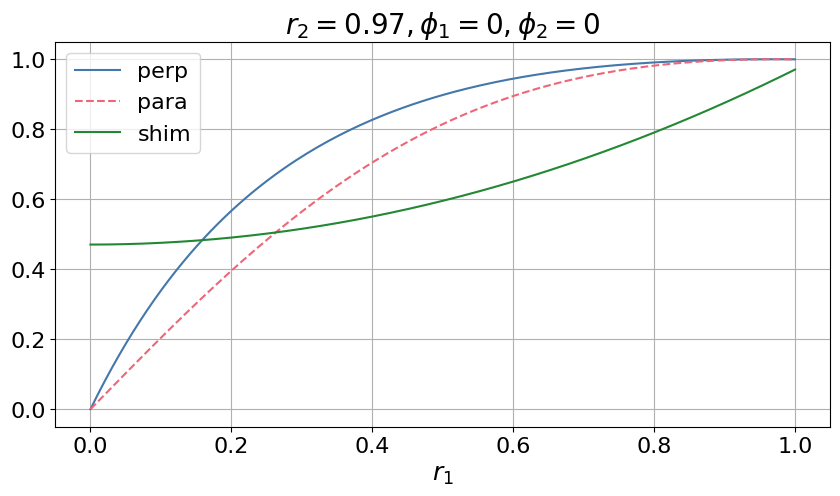

In [133]:
def perp(r1,r2,phi1,phi2):
    return 2*r1*r2/(r1 + r2)**2*(np.cos(phi1-phi2)+1)

def para(r1,r2,phi1,phi2):
    return 2*r1*r2/(r1**2 + r2**2)*np.cos(phi1-phi2)

def shim(r1,r2,*args,**kwargs):
    return (r1**2 + r2**2)/2

def get_phase(lam,freq=1e6,L=1.5):
    '''Returns Larmor phase or phase constant. Wavelength is in nanometers.'''
    m = 1.674e-27
    hbar = 1.0545e-34
    result = 2*freq*m*L/hbar*1e-9
    if lam is not None:
        result = result*lam
    return result

print(f'Larmor phase constant (1/nm): {round(get_phase(None))}')
print(f'Larmor phase (at 1 A): {round(get_phase(.1))}')
print(f'Phase resolution: {5e-3*round(get_phase(None))}')
r_temp = np.linspace(0,1,200)
parms = (r_temp,.97,0,0)

fig,axs = prepare_plot()
plt.title(fr'$r_2={parms[1]},\phi_1={parms[2]},\phi_2={parms[3]}$')
plt.plot(r_temp,perp(*parms),label='perp')
plt.plot(r_temp,para(*parms),'--',label='para')
plt.plot(r_temp,shim(*parms),label='shim')
plt.xlabel('$r_1$')
plt.legend()
plt.show()

## Refl1D Calculations

Seem to agree well with the experimental data. Need to check with Roger and Victor.

##### SLD calculations:

In [135]:
def get_crit(SLD,lam=None,angle=None):
    '''Returns critical angle.'''
    if angle is None:
        result = np.arcsin(lam*np.sqrt(SLD*10**-6/np.pi))*180/np.pi
    else:
        result = np.sin(angle*np.pi/180)/np.sqrt(SLD*10**-6/np.pi)
    return result

def atp_to_wtp(atom_p,A):
    '''Atomic % to weight %.'''
    assert 99.9 < np.sum(atom_p) < 100.1, 'Atomic percents must sum to 1!'
    num = np.array(atom_p)*np.array(A)
    return 100*num/np.dot(atom_p,A)

def wtp_to_atp(weight_p,A):
    '''Weight % to atomic %.'''
    assert 99.9 < np.sum(weight_p) < 100.1, f'Weight percents must sum to 1!'
    num = np.array(weight_p)/np.array(A)
    return 100*num/np.dot(weight_p,1/np.array(A))

def get_bm(M_sat,sat=1,theta=0):
    '''Returns +/- magnetic scattering length in fm.
    M_sat must be given in Bohr magnetons.'''
    proj = np.array([np.cos(theta),-np.cos(theta)])
    return 2.699*M_sat*sat*proj

rho_TiO2 = 4.23  #densities (g/cm^3)
rho_Ti = 4.51
rho_FeCoV = 8.12
rho_Si = 2.329
A_Ni = ptb.nickel.mass
A_Mo = ptb.molybdenum.mass
A_Fe = ptb.iron.mass
A_Co = ptb.cobalt.mass
A_V = ptb.vanadium.mass
A_Ti = ptb.titanium.mass
A_O = ptb.oxygen.mass
A_Si = ptb.silicon.mass

print(f'NiMo weight %: {(wtp_NiMo := atp_to_wtp([90.3,9.7],[A_Ni,A_Mo]))}')
print(f'NiMo weight % (min): {(wtp_NiMo_min := atp_to_wtp([88.8,11.2],[A_Ni,A_Mo]))}')
print(f'NiMo weight % (max): {(wtp_NiMo_max := atp_to_wtp([91.8,8.2],[A_Ni,A_Mo]))}')
print('-'*80)

print(f'FeCoV atomic %: {(atp_FeCoV := wtp_to_atp([49,49,2],[A_Fe,A_Co,A_V]))}')
print(f'FeCoV atomic weight: {(atw_FeCoV := np.dot(atp_FeCoV,[A_Fe,A_Co,A_V])/100)}')
print(f'FeCoV magnetization (bohr): {(M_sat := 10**-6/(rho_FeCoV*avogadro_number/atw_FeCoV)*2.3/(4*np.pi*1e-7)/9.274e-24)}')
print(f'FeCoV bm (fm): {(bm := get_bm(M_sat))}')
print(f'FeCoV magnetic SLD: {(mag_SLD := 10**-29*10**6*(rho_FeCoV*avogadro_number/atw_FeCoV)*bm)}')
print('-'*80)

print(f'TiO2 SLD: {(tio2_SLD := list(neutron_sld(compound="TiO2",density=rho_TiO2)))}')
print(f'Ti SLD: {(ti_SLD := list(neutron_sld(compound="Ti",density=rho_Ti)))}')
print(f'FeCoV SLD: {(fecov_SLD := list(neutron_sld(compound="49%wt Fe // 49%wt Co // V",density=rho_FeCoV)))}')
print(f'Si SLD: {(si_SLD := list(neutron_sld(compound="Si",density=rho_Si)))}')
print('-'*80)

print(f'NiMo SLD: {(nimo_SLD := list(neutron_sld(compound=f"{wtp_NiMo[0]}%wt Ni // Mo")))}')
print(f'NiMo SLD (min): {(nimo_SLD_min := list(neutron_sld(compound=f"{wtp_NiMo_min[0]}%wt Ni // Mo")))}')
print(f'NiMo SLD (max): {(nimo_SLD_max := list(neutron_sld(compound=f"{wtp_NiMo_max[0]}%wt Ni // Mo")))}')
print('-'*80)

print(f'NiMo SLD wt%: {(nimo_SLD_wt := list(neutron_sld(compound="90.3%wt Ni // Mo")))}')
print(f'NiMo SLD wt% (min): {(nimo_SLD_wt_min := list(neutron_sld(compound="88.8%wt Ni // Mo")))}')
print(f'NiMo SLD wt% (max): {(nimo_SLD_wt_max := list(neutron_sld(compound="91.8%wt Ni // Mo")))}')
print('-'*80)

theta0_deg = get_crit(nimo_SLD[0],lam=3.664)  #guess for critical wavelength
print(f'Critical angle from data (85%): {theta0_deg}')
ce = get_crit(nimo_SLD[0],angle=.35)
print(f'Critical edge from data (85%): {ce}')

NiMo weight %: [85.06382664 14.93617336]
NiMo weight % (min): [82.90737816 17.09262184]
NiMo weight % (max): [87.25929866 12.74070134]
--------------------------------------------------------------------------------
FeCoV atomic %: [50.19214807 47.56199407  2.24585785]
FeCoV atomic weight: 57.2036838612854
FeCoV magnetization (bohr): 2.308701963827364
FeCoV bm (fm): [ 6.2311866 -6.2311866]
FeCoV magnetic SLD: [ 5.32664514 -5.32664514]
--------------------------------------------------------------------------------
TiO2 SLD: [2.628195754863884, 0.0005402007780188581, 4.920756248403842]
Ti SLD: [-1.9121467069938165, 0.000960923730421895, 2.736463145953338]
FeCoV SLD: [5.058496546125382, 0.004536280647093534, 4.947873219050799]
Si SLD: [2.072815734219403, 2.3747327004978886e-05, 0.06325610547099135]
--------------------------------------------------------------------------------
NiMo SLD: [8.73122148025809, 0.001047852197076703, 5.429294254700063]
NiMo SLD (min): [8.631341913950953, 0.001

##### Finding $\theta_0$ from the critical edge:

Seems like NiMo composition given by Peter gives the incident scattering angle 0.35, which is what we expected.

Nuclear SLDs: [0.         8.63134191 2.07281573]
Absorption: [0.00000000e+00 1.03418193e-03 2.37473270e-05]
Roughnesses: [0. 0. 0.]
Incident angle: 0.35
Nuclear SLDs: [0.         8.73122148 2.07281573]
Absorption: [0.0000000e+00 1.0478522e-03 2.3747327e-05]
Roughnesses: [0. 0. 0.]
Incident angle: 0.35
Nuclear SLDs: [0.         9.03960249 2.07281573]
Absorption: [0.00000000e+00 1.09005955e-03 2.37473270e-05]
Roughnesses: [0. 0. 0.]
Incident angle: 0.35


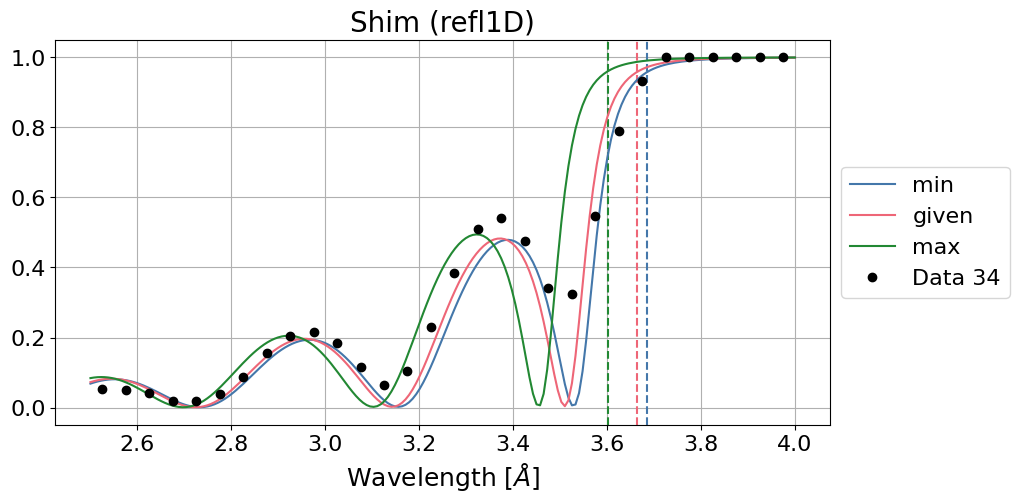

In [137]:
r,R,phases,ce,cek = [],[],[],[],[]

r_indx = 30
indx_max = np.argmax(blank_shim_all[1])
rect = np.where(np.arange(r_indx)<=indx_max,blank_shim_all[1,:r_indx]/np.max(blank_shim_all[1,:r_indx]),1)
    
for nimos in [nimo_SLD_min,nimo_SLD,nimo_SLD_wt_max]:  #[6.5, 0.001090059546626708, 5.627550994410834]:
    air = [100,0,0,0]  #thickness,R(SLD),I(SLD),roughness
    nimo_layer = [1000] + nimos[:-1] + [0]
    si_slab = [10000] + si_SLD[:-1] + [0]  #final roughness unused
    
    w,rho,irho,sigma = np.array(list(zip(air,nimo_layer,si_slab)))
    print(f'Nuclear SLDs: {rho}')
    print(f'Absorption: {irho}')
    print(f'Roughnesses: {sigma}')
    
    theta0_deg = .35
    theta0 = theta0_deg*np.pi/180
    ce.append(get_crit(nimos[0],angle=theta0_deg))
    cek.append(2*np.pi/ce[-1]*np.sin(theta0))
    
    lams = np.linspace(2.5,4,200)
    Qin = 4*np.pi*np.sin(theta0)/lams
    kz = Qin/2
    
    print(f'Incident angle: {theta0_deg}')
    
    r.append(reflectivity(kz,depth=w,rho=rho,irho=irho,sigma=sigma)[0])
    R.append(np.abs(r[-1].conj()*r[-1]))
    phases.append(np.unwrap(np.angle(r[-1]),discont=4))

labels = ['min','given','max','']

plot_lam,plot_data = True,True
fig,axs = prepare_plot({'title':[r'$R = |r|^2$ (refl1D)']})
if plot_lam:
    xaxis = lams
    axs[0].set(xlabel=r'Wavelength $[\AA]$')
    for indx,ci in enumerate(ce):
        axs[0].axvline(x=ci,linestyle='--',color=f'C{indx}')
else:
    xaxis = kz
    axs[0].set(xlabel=r'$k_z [\AA^{-1}]$')
    for indx,ci in enumerate(cek):
        axs[0].axvline(x=ci,linestyle='--',color=f'C{indx}')
if not plot_data:
    for indx,(amp,lb) in enumerate(zip(R,labels)):
        axs[0].plot(xaxis,amp,'-',label=f'{lb}',color=f'C{indx}')
else:
    axs[0].set(title='Shim (refl1D)')
    try:
        for indx,(Ri,lb) in enumerate(zip(R,labels)):
            axs[0].plot(xaxis,Ri,label=lb,color=f'C{indx}')
        axs[0].plot(lam_b[:r_indx],rect,'o',color='black',label='Data 34')
        #axs[0].plot(lam_b[:30],blank_shim_all[1,:30]/np.max(blank_shim_all[1,:30]),'o',color='purple',label='Data q av')
    except Exception:
        print('Data not found!')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

[ 0.35165256  8.83472973 -0.01      ]
689950.2380076472
[5.03534629e-05 1.55895898e-01 4.68080826e-04]


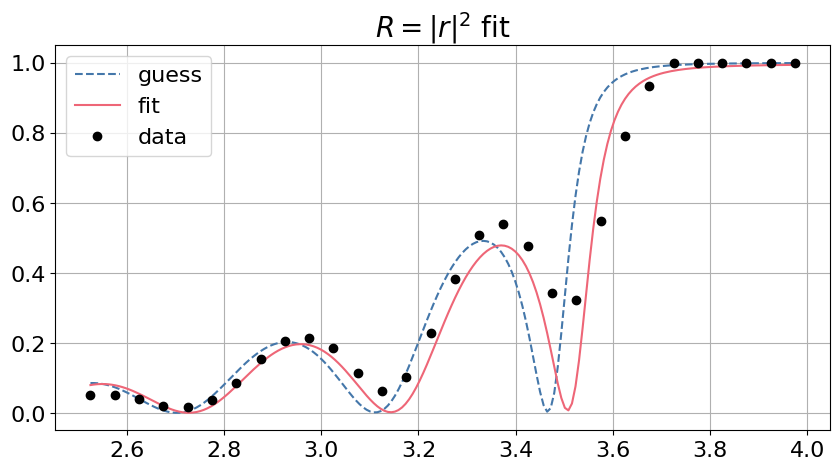

In [138]:
r_indx = 30
indx_max = np.argmax(blank_shim_all[1])
rect = np.where(np.arange(r_indx)<=indx_max,blank_shim_all[1,:r_indx]/np.max(blank_shim_all[1,:r_indx]),1)
lams = lam_b[:r_indx]
lams_fine = np.linspace(lams[0],lams[-1],200)

def make_blank(lams,theta0,rb,ib,s1=0,s2=0):
    Qin = 4*np.pi*np.sin(theta0*np.pi/180)/lams
    kz = Qin/2
    w = [100,1e3,1e5]
    rho = [0,rb,2.07281573]
    irho = [0,ib,2.37473270e-05]
    result = reflectivity(kz,depth=w,rho=rho,irho=irho,sigma=[s1,s2])[0]  #convolve with gaussian here?
    return np.abs(result*result.conj())

guess = [.35,8.97140229230955,-0.001080725153973794]
lb = [.33,8.5,-.01]
up = [.37,9.5,0]
bnds = (lb,up)
blank_parms,cov = curve_fit(make_blank,lams,rect,p0=guess,bounds=bnds)
print(blank_parms)
print(np.linalg.cond(cov))
print(np.diag(cov))

fig,axs = prepare_plot({'title':[r'$R = |r|^2$ fit']})
plt.plot(lams_fine,make_blank(lams_fine,*guess),'--',label='guess')
plt.plot(lams_fine,make_blank(lams_fine,*blank_parms),'-',label='fit')
plt.plot(lams,rect,'o',label='data',color='black')
plt.legend()
plt.show()

[ 3.43299258e-01  9.01954961e+00 -4.63270046e-03  1.03148312e-04]
50600978186.15618
[5.40980452e-05 1.75721671e-01 6.75254623e-04 2.27916637e-10]


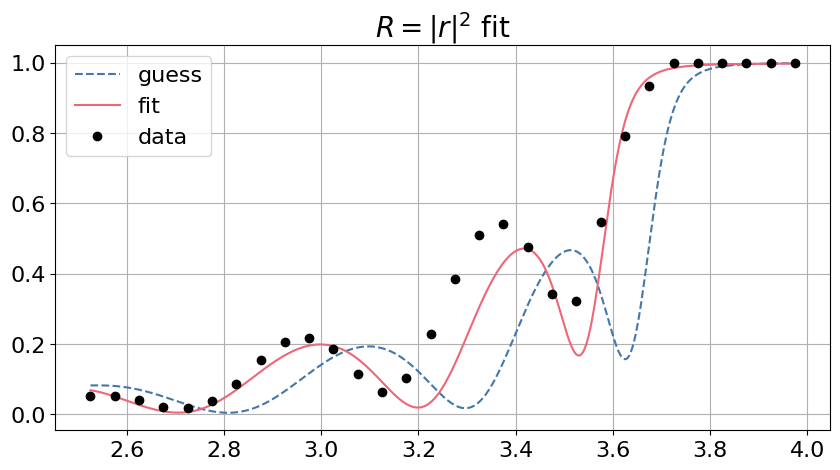

In [139]:
lams_fine = np.linspace(lams[0],lams[-1],400)

def make_blank(lams,theta0,rb,ib,dk,s1=0,s2=0,fitting=True):
    '''Step must be smaller than dk.'''
    Qin = 4*np.pi*np.sin(theta0*np.pi/180)/lams
    kz = np.linspace(Qin[0],Qin[-1],len(Qin))/2
    step = np.abs(np.diff(kz)[0])
    w = [100,1e3,1e5]
    rho = [0,rb,2.07281573]
    irho = [0,ib,2.37473270e-05]
    r = reflectivity(kz,depth=w,rho=rho,irho=irho,sigma=[s1,s2])[0]
    R = np.abs(r*r.conj())
    temp_kz = np.arange(-10*dk,10*dk,step)
    res = np.exp(-(temp_kz/dk)**2/2)
    res = res/np.sum(res)
    R = convolve(R,res,mode='nearest')
    if fitting:
        return R
    else:
        return R,(temp_kz,res)

guess = [.35,8.77140229230955,-0.001080725153973794,1e-4]
G,res = make_blank(lams_fine,*guess,fitting=False)
if False:
    fig,axs = prepare_plot({'title':['Res']})
    plt.plot(*res)
    plt.show()

lb = [.33,8.5,-1e-2,1e-5]
up = [.37,9.5,0,1e-2]
bnds = (lb,up)
blank_parms,cov = curve_fit(make_blank,lams,rect,p0=guess,bounds=bnds)
print(blank_parms)
print(np.linalg.cond(cov))
print(np.diag(cov))

fig,axs = prepare_plot({'title':[r'$R = |r|^2$ fit']})
plt.plot(lams_fine,G,'--',label='guess')
plt.plot(lams_fine,make_blank(lams_fine,*blank_parms),'-',label='fit')
plt.plot(lams,rect,'o',label='data',color='black')
plt.legend()
plt.show()

##### Parallel at $\theta_0 = 0.35$:

Thicknesses: [ 100.   40.  500.  500.  500.  500. 1000. 1000.]
Nuclear SLDs: [ 0.          2.62819575 -1.91214671  4.80557172  2.07281573  4.80557172
  8.73122148  2.07281573]
Absorption: [0.00000000e+00 5.40200778e-04 9.60923730e-04 4.53628065e-03
 2.37473270e-05 4.53628065e-03 1.04785220e-03 2.37473270e-05]
Magnetic SLDs: [0.         0.         0.         7.98996771 0.         7.98996771
 0.         0.        ]
Magnetic dir: [  0.   0.   0. -90.   0. -90.   0.   0.]
Roughnesses: [0. 0. 0. 0. 0. 0. 0. 0.]
Guide field angle: -90
Incident angle: 0.33


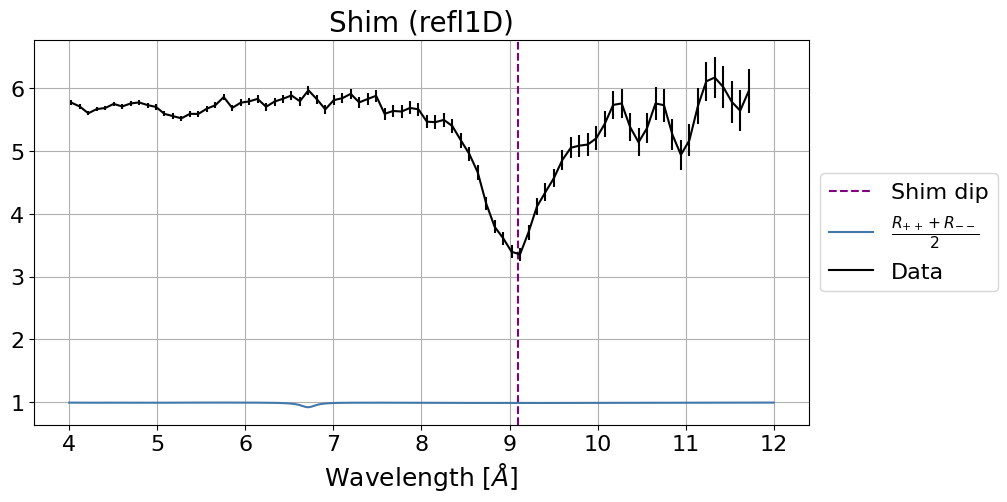

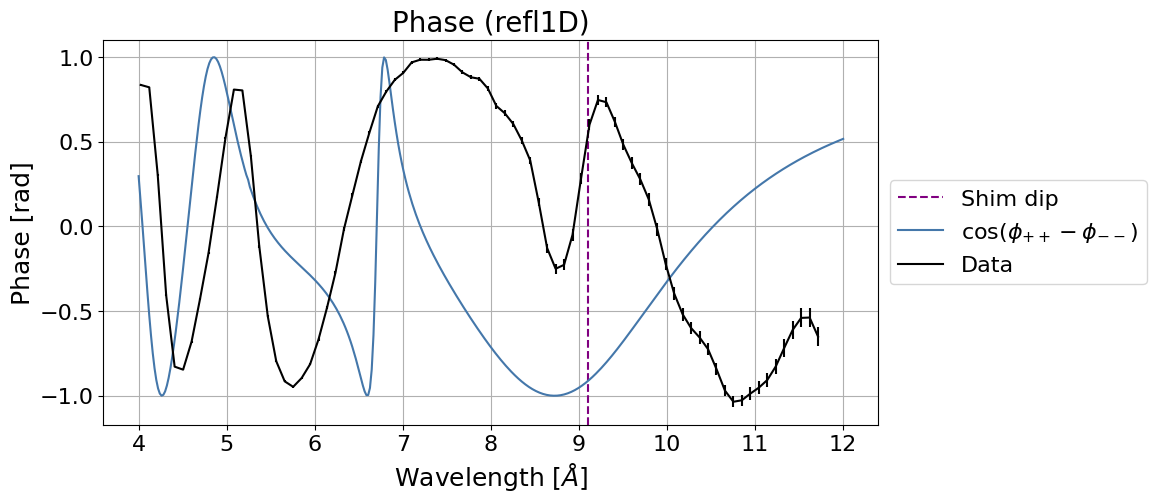

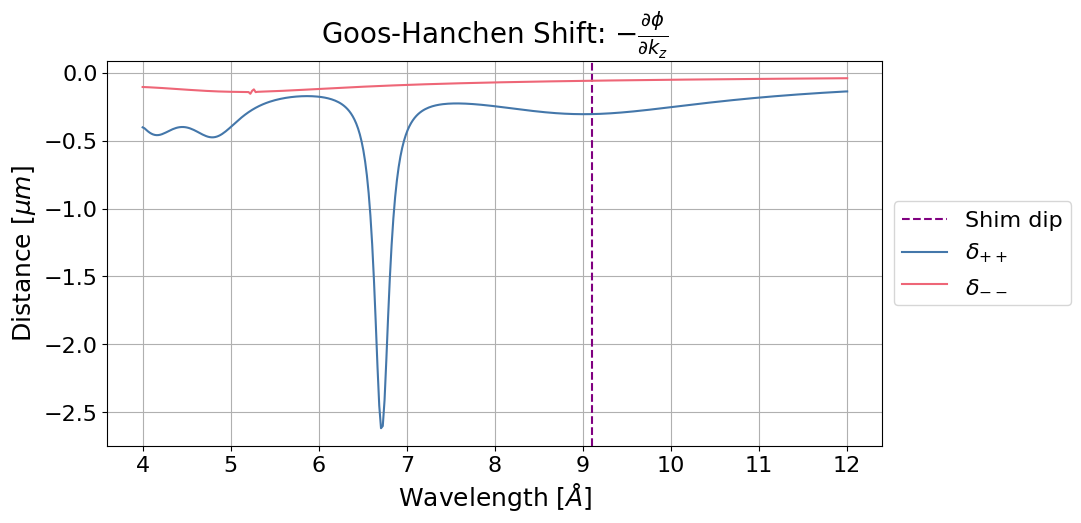

In [192]:
mdir1,mdir2 = -90,-90
guide = -90  #guide field angle

#mag_sat = [.895,.895] for 4.95 magnetic SLD
mag_sat = [1.5]*2
density_corr = .95

air = [100,0,0,0,0,0]  #thickness,R(SLD),I(SLD),MSLD,Mdir,roughness
tio_layer = [40] + tio2_SLD[:-1] + [0,0,0]
ti_layer = [500] + ti_SLD[:-1] + [0,0,0]
#feco_layer1 = [500] + fecov_SLD[:-1] + [mag_SLD[0]*mag_sat[0],mdir1,0]
feco_layer1 = [500] + [density_corr*fecov_SLD[0]] + fecov_SLD[1:-1] + [mag_SLD[0]*mag_sat[0],mdir1,0]
si_layer = [500] + si_SLD[:-1] + [0,0,0]
#feco_layer2 = [500] + fecov_SLD[:-1] + [mag_SLD[0]*mag_sat[1],mdir2,0]
feco_layer2 = [500] + [density_corr*fecov_SLD[0]] + fecov_SLD[1:-1] + [mag_SLD[0]*mag_sat[0],mdir1,0]
nimo_layer = [1000] + nimo_SLD[:-1] + [0,0,0]
si_slab = [1000] + si_SLD[:-1] + [0,0,0]  #final roughness unused

w,rho,irho,mrho,mdirs,sigma = np.array(list(zip(air,tio_layer,ti_layer,feco_layer1,si_layer,feco_layer2,nimo_layer,si_slab)))
print(f'Thicknesses: {w}')
print(f'Nuclear SLDs: {rho}')
print(f'Absorption: {irho}')
print(f'Magnetic SLDs: {mrho}')
print(f'Magnetic dir: {mdirs}')
print(f'Roughnesses: {sigma}')
print(f'Guide field angle: {guide}')

theta0_deg = .33
theta0 = theta0_deg*np.pi/180  #from blank simulation
lams = np.linspace(4,12,400)
Qin = 4*np.pi*np.sin(theta0)/lams
kz = Qin/2

sd = 9.1  #shim dip position in wavelength
sdk = 2*np.pi/sd*np.sin(theta0)

print(f'Incident angle: {theta0_deg}')

r = reflectivity(kz,depth=w,rho=rho,irho=irho,rhoM=mrho,thetaM=mdirs,Aguide=guide,sigma=sigma)
R = [np.abs(ri.conj()*ri) for ri in r]
phases = [np.unwrap(np.angle(ri),discont=4) for ri in r]
GH = [-np.gradient(ph,kz)*1e-4 for ph in phases]  #from Angstroms to microns

labels = [r'$+ \to +$',r'$+ \to -$',r'$- \to +$',r'$- \to -$']
labels_r = [r'$r_{++}$',r'$r_{+-}$',r'$r_{-+}$',r'$r_{--}$']
labels_R = [r'$R_{++}$',r'$R_{+-}$',r'$R_{-+}$',r'$R_{--}$']
labels_arg = [r'$\phi_{++}$',r'$\phi_{+-}$',r'$\phi_{-+}$',r'$\phi_{--}$']
labels_GH = [r'$\delta_{++}$',r'$\delta_{+-}$',r'$\delta_{-+}$',r'$\delta_{--}$']

plot_all,plot_lam,plot_data = False,True,True
fig,axs = prepare_plot({'title':[r'$R = |r|^2$ (refl1D)']})
if plot_lam:
    xaxis = lams
    axs[0].set(xlabel=r'Wavelength $[\AA]$')
    axs[0].axvline(x=sd,linestyle='--',color='purple',label='Shim dip')
else:
    xaxis = kz
    axs[0].set(xlabel=r'$k_z [\AA^{-1}]$')
    axs[0].axvline(x=sdk,linestyle='--',color='purple',label='Shim dip')
if plot_all:
    for indx,(amp,lb) in enumerate(zip(R,labels_R)):
        axs[0].plot(xaxis,amp,'-',label=f'{lb}',color=f'C{indx}')
else:
    if not plot_data:
        for indx,(amp,lb) in enumerate(zip(R[0::3],labels_R[0::3])):
            axs[0].plot(xaxis,amp,'-',label=f'{lb}',color=f'C{indx}')
    else:
        axs[0].set(title='Shim (refl1D)')
        try:
            axs[0].plot(xaxis,np.sum(R[0::3],axis=0)/2,label=r'$\frac{R_{++} + R_{--}}{2}$',color='C0')
            axs[0].plot(qlam_blank,para_p35_shim_norm,color='black',label='Data')
            axs[0].errorbar(qlam_blank,para_p35_shim_norm,yerr=para_p35_shim_norm_errors,linestyle='',color='black')
        except Exception:
            print('Data not found!')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig,axs = prepare_plot({'title':[r'$\phi = \arg(r)$ (refl1D)'],'ylabel':['Phase [rad]']})
if plot_lam:
    xaxis = lams
    axs[0].set(xlabel=r'Wavelength $[\AA]$')
    axs[0].axvline(x=sd,linestyle='--',color='purple',label='Shim dip')
else:
    xaxis = kz
    axs[0].set(xlabel=r'$k_z [\AA^{-1}]$')
    axs[0].axvline(x=sdk,linestyle='--',color='purple',label='Shim dip')
if plot_all:
    for indx,(ph,lb) in enumerate(zip(phases,labels_arg)):
        axs[0].plot(xaxis,ph,'-',label=f'{lb}',color=f'C{indx}')
else:
    if not plot_data:
        for indx,(ph,lb) in enumerate(zip(phases[0::3],labels_arg[0::3])):
            axs[0].plot(xaxis,ph,'-',label=f'{lb}',color=f'C{indx}')
    else:
        axs[0].set(title='Phase (refl1D)')
        try:
            axs[0].plot(xaxis,np.cos(phases[0]-phases[3]),label=r'$\cos(\phi_{++} - \phi_{--})$',color='C0')
            axs[0].plot(qlam_blank,para_p35_rb_norm,label='Data',color='black')
            axs[0].errorbar(qlam_blank,para_p35_rb_norm,yerr=para_p35_err_rb_norm,linestyle='',color='black')
        except Exception:
            print('Data not found!')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig,axs = prepare_plot({'title':[r'Goos-Hanchen Shift: $-\frac{\partial \phi}{\partial k_z}$'],'ylabel':[r'Distance [$\mu m$]']})
if plot_lam:
    xaxis = lams
    axs[0].set(xlabel=r'Wavelength $[\AA]$')
    axs[0].axvline(x=sd,linestyle='--',color='purple',label='Shim dip')
else:
    xaxis = kz
    axs[0].set(xlabel=r'$k_z [\AA^{-1}]$')
    axs[0].axvline(x=sdk,linestyle='--',color='purple',label='Shim dip')
if plot_all:
    for indx,(gh,lb) in enumerate(zip(GH,labels_GH)):
        axs[0].plot(xaxis,gh,'-',label=f'{lb}',color=f'C{indx}')
else:
    for indx,(gh,lb) in enumerate(zip(GH[0::3],labels_GH[0::3])):
        axs[0].plot(xaxis,gh,'-',label=f'{lb}',color=f'C{indx}')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
mdir1,mdir2 = 0,0
guide = -90  #guide field angle?
feco_nuc = 5.058  #Vacoflux 50
feco_mag_corr = .965  #can be 95-100% magnetized
feco_mag = 4.661990*feco_mag_corr

no_abs = 1  #if 0 (1), turns off (on) all absorption
air = (0,0,0,0,0,0)  #thickness,R(SLD),I(SLD),MSLD,Mdir,roughness
tio_layer = (30,2.628,-0.001*no_abs,0,0,0)
ti_layer = (500,-1.91,-0.001*no_abs,0,0,0)
feco_layer1 = (500,feco_nuc,-0.005*no_abs,feco_mag,mdir1,0)
si_layer = (500,2.073,0,0,0,0)
feco_layer2 = (500,feco_nuc,-0.005*no_abs,feco_mag,mdir2,0)
nimo_layer = (1000,ni_90,-0.001*no_abs,0,0,0)
si_slab = (0,2.073,0,0,0,0)  #final roughness unused

w,rho,irho,mrho,mdirs,sigma = np.array(list(zip(air,tio_layer,ti_layer,feco_layer1,si_layer,feco_layer2,nimo_layer,si_slab)))
print(f'Thicknesses: {w}')
print(f'Nuclear SLDs: {rho}')
print(f'Absorption: {irho}')
print(f'Magnetic SLDs: {mrho}')
print(f'Magnetic dir: {mdirs}')
print(f'Roughnesses: {sigma}')
print(f'Guide field angle: {guide}')

theta0 = .367*np.pi/180  #critical edge location
lams = np.linspace(3,12,400)
Qin = 4*np.pi*np.sin(theta0)/lams
kz = Qin/2
irho = [ir*np.sqrt(9) for ir in irho]  #do I need to include 1/v effect here?

ce = 3.8  #critical edge in wavelength
cek = 2*np.pi/ce*np.sin(theta0)
sd = 8.95  #shim dip position in wavelength
sdk = 2*np.pi/sd*np.sin(theta0)

r = reflectivity(kz,depth=w,rho=rho,irho=irho,rhoM=mrho,thetaM=mdirs,Aguide=guide,sigma=sigma)
R = [np.abs(ri.conj()*ri) for ri in r]
phases = [np.unwrap(np.angle(ri),discont=4) for ri in r]
GH = [-np.gradient(ph,kz)*1e-4 for ph in phases]  #from Angstroms to microns

labels = [r'$+ \to +$',r'$+ \to -$',r'$- \to +$',r'$- \to -$']
labels_r = [r'$r_{++}$',r'$r_{+-}$',r'$r_{-+}$',r'$r_{--}$']
labels_R = [r'$R_{++}$',r'$R_{+-}$',r'$R_{-+}$',r'$R_{--}$']
labels_arg = [r'$\phi_{++}$',r'$\phi_{+-}$',r'$\phi_{-+}$',r'$\phi_{--}$']
temp_labels = ['']*4

plot_all,plot_lam,plot_data = False,True,True
fig,axs = prepare_plot({'title':[r'$R = |r|^2$ (refl1D)']})
if plot_lam:
    xaxis = lams
    axs[0].set(xlabel=r'Wavelength $[\AA]$')
    axs[0].axvline(x=ce,linestyle='--',color='red',label='C. edge')
    axs[0].axvline(x=sd,linestyle='--',color='purple',label='Shim dip')
else:
    xaxis = kz
    axs[0].set(xlabel=r'$k_z [\AA^{-1}]$')
    axs[0].axvline(x=cek,linestyle='--',color='red',label='C. edge')
    axs[0].axvline(x=sdk,linestyle='--',color='purple',label='Shim dip')
if plot_all:
    for indx,(amp,lb) in enumerate(zip(R,labels_R)):
        axs[0].plot(xaxis,amp,'-',label=f'{lb}',color=f'C{indx}')
else:
    if not plot_data:
        temp = [np.abs(r[0] + r[2])**2,np.abs(r[1] - r[3])**2]
        for indx,(amp,lb) in enumerate(zip(temp,temp_labels)):
            axs[0].plot(xaxis,amp,'-',label=f'{lb}',color=f'C{indx}')
    else:
        axs[0].set(title='Shim (refl1D)')
        try:
            axs[0].plot(xaxis,R[0]+R[1],label=r'$R_{++} + R_{--}$',color='C0')  #why does this give the shim?
            axs[0].plot(qlam_blank,perp_shim_norm,color='black',label='Data')
            axs[0].errorbar(qlam_blank,perp_shim_norm,yerr=perp_shim_norm_errors,linestyle='',color='black')
        except Exception:
            print('Data not found!')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig,axs = prepare_plot({'title':[r'$\phi = \arg(r)$ (refl1D)'],'ylabel':['Phase [rad]']})
if plot_lam:
    xaxis = lams
    axs[0].set(xlabel=r'Wavelength $[\AA]$')
    axs[0].axvline(x=ce,linestyle='--',color='red',label='C. edge')
    axs[0].axvline(x=sd,linestyle='--',color='purple',label='Shim dip')
else:
    xaxis = kz
    axs[0].set(xlabel=r'$k_z [\AA^{-1}]$')
    axs[0].axvline(x=cek,linestyle='--',color='red',label='C. edge')
    axs[0].axvline(x=sdk,linestyle='--',color='purple',label='Shim dip')
if plot_all:
    for indx,(ph,lb) in enumerate(zip(phases,labels_arg)):
        axs[0].plot(xaxis,ph,'-',label=f'{lb}',color=f'C{indx}')
else:
    if not plot_data:
        temp = np.unwrap([np.angle(r[0] + r[2]),np.angle(r[1] - r[3])],discont=4)
        for indx,(ph,lb) in enumerate(zip(temp,temp_labels)):
            axs[0].plot(xaxis,ph,'-',label=f'{lb}',color=f'C{indx}')
    else:
        axs[0].set(title='Phase (refl1D)')
        try:
            temp = (1 + np.cos(np.angle(r[0] + r[2]) - np.angle(-r[1] + r[3])))/2  #why does this give the pol?
            axs[0].plot(xaxis,temp,label=r'',color='C0')
            axs[0].plot(qlam_blank,perp_rb_norm,label='Data',color='black')
            axs[0].errorbar(qlam_blank,perp_rb_norm,yerr=perp_err_rb_norm,linestyle='',color='black')
        except Exception:
            print('Data not found!')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig,axs = prepare_plot({'title':[r'Goos-Hanchen Shift: $-\frac{\partial \phi}{\partial k_z}$'],'ylabel':[r'Distance [$\mu m$]']})
if plot_lam:
    xaxis = lams
    axs[0].set(xlabel=r'Wavelength $[\AA]$')
    axs[0].axvline(x=ce,linestyle='--',color='red',label='Critical edge')
    axs[0].axvline(x=sd,linestyle='--',color='purple',label='Shim dip')
else:
    xaxis = kz
    axs[0].set(xlabel=r'$k_z [\AA^{-1}]$')
    axs[0].axvline(x=cek,linestyle='--',color='red',label='Critical edge')
    axs[0].axvline(x=sdk,linestyle='--',color='purple',label='Shim dip')
if plot_all:
    for indx,(gh,lb) in enumerate(zip(GH,labels)):
        axs[0].plot(xaxis,gh,'-',label=f'{lb}',color=f'C{indx}')
else:
    temp = np.unwrap([np.angle(r[0] + r[2]),np.angle(-r[1] + r[3])],discont=4)  #why does this give the Gh shift?
    temp = [-np.gradient(t,kz)*1e-4 for t in temp]
    for indx,(gh,lb) in enumerate(zip(temp,temp_labels)):
        axs[0].plot(xaxis,gh,'-',label=f'{lb}',color=f'C{indx}')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Experiment log
***

### 11/14 Day One (Tuesday)
Setup and calibration of the beamline.

* 9:30
* We decided that the magnetization of the sample will probably not be a problem because the sample is so thin. Therefore we will not worry about the mismatch of the sample field direction and the guide field direction.
* Still need to magnetize the sample today and finish the sample holder.

* 2:00
* Found the echo before lunch, need to finish building the sample holder and check the echo as we scan the sample stage (should only need a few mm of drive)
* Should we use a supermirror or a blank for tuning echo? (decided to just use blank)
* Aligning the sample slit with the transmission monitor

* 7:00
* Decided to run echo scans overnight to test the long-term stability of the echo point because we cannot retune the echo once we put the magnetic sample in the beam. Also included a scan of the sample stack translation.

### 11/15 Day Two (Wednesday)
Mounting the blank with NO longitudinal splitting. (and the sample)

* 10:30
* Echo stability was very stable overnight for all positions of the sample stack. Above 80% for 3-10 AA.
* Leveled the sample stack (+/- 0.1 degrees for both directions)
* Adjusted the sample center of rotation to be the same center of rotation of the second arm (within few cms).
* Finding the center of the beam using a piece of Cd taped to the Al sample holder
* By eye using laser, the center is at 27 mm and 58.25 degrees
* Laser beam and neutron beam are off by 0.4 mm using the monitor right after the sample position (center 26.6 mm using neutrons, add 0.8 mm to include the thickness of the sample)
* Increasing the beam height did not change the tune (25 mm at the front, 40 mm at the sample)
* Collimation from pipe 31 mm
* Snout aperture 30 mm height 30 mm width (yes, it is that wide)
  

* 11:00
* Pixel 34 is the center of the beam at the moment (0.64 mm per pixel)
* 41004,41005 are the spectra numbers
  

* 1:00
* Magnetized the sample, wrote the field direction on the Al plate. Went to above 0.027 Tesla
* Found the critical edge to be at 0.35 degrees (aiming for 0.4 degrees?)

* 3:00
* The blank appears to be curved? The beam is spread over 8 pixels instead of 4 as before.

* 5:00
* Aperture width is still 2 mm wide
* Magnetic sample agrees well with Victor's model assuming 89% magnetization. This value agrees more closely with the 
* Going to measure the magnetic sample overnight

### 11/16 Day Three (Thursday)

* 10:00
* Magnetic sample ran successfully overnight. Improving statistics on the blank until after lunch.

* 8:00
* Magnetic sample rotated by 90 degrees replicated the original polarization except now the signal is cos(phi) instead of 1/2*(1 + cos(phi))
* Going to run this orientation overnight and add the grating in tomorrow

### 11/17 Day Four (Friday)

* 11:00
* Added the grating after the sample (GR27, 2 um period, 10.5 um depth, 560 nm groove width)
* Sample still in the vertical direction
* Doubled-checked where the instrument parameters are stored. They appear in the log book under "Analysis/Property/Run".
  * Pre-sample slit: 0.5 mm by 25 mm
  * Post sample slit: 2 mm by 25 mm

### 11/18 Day Five (Saturday)

* 10:00
* Running with grating before sample until 2:00 pm to compare with the sample only run
* After that, we'll get better statistics for the P0 run before changing the incident angle to shift the GH bump in the polarization to appear at shorter wavelengths
* The journal viewer title was wrong for some runs. The correct naming is
  * 79130 - 79142 No grating
  * 79143 - 79144 Grating after sample
  * 79145 - 79159 Grating before sample
  * 79160 - 79164 Grating after sample (again)

* 11:30
* Going to measure the broken samples with X-rays (don't know the roughness numbers)
* Got the fitting functon for P0 to work, need to port the q function as well
* The new data seems show that the grating was slightly tilted about the vertical axis or that the P0 has slightly decreased (more likely grating angle misalignment because peak heights are still tall)

### 11/19 Day Six (Sunday)

* 9:00
* Overnight data looks good. The peak shifted from ~8.5 A to 11 A as expected
* Running with grating before the sample, will run until 8 pm tonight, then put the grating after the sample to finish through the night.
* Results at 0.4 consistent with the old 0.35 degree data
* 0.40 degree data:
  * 79179 - 79188 No grating
  * 79189 - 79199 Grating before sample
  * 79200 - 79212 Grating after sample

## Data reduction and analysis
***

### Data loading and processing functions

In [242]:
data_paths = {'laptop':'C:\\Users\\samck\\Documents\\GitHub\\Goos-Hanchen\\\Reduced_data_correct_eb\\',
             'ceem':'C:\\Users\\samckay\\Documents\\GitHub\\Goos-Hanchen\\\Reduced_data_correct_eb\\',
             'home':'C:\\Users\\samck\\Documents\\GitHub\\Goos-Hanchen\\\Reduced_data_correct_eb\\'}

DEFAULT_PATH = data_paths['home']
assert isdir(DEFAULT_PATH), 'Default data directory was not found!'

save_paths = {'laptop':'C:\\Users\\samck\\Documents\\GitHub\\Goos-Hanchen\\\Pol and Shim\\',
             'ceem':'C:\\Users\\samckay\\Documents\\GitHub\\Goos-Hanchen\\\Pol and Shim\\',
             'home':'C:\\Users\\samck\\Documents\\GitHub\\Goos-Hanchen\\\Pol and Shim\\'}

DEFAULT_SAVE_PATH = save_paths['home']
assert isdir(DEFAULT_PATH), 'Default saving directory was not found!'

def load_data_2D(file,path=DEFAULT_PATH,pix_trim=None):
    '''Loads the mantid output data into numpy 2D array.
    Returns X, Y, and E coordinate arrays, and pixel name.'''
    assert isdir(path), 'Data directory was not found!'
    assert isfile(path+file), 'Data file was not found!'
    with open(path+file) as f:
        lines = f.readlines()[1:]
        lines = [l.replace('\n','').split(',') for l in lines]
        pnames,xs,ys,es = [],[],[],[]  #pixel name from DAC
        for l in lines:
            if len(l) != 3: pnames.append(l[0])
            else:
                xs.append(float(l[0]))
                try:
                    ys.append(float(l[1]))
                    es.append(float(l[2]))
                except Exception:
                    ys.append(np.NaN)  #dumbass Mantid stuff
                    es.append(np.Inf)
        lnum,pnum = len(lines),len(pnames)  #tof pixels, spatial pixels
        new_shape = (len(pnames),(len(lines)-len(pnames))//len(pnames))
    result = [xs,ys,es]
    result = [np.array(r).reshape(new_shape) for r in result]
    pnames = np.array(pnames,dtype='int')
    if pix_trim is not None:
        result = [r[pix_trim,:] for r in result]
        pnames = (pnames - pnames[0])[pix_trim]
    return result,pnames  #pixel names (pnames) is inhomogenous part

def unnormalize(counts,errors):
    '''Returns raw counts and errors assuming Poisson statistics.'''
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
        errs = np.nan_to_num(counts/errors)
        result = errs**2
    return result,errs

def trim_arr(arrays,segments):
    '''Applies the same trim to a list of arrays. First array determines
    the trimming for the other arrays.'''
    result = []
    masks = np.array([(s[0]<arrays[0]) & (arrays[0]<s[1]) for s in segments])

    if masks[0].ndim == 1: new_pix_nums = int(np.sum(masks[0]))
    else: new_pix_nums = masks[0].shape[0],np.sum(masks[0],axis=1)[0] #number of new vertical and horizontal pixels
    for a in arrays:
        for m in masks:
            a = a[m]
        result.append(a)
    return [r.reshape(new_pix_nums) for r in result]  #assumes unpacking

def Q_conversion(lam,pixels,center,th0,pix_size=.64,dist=4350.):
    '''Returns conversion matrix of wavelength to momentum transfer.'''
    Theta_i = np.array([(p - center)/dist*pix_size for p in pixels])
    Q = np.array([4*np.pi/lam*(th0*np.pi/180. - .5*thi) for thi in Theta_i])
    return np.flip(Q,axis=1)

def get_constant_Q(data,errs,lam,pixels,center,th0,q_bins=200,\
                   spln=CubicSpline,spln_parms={},trim=[4.,12.],\
                   show=(False,False,False,False)):
    '''Returns 2D counts rebinned with constant momentum transfer Q.
    Trims wavelength range to the center pixel range.'''
    Q = Q_conversion(lam,pixels,center,th0)
    Qbnds = [(min(q),max(q)) for q in Q]
    data_Q = np.flip(data,axis=1)  #need to flip for spline
    errs_Q = np.flip(errs,axis=1)
    q_tot = np.linspace(np.min(Q),np.max(Q),q_bins)  #each pixel wil get this binning
    
    data_intrp =np.array([spln(q,p,**spln_parms)(q_tot) for q,p in zip(Q,data_Q)])
    err_intrp = np.array([spln(q,e,**spln_parms)(q_tot) for q,e in zip(Q,errs_Q)])
    for indx,b in enumerate(Qbnds):
        data_intrp[indx] = np.where((b[-1]>=q_tot) & (q_tot>=b[0]),data_intrp[indx],0.)  #preventing spline blow up
        err_intrp[indx] = np.where((b[-1]>=q_tot) & (q_tot>=b[0]),err_intrp[indx],0.)
    data_intrp = np.where(data_intrp>0,data_intrp,0.)  #keeping counts positive
    err_intrp = np.where(err_intrp>0,err_intrp,0.)
    
    if trim is not None:
        q_trim = np.flip(4*np.pi*np.sin(th0*np.pi/180.)/np.array(trim))
        temp,tr_data_intrp,tr_err_intrp = trim_arr((np.stack([q_tot]*len(pixels)),data_intrp,err_intrp),[q_trim])
        q_trim = temp[0]
    else:
        q_trim,tr_data_intrp,tr_err_intrp = q_tot,data_intrp,err_intrp  #copy of untrimmed data

    lam_const_q = 4*np.pi/q_trim*np.sin(th0*np.pi/180)  #convert to wavelength
    lam_bins = np.linspace(np.min(lam_const_q),np.max(lam_const_q),len(q_trim))
    second_intrp = np.array([spln(np.flip(lam_const_q),p,**spln_parms)(lam_bins) for p in np.flip(tr_data_intrp,axis=1)])
    second_intrp_errs = np.array([spln(np.flip(lam_const_q),p,**spln_parms)(lam_bins) for p in np.flip(tr_err_intrp,axis=1)])
    second_intrp = np.where(second_intrp>0,second_intrp,0.)  #keeping counts positive
    second_intrp_errs = np.where(second_intrp_errs>0,second_intrp_errs,0.)

    if any(show[:3]):
        temp = [Q,data_Q,errs_Q,data_intrp,err_intrp,tr_data_intrp,tr_err_intrp,second_intrp,second_intrp_errs]
        for indx,(q,p,e,ip,ie,tp,te,i2p,i2e) in enumerate(zip(*temp)):
            fig,axs = prepare_plot({'xlabel':['Q']})
            axs[0].plot(q,p,'.',label=f'Pix {pixels[indx]} data',color=f'C0')
            axs[0].errorbar(q,p,yerr=e,linestyle='',color=f'C0')
            if show[0]:
                axs[0].plot(q_tot,ip,'--',color='red',label='Intrp')
                axs[0].errorbar(q_tot,ip,yerr=ie,linestyle='',color='red')
            if show[1]:
                axs[0].plot(q_trim,tp,'.--',color='purple',label='Trimmed')
                axs[0].errorbar(q_trim,tp,yerr=te,linestyle='',color='purple')
            if show[2]:
                axs[0].clear()
                axs[0].grid()
                axs[0].plot(lam,data[indx],'.--',label=f'Pix {pixels[indx]} data',color=f'C0')
                axs[0].errorbar(lam,data[indx],yerr=errs[indx],linestyle='',color=f'C0')
                axs[0].plot(lam_bins,i2p,'.--',color='green',label='Trimmed')
                axs[0].errorbar(lam_bins,i2p,yerr=i2e,linestyle='',color='green')
                axs[0].set(xlabel='Wavelength')
            plt.legend()
            plt.show()
    if show[3]:
        temp = [second_intrp,second_intrp_errs]
        fig,axs = prepare_plot({'xlabel':[r'Wavelength [$\AA$]']})
        for indx,(i2p,i2e) in enumerate(zip(*temp)):
            axs[0].plot(lam_bins,i2p,'.--',label=f'Pix {pixels[indx]}',color=f'C{indx}')
            axs[0].errorbar(lam_bins,i2p,yerr=i2e,linestyle='',color=f'C{indx}')
        sum_err = np.sqrt(np.sum(second_intrp_errs**2,axis=0))
        s = np.sum(second_intrp,axis=0)
        axs[0].plot(lam_bins,s,'.--',color='black',label=f'Sum')
        axs[0].errorbar(lam_bins,s,yerr=sum_err,linestyle='',color='black')
        plt.legend()
        plt.show()
    
    return lam_bins,second_intrp,second_intrp_errs

def get_center(up,down,pname,threshold=.25,show=True):
    '''Returns the center pixel of the given data (assumed to be from blank).
    The pixel number is the weight for the average.'''
    sum1,sum2 = np.nansum(up,axis=1),np.nansum(down,axis=1)
    sum = sum1 + sum2
    c1,c2 = np.average(pname,weights=sum1),np.average(pname,weights=sum2)
    center = int(round(np.mean([c1,c2])))
    pixels = pname[np.where(sum>np.max(sum)*threshold)]
    
    if show:
        print('Center pixel:')
        print(f'[up,down]: {np.round([c1,c2],5)} -> {center}')
        print('Pixels used:')
        print(pixels,f': {len(pixels)} total.')
        plot_parms = {'xlabel':['pixel'],'ylabel':['counts']}
        fig,axs = prepare_plot(plot_parms)
        axs[0].plot(pname,sum1,'o-')
        axs[0].plot(pname,sum2,'o-')
        axs[0].plot(pname,sum,'o-',label='shim')
        axs[0].axvline(x=center,ls='--',color='blue')
        axs[0].axvline(x=pixels[0],ls='--',color='red')
        axs[0].axvline(x=pixels[-1],ls='--',color='red')
        plt.legend()
        plt.show()
        
    return center,pixels

def do_fit(lam,data,err=None,deg=[0,1,2]):
    '''Performs and returns fit of P0 from the blank sample.
    Fits each pixel individually vs wavelength.'''
    c_fit = np.polynomial.chebyshev.Chebyshev.fit
    get_coeffs = np.polynomial.chebyshev.chebval
    
    if err is None:
        fitted = np.array([get_coeffs(lam,c_fit(lam,y,deg,w=None).convert().coef) for y in data])
    else:
        fitted = np.array([get_coeffs(lam,c_fit(lam,y,deg,w=1/e).convert().coef) for y,e in zip(data,err)])
    return fitted

def get_pol_shim(up,down,up_err,dn_err,pname,trim=None):
    '''Returns the polarization and shim intensity with errors.'''
    assert np.shape(up) == np.shape(down),'Up and down counts must have equal shapes!'
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
        pixels = np.arange(len(up[:,0]))
        std_shim = np.array([np.sqrt(np.cov(pixels,aweights=lam)) for lam in (up+down).T])
    if trim is not None:
        mask = [True if i in trim else False for i in pname]
        up,down,up_err,dn_err = [k[mask,:] for k in [up,down,up_err,dn_err]]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
        shim = up + down
        shim_errs = np.sqrt(up_err**2 + dn_err**2)
        pol = -(up - down)/shim
        pol_errs = np.sqrt((dn_err*(pol + 1))**2 + (up_err*(pol - 1)**2))/(2*shim)
    return shim,shim_errs,pol,pol_errs,std_shim

def get_pol_rb(up,dn,trim):
    '''Returns rebinned pol with error.'''
    assert up.shape == dn.shape, 'Up and down count shapes must be equal!'
    up,dn = np.sum(up[trim],axis=0),np.sum(dn[trim],axis=0)
    shim = up + dn
    pol = -(up - dn)/shim
    err = np.sqrt((1 - pol**2)/(2*shim))
    return pol,err

def namestr(obj,namespace=globals()):
    """Returns variable name as string."""
    return [name for name in namespace if namespace[name] is obj][0]

def get_header(array_list,note='-',names=None):
    header = 'Array names from reduction file: \n'
    for indx,array in enumerate(array_list):
        header += f'\t Col {indx + 1}: ' + namestr(array) + '\n'
    header += 'Time saved: ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M') + '\n'
    header += 'Other notes: ' + note + '\n'
    header += '-'*40 + ' #'
    if names is not None:
        header += '\n'
        for n in names: header += n + ' '
    return header

def save_array(array_list,path=DEFAULT_SAVE_PATH,name='test_array.txt',use_header=True,names=None,\
               check=True,overwrite=True,fmt='%.18e'):
    '''Saves lists of arrays to text file.'''
    if not overwrite:
        assert not isfile(path+name), 'File already found! Overwrite is disabled.'
    if use_header:
        header = get_header(array_list,names=names)
    else: header = ''
    array_list = np.array(array_list).T
    np.savetxt(path+name,array_list,header=header,fmt='%.10f')
    if check:
        return np.loadtxt(path+name).T
    else:
        return []

def load_data1D(file,path=DEFAULT_PATH):
    '''Legacy method! Loads 1D mantid data into numpy array.'''
    assert isdir(path), 'Data directory was not found!'
    assert isfile(path+file), 'Data file was not found!'
    with open(path+file) as f:
        temp = f.readlines()[2:-2]
        temp = [l.replace('\n','').split(',') for l in temp]
        x = np.array([float(temp[x][0]) for x in range(len(temp))])
        y = np.array([float(temp[y][1]) for y in range(len(temp))])
        e = np.array([float(temp[y][2]) for y in range(len(temp))])
    return x,y,e

### Blank NiMo sample reduction
***

##### Comparing the beam profiles from the 3 data sets:

- The first data set is for the "blank sample" (typically labeled b throughout this notebook) with long edge perpendicular to the guide field. The second two data sets are the "parallel" configuration with long edge parallel to the guide field direction.
- There is a significant difference between the the beam size and center for all three data sets, which is to be expected as we had to take the sample off of the mount each time. Unfortunately, this means that there is no way to "find unity" when we try to normalize the sample shims by the blank shims.

In [211]:
pixs = np.arange(19,50)  #rough detector pixel trimming
(lam_b_perp,up_b_perp,eup_b_perp),pname_b_perp = load_data_2D(r"blank_perp\\up.txt",pix_trim=pixs)
(_,dn_b_perp,edn_b_perp),_ = load_data_2D(r"blank_perp\\dn.txt",pix_trim=pixs)
lam_b_perp = lam_b_perp[0]

(lam_b_para1,up_b_para1,eup_b_para1),pname_b_para1 = load_data_2D(r"blank_para1\\up.txt",pix_trim=pixs)
(_,dn_b_para1,edn_b_para1),_ = load_data_2D(r"blank_para1\\dn.txt",pix_trim=pixs)
lam_b_para1 = lam_b_para1[0]

(lam_b_para2,up_b_para2,eup_b_para2),pname_b_para2 = load_data_2D(r"blank_para2\\up.txt",pix_trim=pixs)
(_,dn_b_para2,edn_b_para2),_ = load_data_2D(r"blank_para2\\dn.txt",pix_trim=pixs)
lam_b_para2 = lam_b_para2[0]

(lam_b,up_b,eup_b),pname_b = load_data_2D(r"blank_all\\up.txt",pix_trim=pixs)
(_,dn_b,edn_b),_ = load_data_2D(r"blank_all\\dn.txt",pix_trim=pixs)
lam_b = lam_b[0]

##### Checking raw data and unnormalizing:

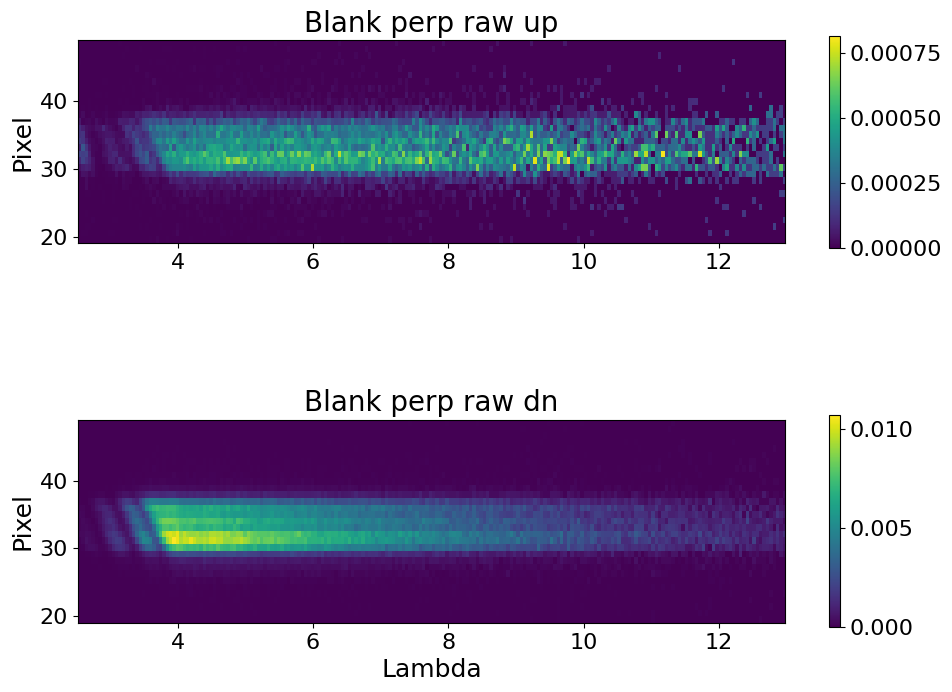

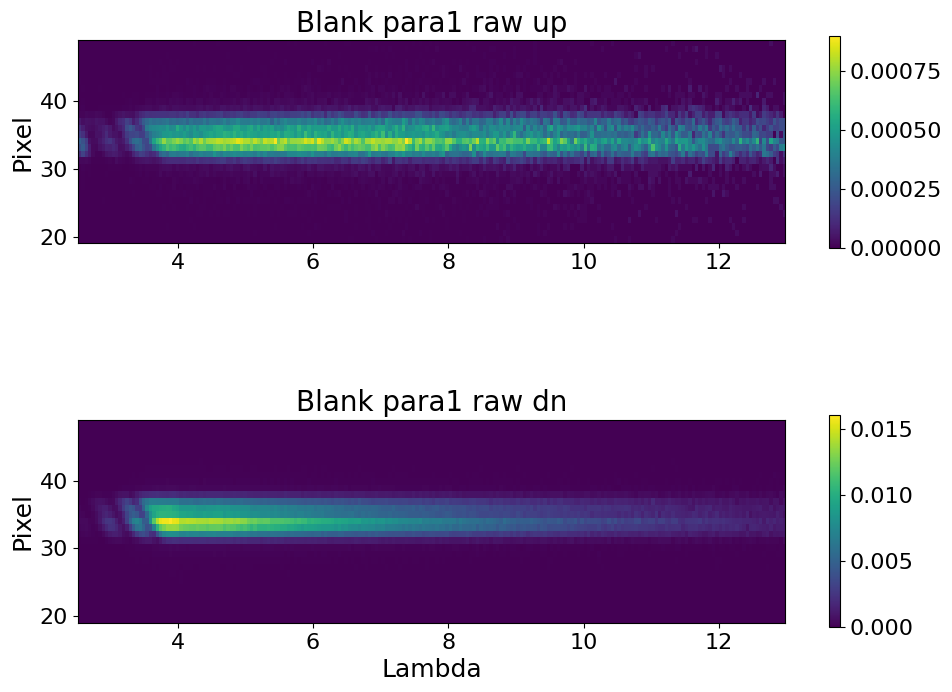

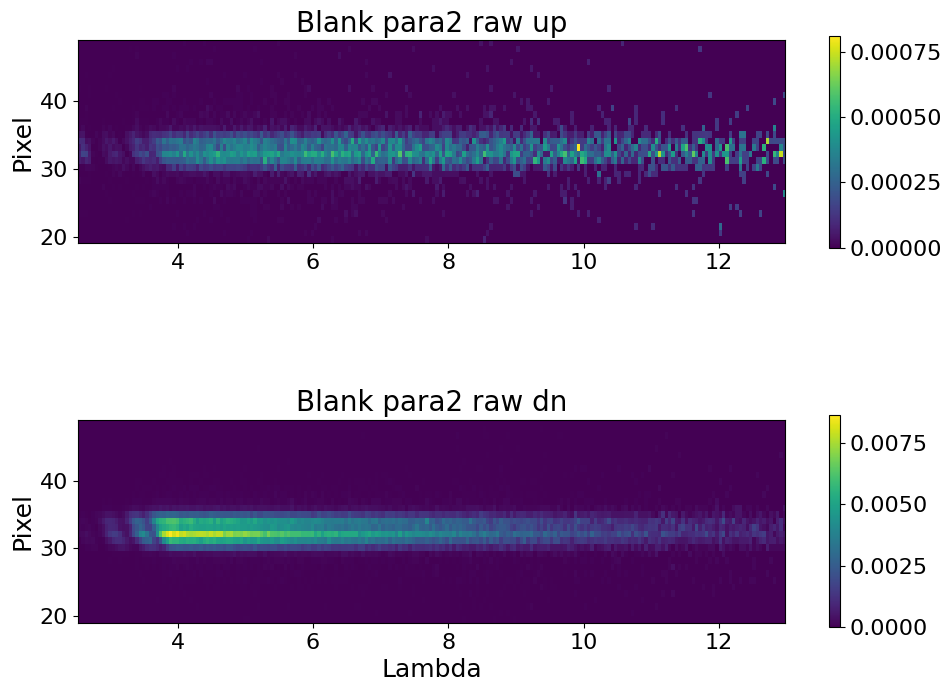

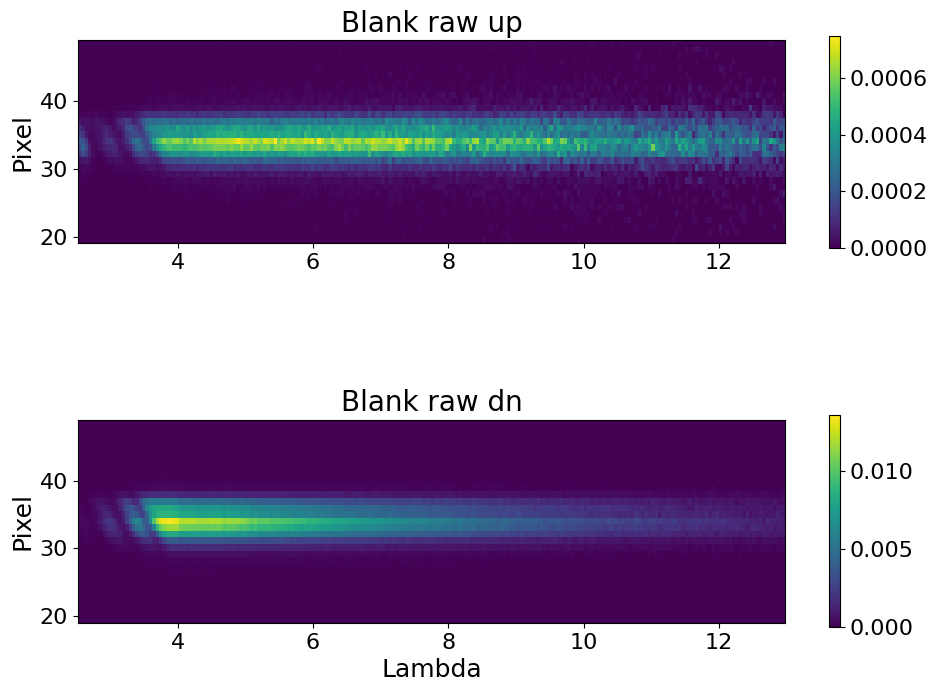

In [212]:
fig,axs = prepare_plot({'grid':False,'title':['Blank perp raw up','Blank perp raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b_perp,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b_perp,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank para1 raw up','Blank para1 raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b_para1,origin='lower',extent=(lam_b_para1[0],lam_b_para1[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b_para1,origin='lower',extent=(lam_b_para1[0],lam_b_para1[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank para2 raw up','Blank para2 raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b_para2,origin='lower',extent=(lam_b_para2[0],lam_b_para2[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b_para2,origin='lower',extent=(lam_b_para2[0],lam_b_para2[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank raw up','Blank raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b,origin='lower',extent=(lam_b[0],lam_b[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b,origin='lower',extent=(lam_b[0],lam_b[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

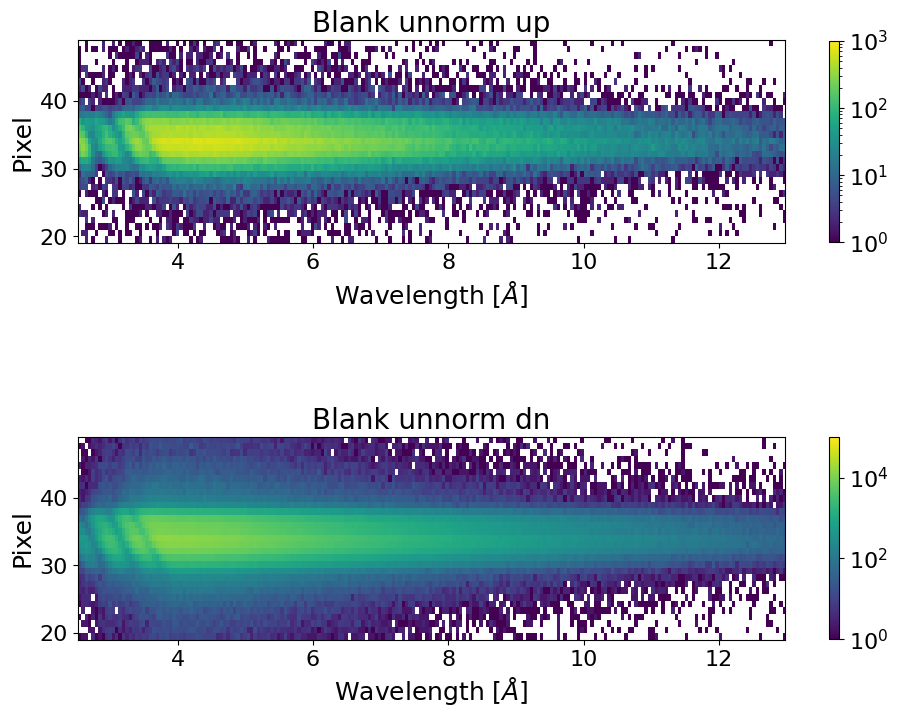

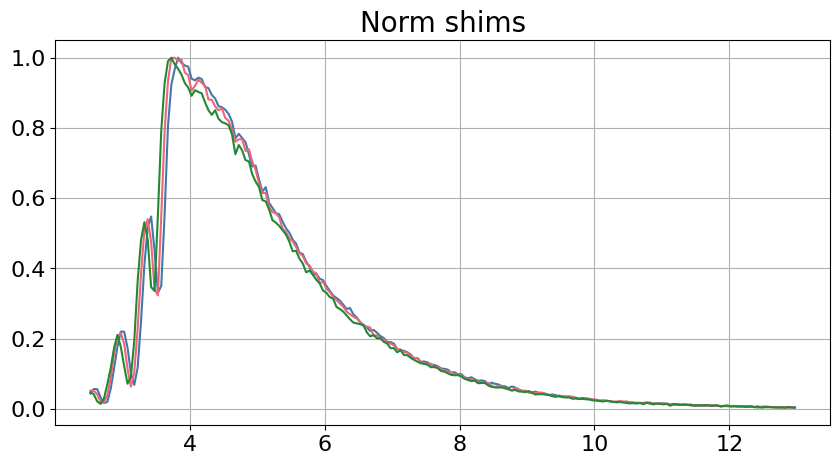

In [213]:
up_blank,up_errs_blank = unnormalize(up_b,eup_b)
dn_blank,dn_errs_blank = unnormalize(dn_b,edn_b)

blank_shim_all,blank_shim_all_errs,*_ = get_pol_shim(up_blank,dn_blank,up_errs_blank,dn_errs_blank,pname_b,trim=[33,34,35])

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_blank,origin='lower',extent=(lam_b[0],lam_b[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e3))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_blank,origin='lower',extent=(lam_b[0],lam_b[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Norm shims']})  #checking Q-correction
for p in blank_shim_all:
    axs[0].plot(lam_b,p/np.max(p))
plt.show()

##### Correction for Q:

These cells interpolate the data first to get the neutron counts as a function of momentum transfer Q, then perform a second interpolation to plot the data as a function of pixel and wavelength. The counting errors are interpolated in the same way.

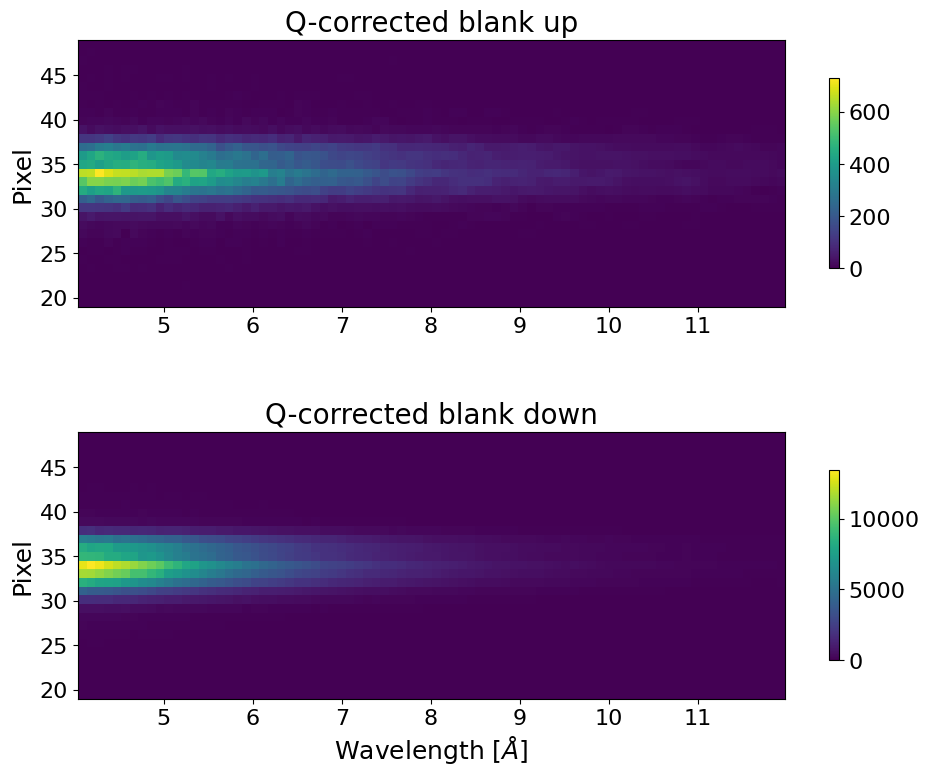

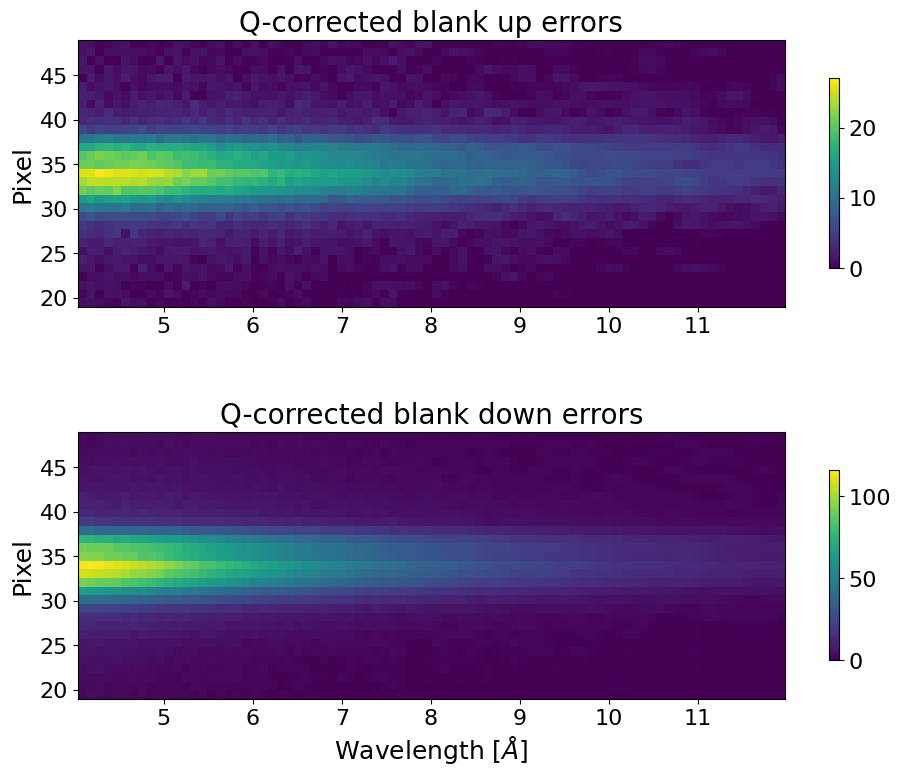

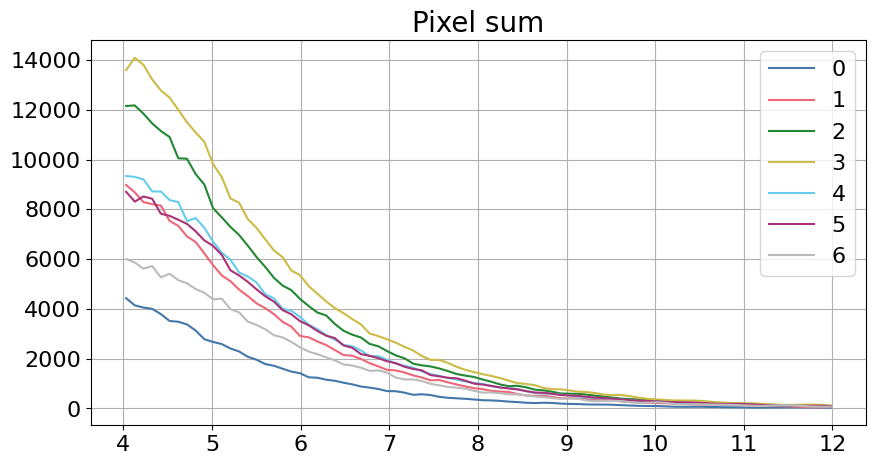

In [214]:
qlam_blank,qup_blank,qup_errs_blank = get_constant_Q(up_blank,up_errs_blank,lam_b,pixs,34,.35,q_bins=200)
_,qdn_blank,qdn_errs_blank = get_constant_Q(dn_blank,dn_errs_blank,lam_b,pixs,34,.35,q_bins=200)
blank_shim,blank_shim_errs,blank_pol,blank_pol_errs,blank_shim_std = get_pol_shim(qup_blank,qdn_blank,qup_errs_blank,qdn_errs_blank,pname_b,\
                                                                                  trim=np.arange(31,38))

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected blank up','Q-corrected blank down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected blank up errors','Q-corrected blank down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if False:
    axs[0].plot(qlam_blank,s1:=np.sum(qup_blank,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_blank,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_blank,s2:=np.sum(qdn_blank,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_blank,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_blank,sh:=s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_blank,sh,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if True:
    for indx,p in enumerate(blank_shim):
        axs[0].plot(qlam_blank,p,label=f'{indx}')
plt.legend()
plt.show()

##### Finding the center:

These plots show that that each of the blank data sets have a different center of mass. Also, the blank perp is much wider than the two blank para data sets (as expected).

All blank data summed 
Center pixel:
[up,down]: [34.17439 34.13386] -> 34
Pixels used:
[31 32 33 34 35 36 37] : 7 total.


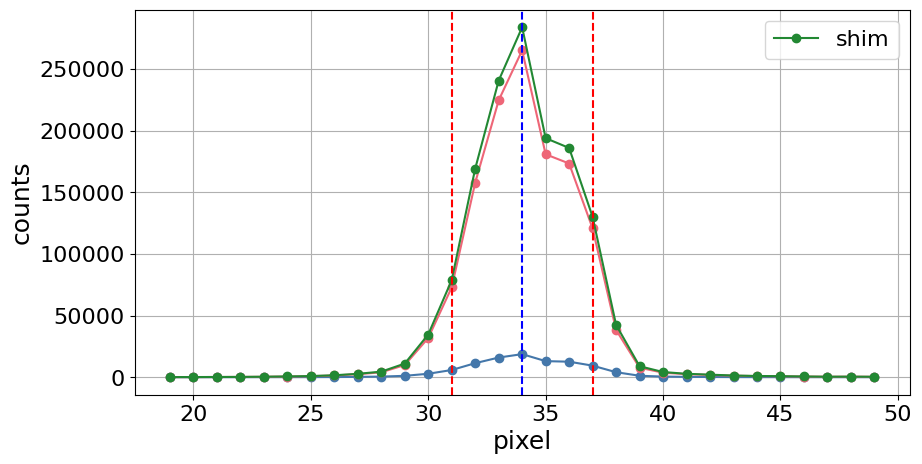

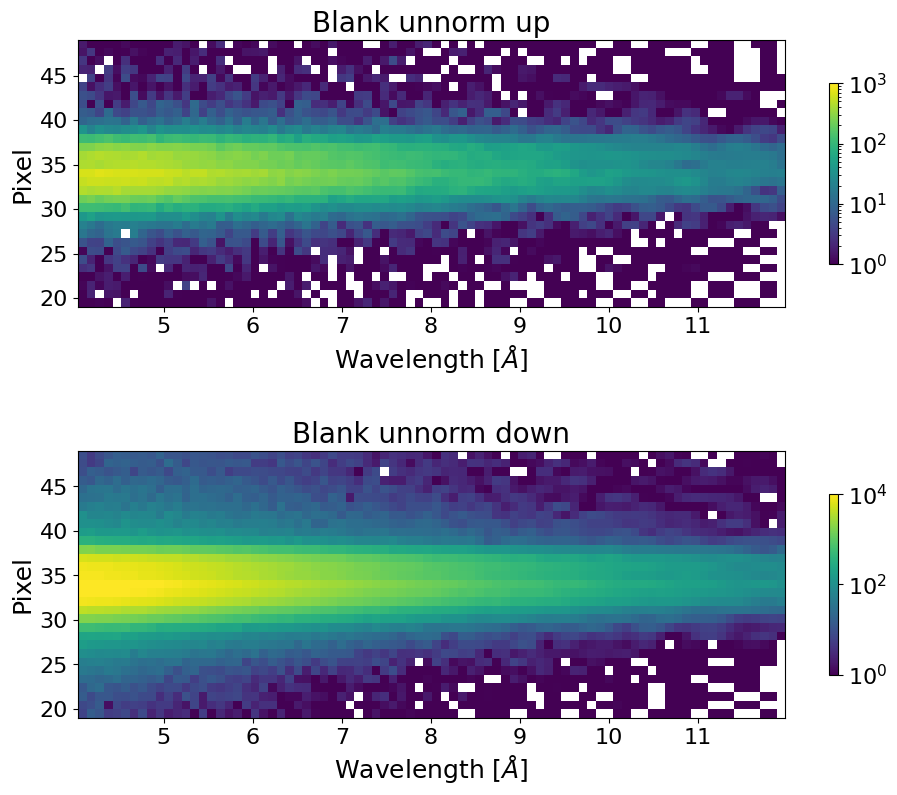

Center pixel:
[up,down]: [32.90059 32.99222] -> 33
Pixels used:
[30 31 32 33 34 35 36 37] : 8 total.


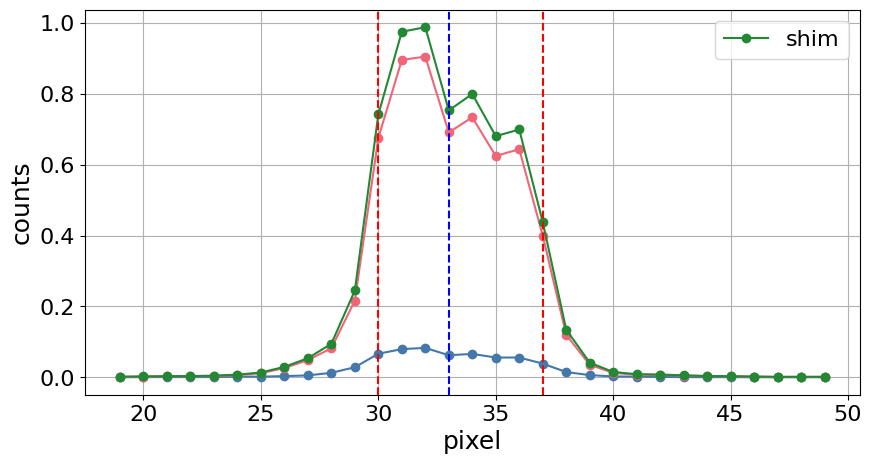

Center pixel:
[up,down]: [34.44843 34.35597] -> 34
Pixels used:
[32 33 34 35 36 37] : 6 total.


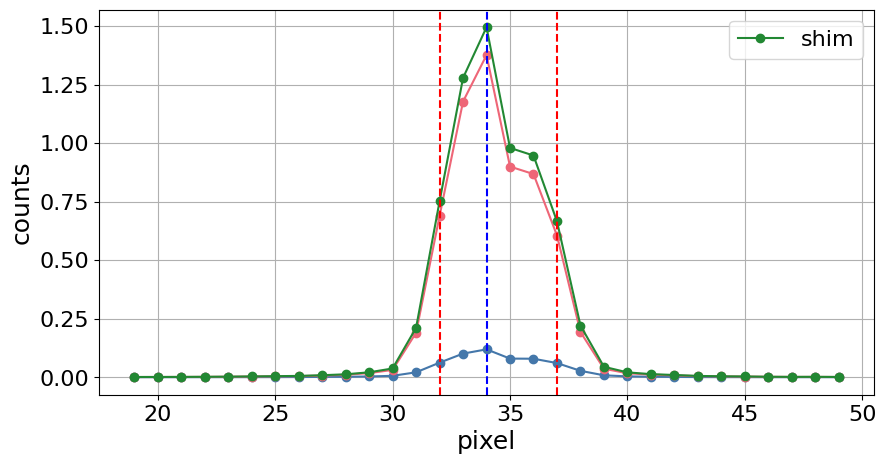

Center pixel:
[up,down]: [32.45712 32.53218] -> 32
Pixels used:
[30 31 32 33 34 35] : 6 total.


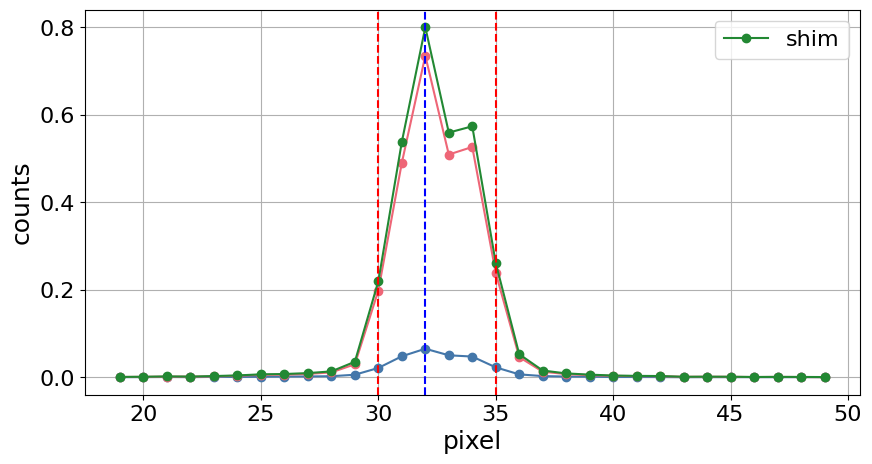

Center pixel:
[up,down]: [34.06986 34.03417] -> 34
Pixels used:
[31 32 33 34 35 36 37] : 7 total.


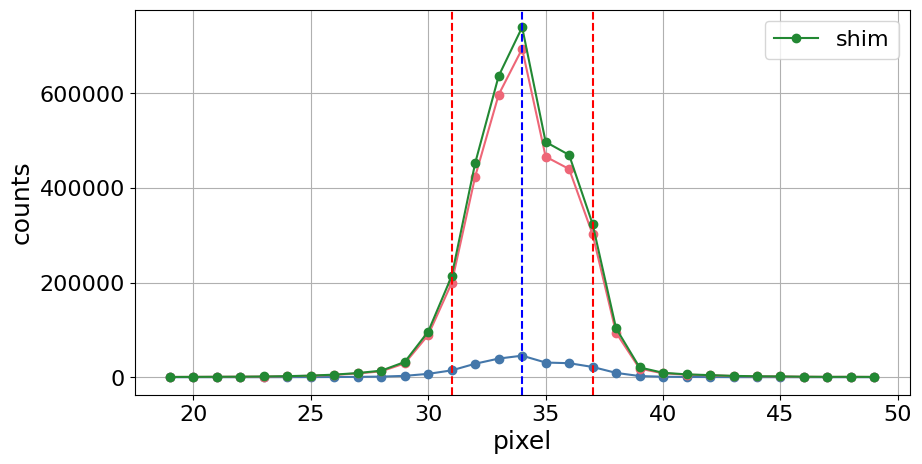

In [215]:
print('All blank data summed \n','='*80)
CENTER_PIXEL,PIXELS = get_center(qup_blank,qdn_blank,pname_b,threshold=.25)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e3))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

if True:
    print('='*80)  
    _ = get_center(up_b_perp,dn_b_perp,pname_b_perp)
    _ = get_center(up_b_para1,dn_b_para1,pname_b_para1)
    _ = get_center(up_b_para2,dn_b_para2,pname_b_para2)
    _ = get_center(up_blank,dn_blank,pname_b)  #not Q-corrected

##### After pixel trimming and q-correction:

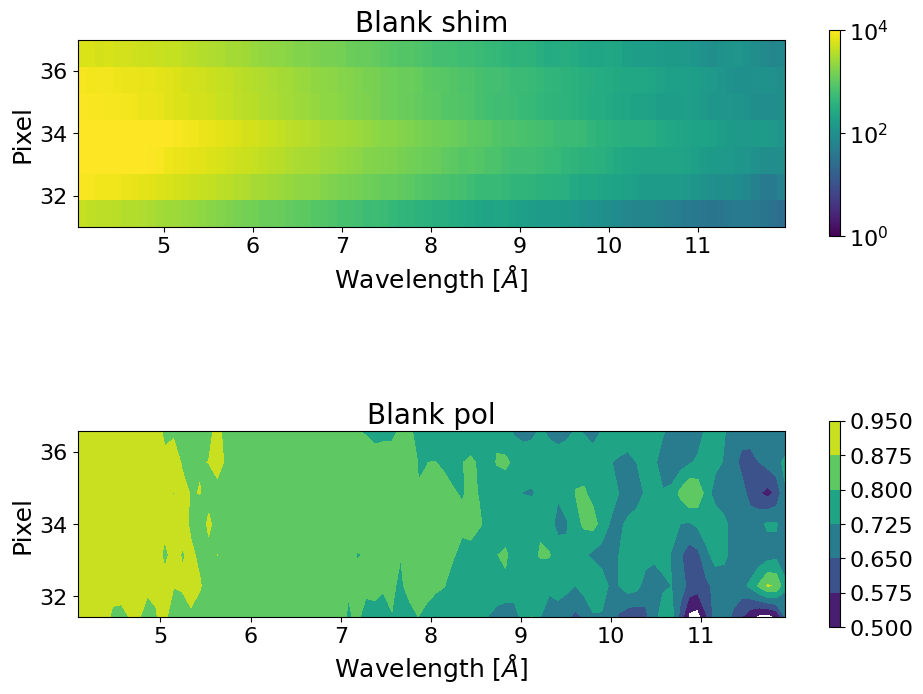

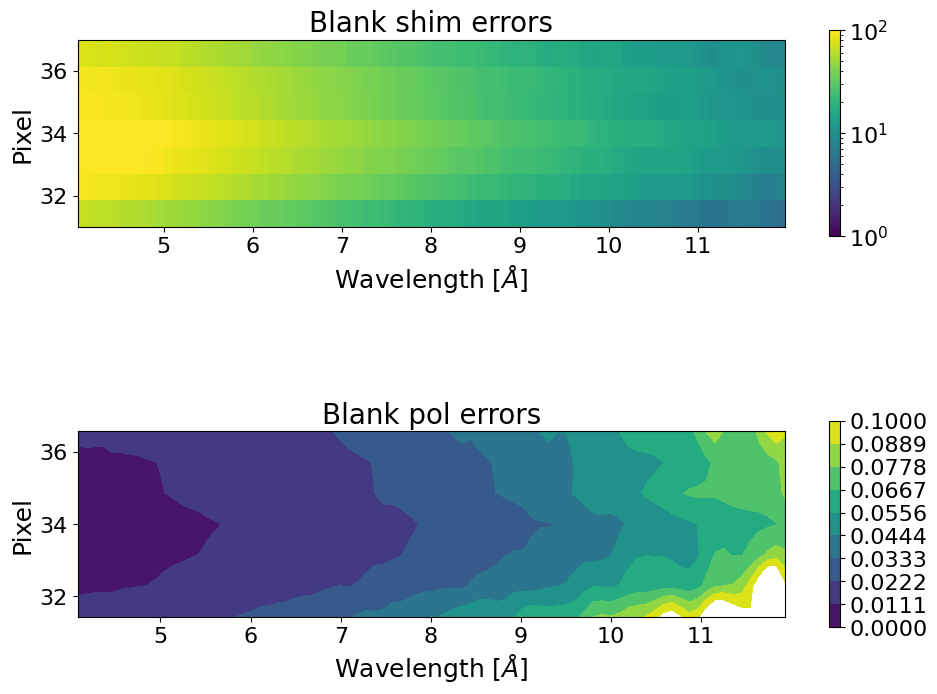

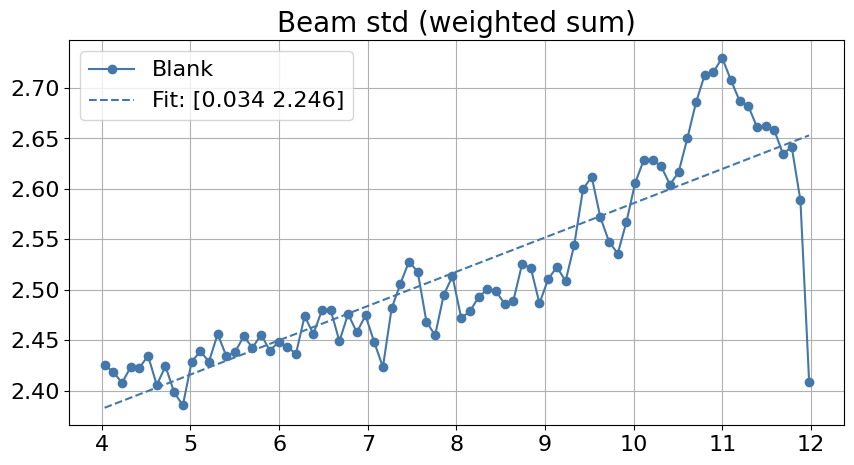

In [216]:
blank_shim,blank_shim_errs,blank_pol,blank_pol_errs,blank_shim_std = get_pol_shim(qup_blank,qdn_blank,qup_errs_blank,qdn_errs_blank,pname_b,trim=PIXELS)

fig,axs = prepare_plot({'grid':False,'title':['Blank shim','Blank pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(blank_shim,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(blank_pol,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(.5,.95,7)
    CS = axs[1].contourf(blank_pol,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(blank_pol,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank shim errors','Blank pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(blank_shim_errs,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(blank_pol_errs,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.1,10)
    CS = axs[1].contourf(blank_pol_errs,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(blank_pol,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

co_std_indx = 0  #depends on wavelength band and critical angle
fig,axs = prepare_plot({'title':['Beam std (weighted sum)']})
axs[0].plot(qlam_blank[co_std_indx:],blank_shim_std[co_std_indx:],'o-',label='Blank',color=f'C0')
blank_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[co_std_indx:],blank_shim_std[co_std_indx:])
axs[0].plot(qlam_blank[co_std_indx:],f(qlam_blank[co_std_indx:],*blank_parms),'--',label=f'Fit: {np.round(blank_parms,3)}',color=f'C0')
plt.legend()
plt.show()

##### Fitting $P_0$ and $S_0$ from the blank sample:

* Using Chebyshev polynomials to reduce Runge's phenomenon. Each pixel is fit independently because there is a large difference in polarization between each pixel.
* It looks like the polarization is too poor for pixel 31. Probably the shim counts from that pixel is worth keeping, however.
* It was suprisingly easy to fit the shim above the critical edge, the range 5-10 Angstroms was well fit by $\lambda^{-2/3}$

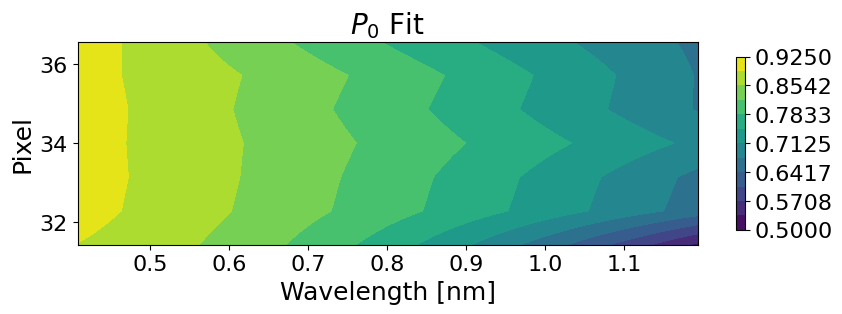

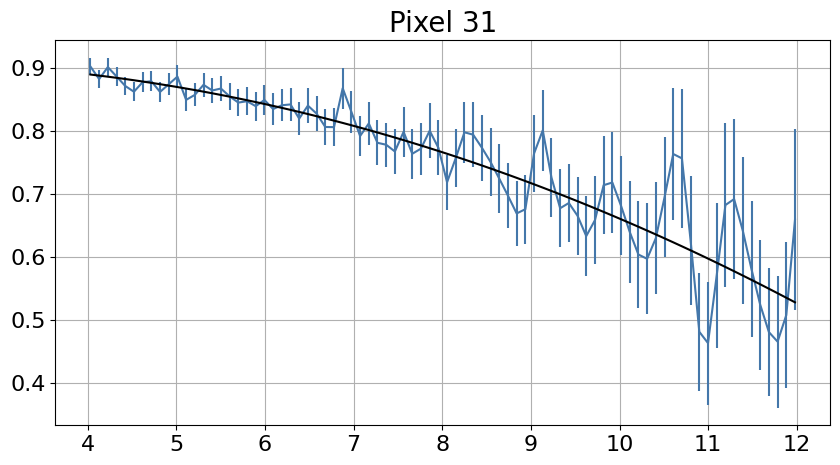

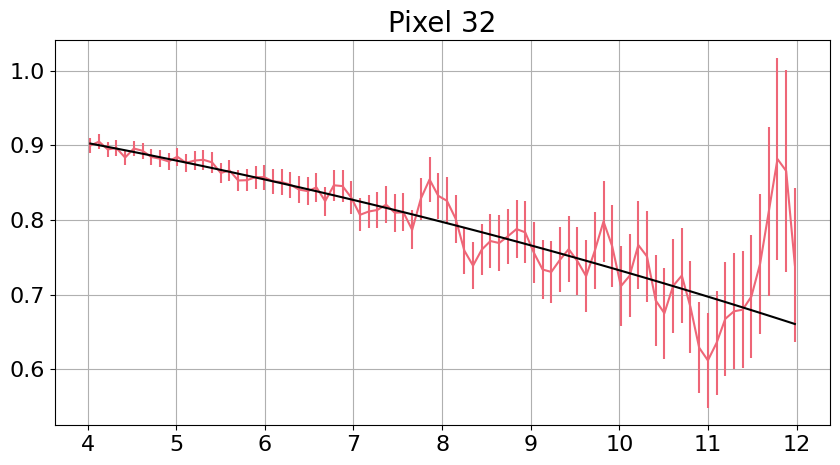

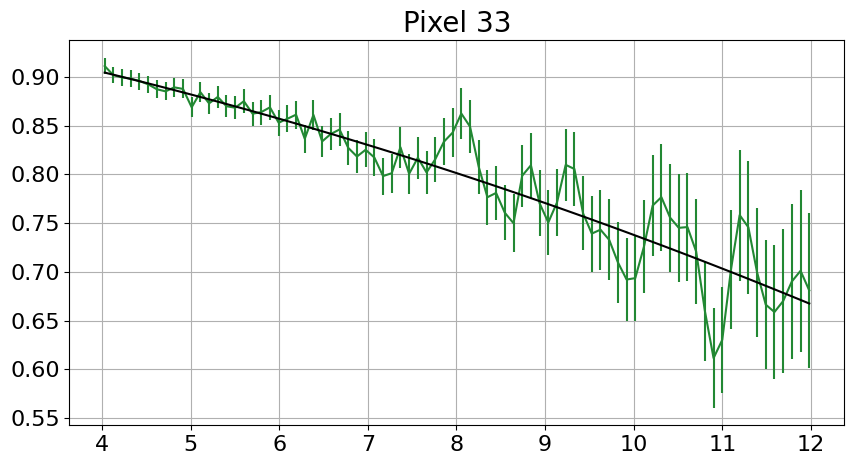

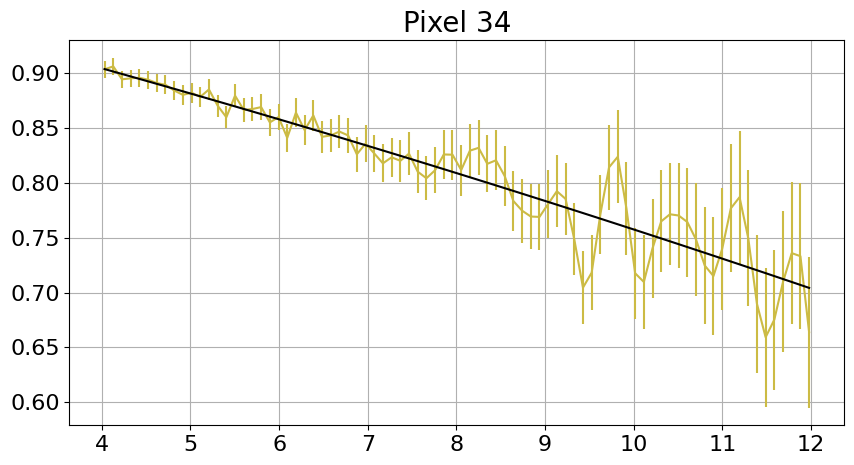

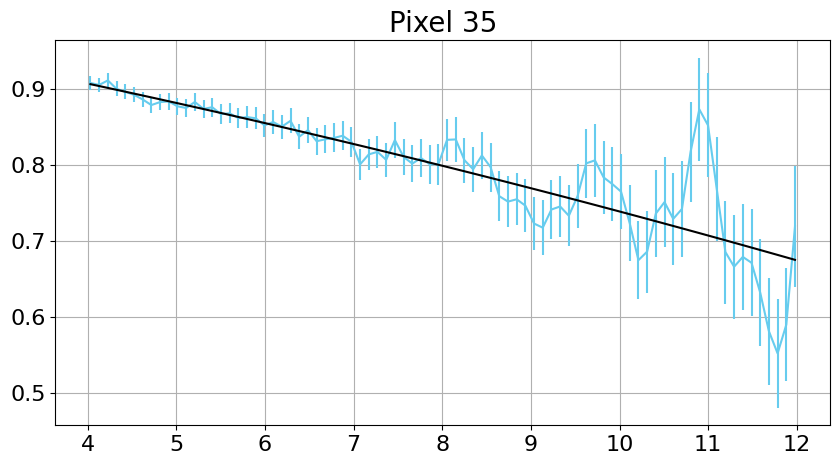

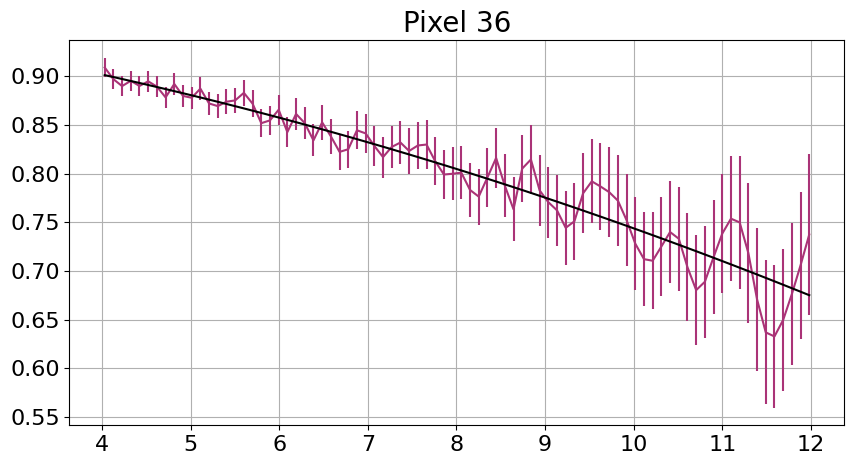

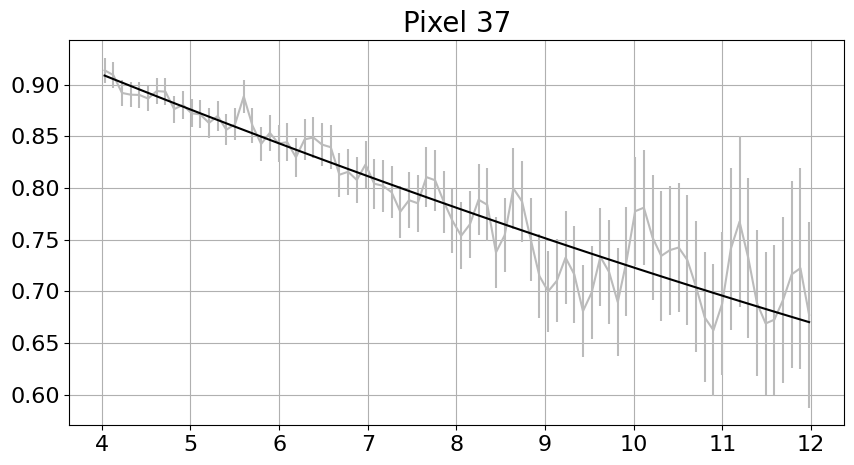

In [254]:
P0 = do_fit(qlam_blank,blank_pol,err=blank_pol_errs)

fig,axs = prepare_plot({'grid':False,'title':[r'$P_0$ Fit'],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']})
cfill_levels = np.linspace(.5,.925,13)
CS = axs[0].contourf(P0,origin='lower',levels=cfill_levels,extent=(.1*qlam_blank[0],.1*qlam_blank[-1],PIXELS[0],PIXELS[-1]))
axs[0].set_aspect(.05)
plt.colorbar(CS,shrink=.45)
plt.show()

if False:
    fig,axs = prepare_plot({'title':[f'P0 Fit']})
    for indx,(pixel,fit,data,error) in enumerate(zip(PIXELS,P0,blank_pol,blank_pol_errs)):
        if False: axs[0].plot(qlam_blank,data,color=f'C{indx}')
        if False: axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        if True: axs[0].plot(qlam_blank,fit,label=f'{pixel}',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
if True:
    for indx,(pixel,fit,data,error) in enumerate(zip(PIXELS,P0,blank_pol,blank_pol_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        axs[0].plot(qlam_blank,fit,label=f'{indx}',color='black')
        plt.show()

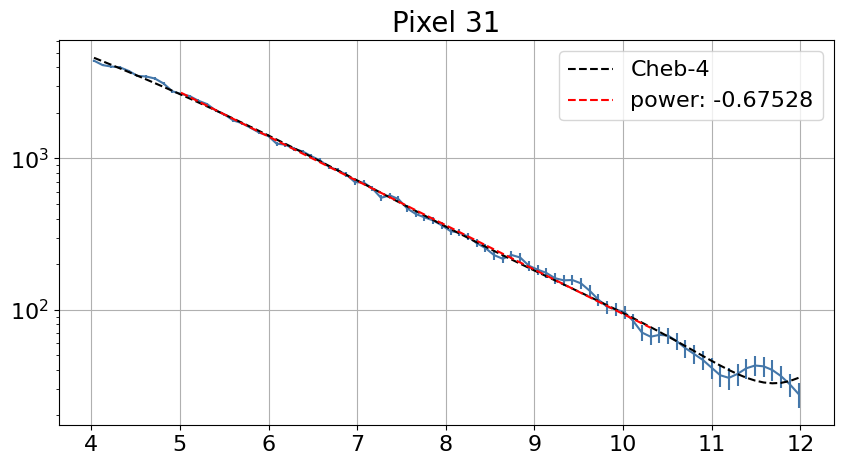

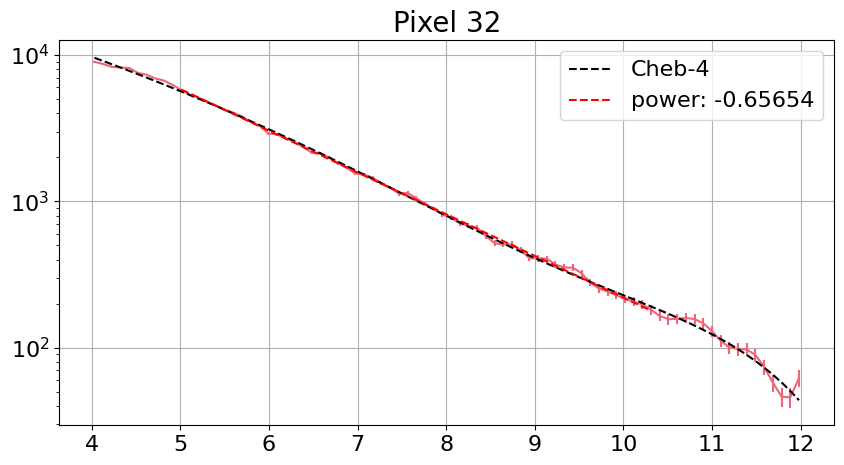

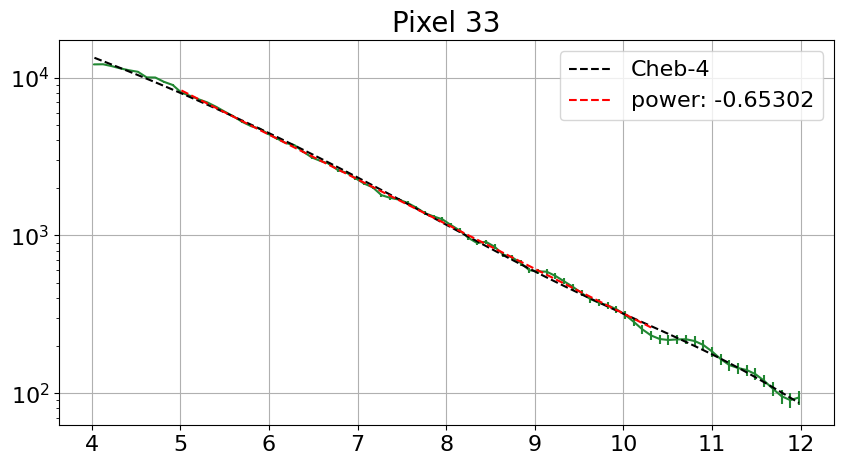

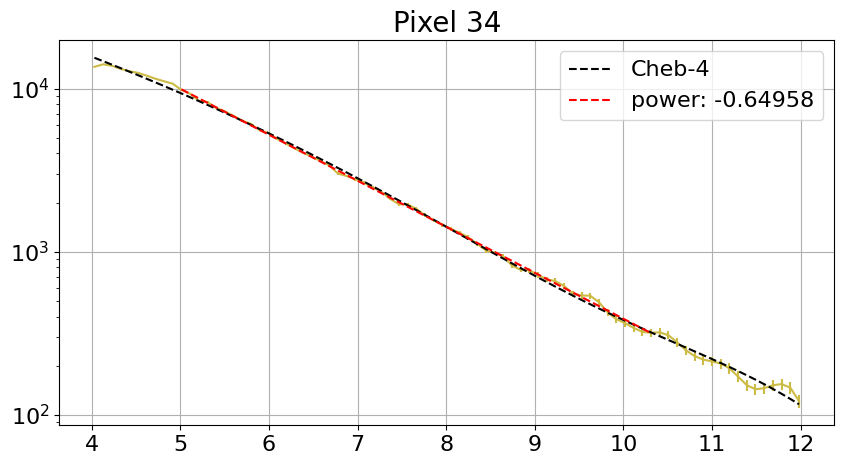

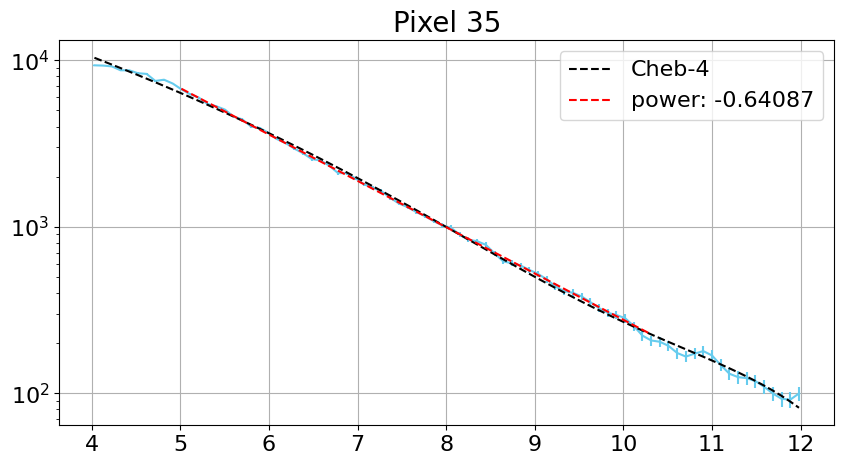

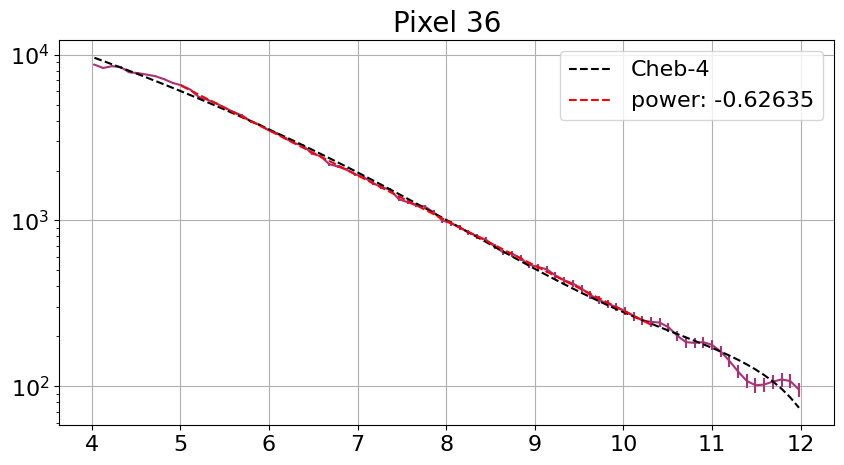

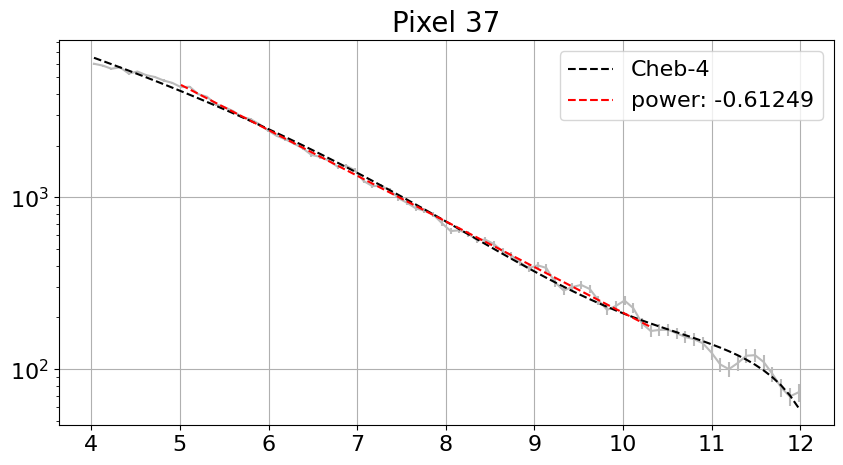

Slopes: [-0.67528036 -0.65654474 -0.65301961 -0.64958064 -0.6408659  -0.62634554
 -0.6124886 ], av=-0.6448750570115467
Counts at 4 A: [ 80327.36271563 155994.58531338 219209.99234216 256718.03711229
 167667.38458463 149860.88089836  97369.71943924]


In [218]:
S0 = do_fit(qlam_blank[co_std_indx:],blank_shim[:,co_std_indx:],err=blank_shim_errs[:,co_std_indx:],deg=[0,1,2,3,4])

if False:
    fig,axs = prepare_plot({'grid':False,'title':[fr'S0 Fit $(\log)$, Cheb'],\
                            'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel']})
    if False:
        im1 = axs[0].imshow(S0,origin='lower',extent=(qlam_blank[co_std_indx],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect)
        plt.colorbar(im1,shrink=.5)
    if True:
        cfill_levels = np.logspace(2,4.2,11)
        nrm = plt.cm.colors.LogNorm(vmin=10**2,vmax=10**4.2)
        #cfill_levels = np.linspace(10,1.5e4,11)
        CS = axs[0].contourf(S0,origin='lower',levels=cfill_levels,extent=(qlam_blank[co_std_indx],qlam_blank[-1],PIXELS[0],PIXELS[-1]),norm=nrm)
        cbar = plt.colorbar(CS,shrink=.5,ticks=cfill_levels[::2],norm=nrm)
        cbar.ax.set_yticklabels(np.round(np.linspace(2,4.2,11),1)[::2])
        axs[0].set_aspect(fine_aspect)
    plt.show()

if False:
    fig,axs = prepare_plot({'title':[fr'S0 Fit, Cheb']})
    for indx,(pixel,fit,data,error) in enumerate(zip(PIXELS,S0,blank_shim[:,co_std_indx:],blank_shim_errs[:,co_std_indx:])):
        axs[0].plot(qlam_blank[co_std_indx:],data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank[co_std_indx:],data,yerr=error,linestyle='',color=f'C{indx}')
        axs[0].plot(qlam_blank[co_std_indx:],fit,'--',label=f'{pixel}',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

fr = [10,-17]  #range restriction for fit
if True:
    parms = []
    for indx,(pixel,fit,data,error) in enumerate(zip(PIXELS,S0,blank_shim,blank_shim_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        axs[0].plot(qlam_blank[co_std_indx:],fit,'--',label=f'Cheb-4',color='black')
        
        parms.append(curve_fit(log_fit:=lambda x,a,b: a*(x - 4) + b,qlam_blank[fr[0]:fr[-1]],np.log(data[fr[0]:fr[-1]]),\
                               sigma=(error/data)[fr[0]:fr[-1]])[0])
        if True:
            axs[0].plot(qlam_blank[fr[0]:fr[-1]],np.exp(log_fit(qlam_blank[fr[0]:fr[-1]],*parms[-1])),'--',label=f'power: {round(parms[-1][0],5)}',color='red')
            axs[0].set_yscale('log')
        plt.legend()
        plt.show()
    slope,offset = np.array(parms).T
    offset = np.exp(offset-4*slope)

print(f'Slopes: {slope}, av={(av_slop:=np.mean(slope))}')
print(f'Counts at 4 A: {offset}')


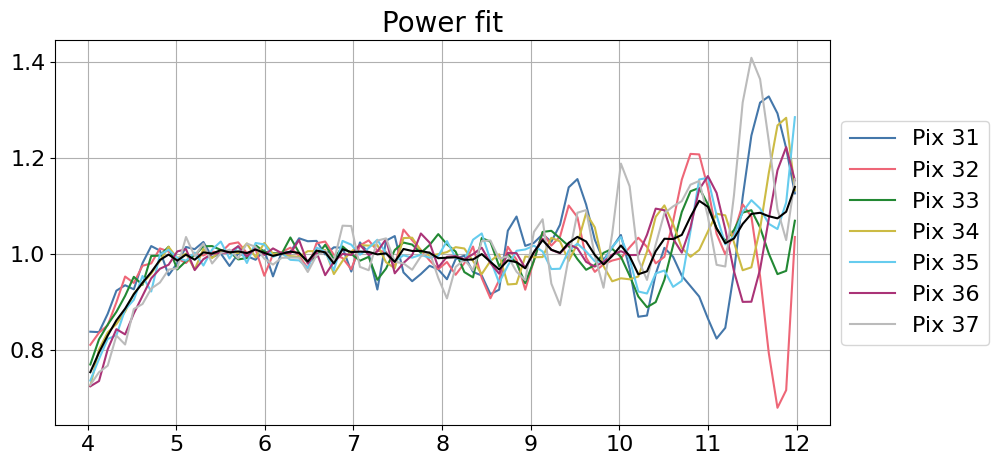

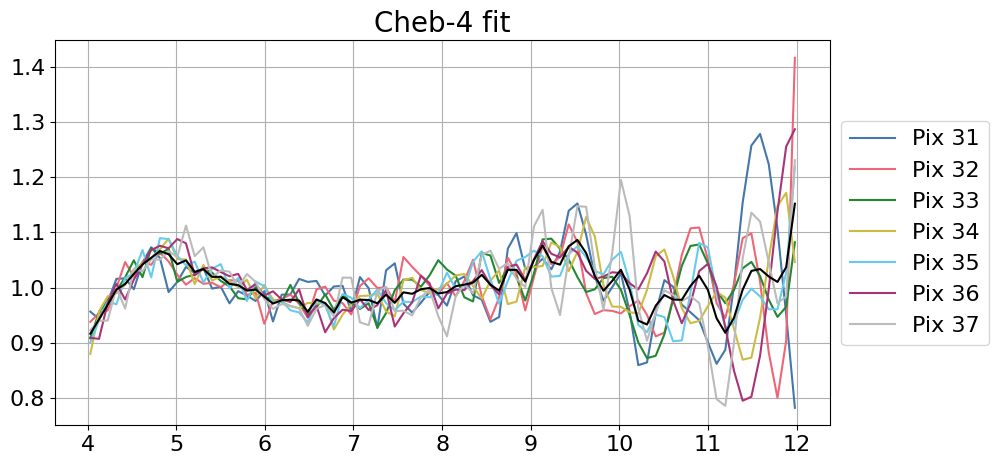

In [219]:
if False:
    fig,axs = prepare_plot({'grid':False,'title':['Blank shim','Blank pol'],\
                            'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel']})
    im1 = axs[0].imshow(blank_shim[:,co_std_indx:]/S0,origin='lower',\
                        extent=(qlam_blank[co_std_indx],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect)
    plt.colorbar(im1,shrink=.5)
    plt.show()

fig,axs = prepare_plot({'title':['Power fit']})
for indx,(p,prms) in enumerate(zip(blank_shim,parms)):
    axs[0].plot(qlam_blank,p/np.exp(log_fit(qlam_blank,*prms)),label=f'Pix {PIXELS[indx]}')
axs[0].plot(qlam_blank,np.mean(blank_shim,axis=0)/np.mean([np.exp(log_fit(qlam_blank,*p)) for p in parms],axis=0),color='black')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig,axs = prepare_plot({'title':['Cheb-4 fit']})
for indx,p in enumerate(blank_shim):
    axs[0].plot(qlam_blank[co_std_indx:],p[co_std_indx:]/S0[indx],label=f'Pix {PIXELS[indx]}')
axs[0].plot(qlam_blank[co_std_indx:],np.mean(blank_shim[:,co_std_indx:]/S0,axis=0),color='black')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

S0_pwr = np.array([np.exp(log_fit(qlam_blank,*prms)) for p,prms in zip(blank_shim,parms)])

### Sample magnetization perpendicular to the guide field (perp):

***

The shim intensity shows 2 distinct peaks. Technically, the beam has the same center, but I'm missing quite a few counts from pixel 8, so the P0 normalization needs to additionally include at least that pixel.

General cell progression:
1. Load data and perform rough trimming
2. Do Q-correction
3. Trim beam to center determined by the blank sample
4. Get normalized shim and polarization
5. Final pixel selection and saving to file

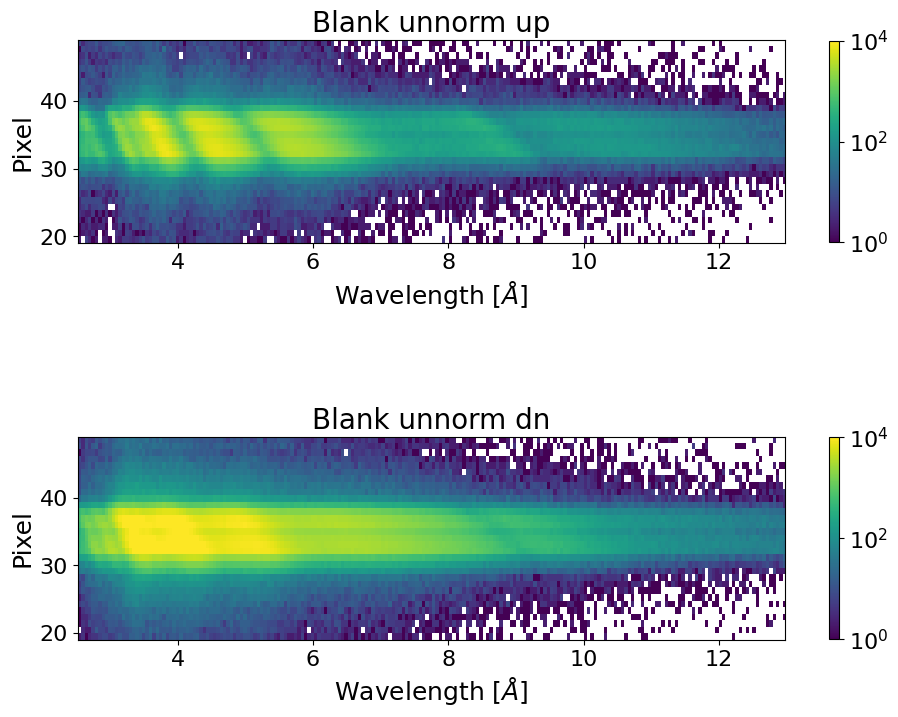

In [255]:
(lam_perp,up_perp,eup_perp),pname_perp = load_data_2D(r"perp_p35\\up.txt",pix_trim=pixs)
(_,dn_perp,edn_perp),_ = load_data_2D(r"perp_p35\\dn.txt",pix_trim=pixs)
lam_perp = lam_perp[0]

up_perp,up_errs_perp = unnormalize(up_perp,eup_perp)
dn_perp,dn_errs_perp = unnormalize(dn_perp,edn_perp)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_perp,origin='lower',extent=(lam_perp[0],lam_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_perp,origin='lower',extent=(lam_perp[0],lam_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

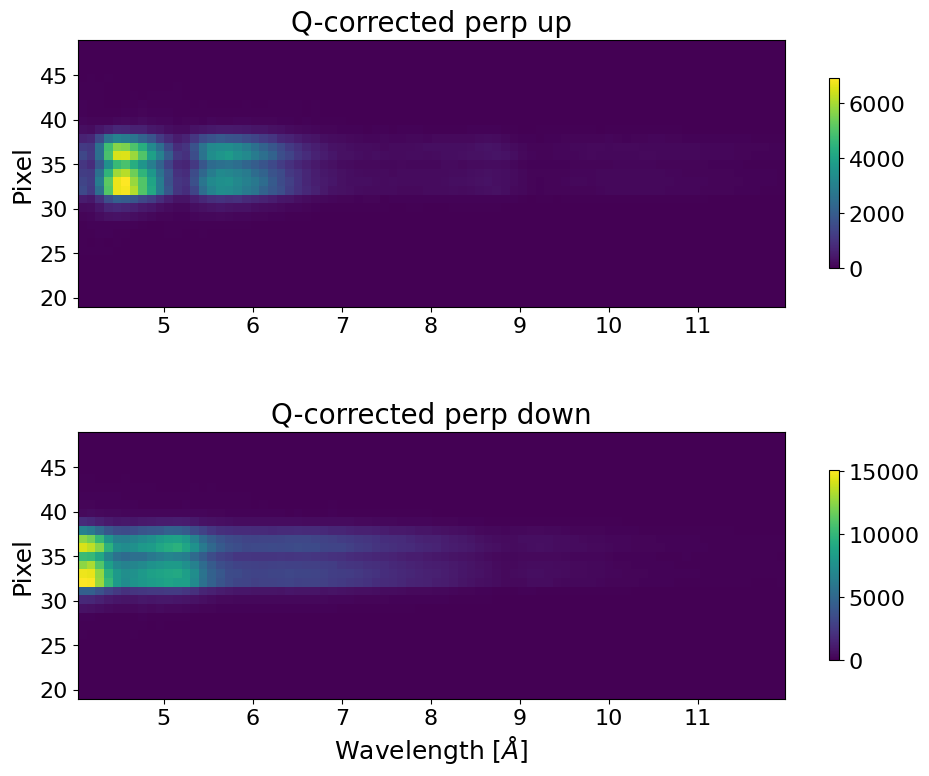

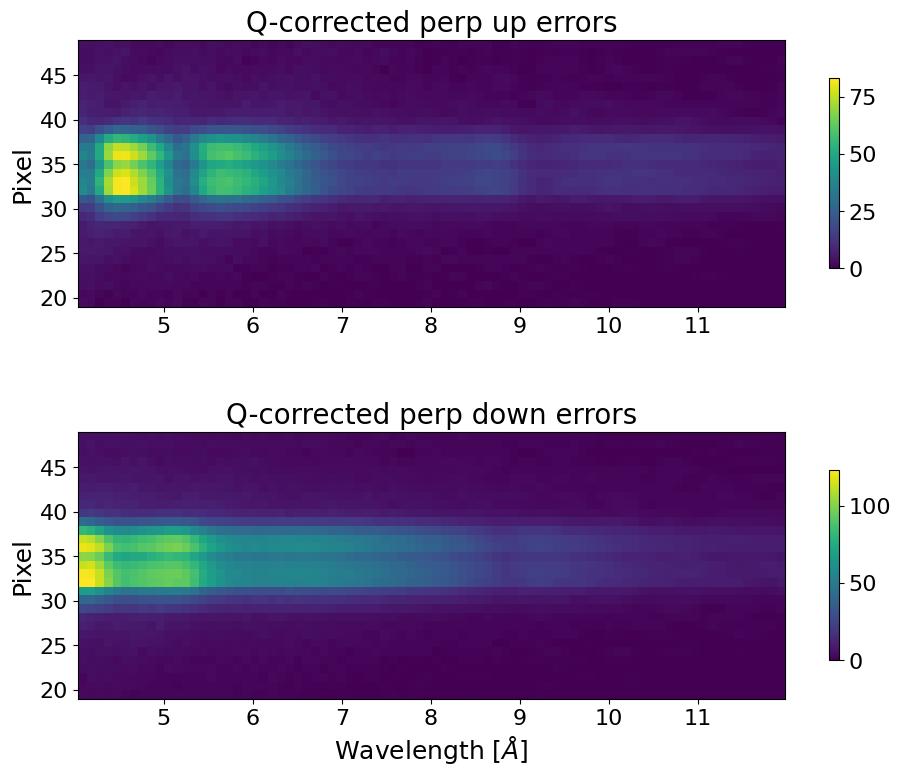

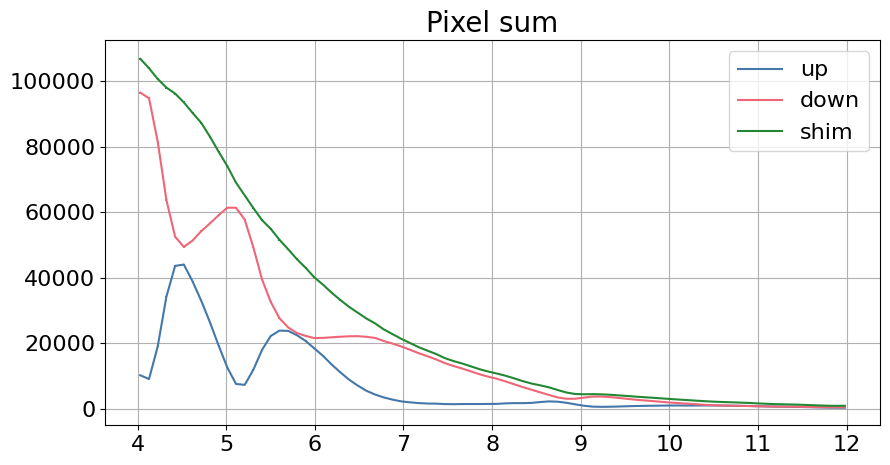

In [256]:
qlam_perp,qup_perp,qup_errs_perp = get_constant_Q(up_perp,up_errs_perp,lam_b,pixs,34,.35)
_,qdn_perp,qdn_errs_perp = get_constant_Q(dn_perp,dn_errs_perp,lam_b,pixs,34,.35)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected perp up','Q-corrected perp down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected perp up errors','Q-corrected perp down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_perp,s1:=np.sum(qup_perp,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_perp,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_perp,s2:=np.sum(qdn_perp,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_perp,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_perp,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_perp,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_perp[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

Center pixel:
[up,down]: [34.6371  34.64295] -> 35
Pixels used:
[31 32 33 34 35 36 37 38] : 8 total.


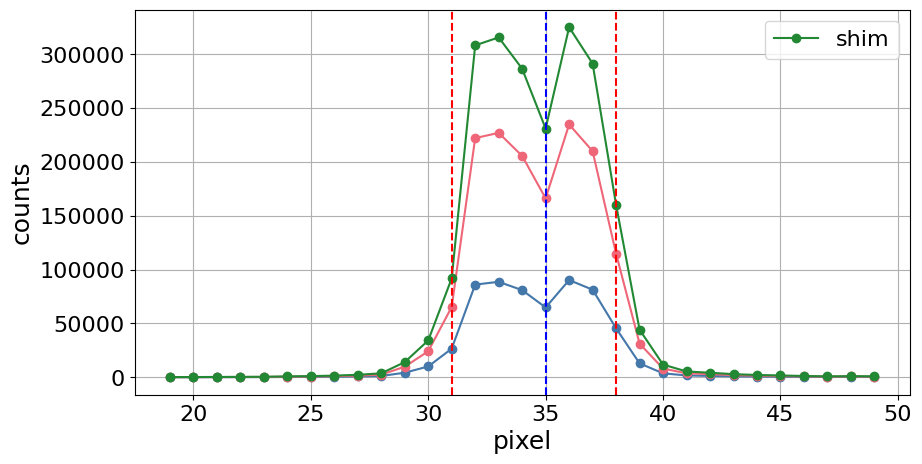

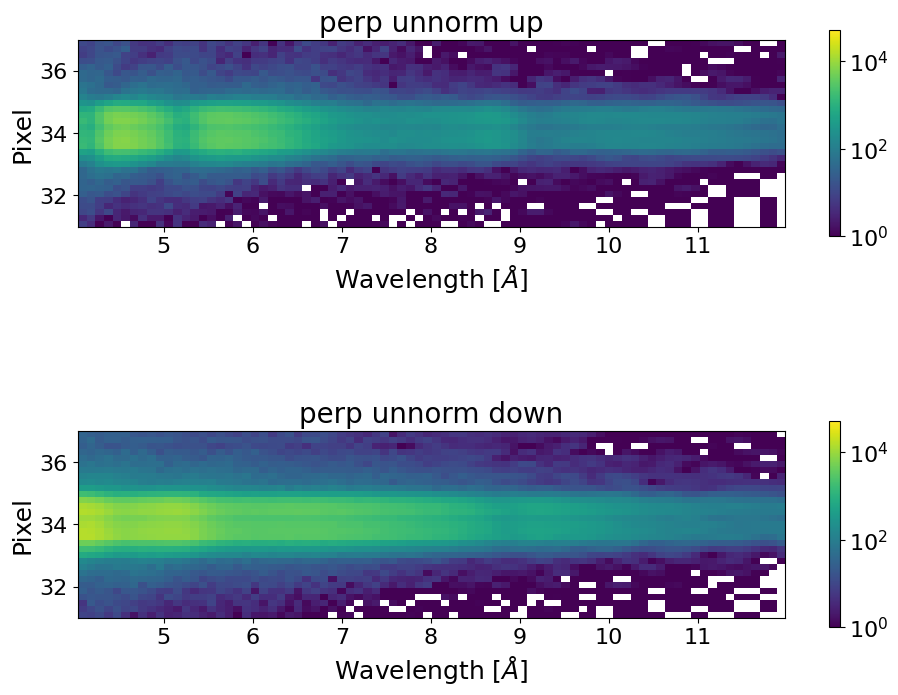

In [257]:
_ = get_center(qup_perp,qdn_perp,pname_perp)

fig,axs = prepare_plot({'grid':False,'title':['perp unnorm up','perp unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

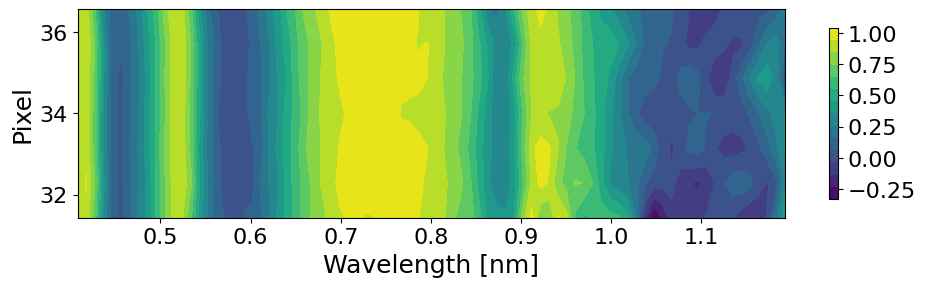

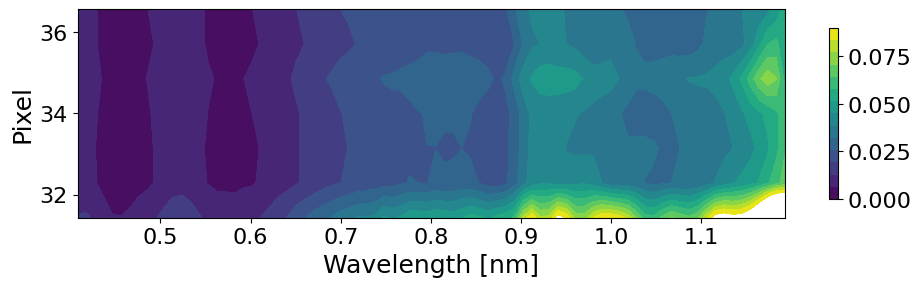

In [346]:
perp_shim,perp_shim_errs,perp_pol,perp_pol_errs,perp_shim_std = get_pol_shim(qup_perp,qdn_perp,qup_errs_perp,qdn_errs_perp,pname_perp,trim=PIXELS)
perp_pol = perp_pol/P0  #normalizing to blank sample
perp_pol_errs = perp_pol_errs/P0

if False:
    fig,axs = prepare_plot({'grid':False,'title':['perp shim'],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']})
    im1 = axs[0].imshow(perp_shim,origin='lower',extent=(.1*qlam_perp[0],.1*qlam_perp[-1],PIXELS[0],PIXELS[-1]),\
                        aspect=.05,norm=LogNorm(vmin=1, vmax=1e5))
    plt.colorbar(im1,shrink=.3)
    plt.tight_layout()
    plt.show()

if True:
    fig,axs = prepare_plot({'grid':False,'title':[''],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']}) #[r'$P_y^{\perp} / P_0$']
    cfill_levels = np.linspace(np.min(perp_pol),np.max(perp_pol),15)
    CS = axs[0].contourf(perp_pol,origin='lower',levels=cfill_levels,extent=(.1*qlam_perp[0],.1*qlam_perp[-1],PIXELS[0],PIXELS[-1]))
    axs[0].set_aspect(.045)
    plt.colorbar(CS,shrink=.4,ticks=[-.25,0,.25,.5,.75,1])
    plt.tight_layout()
    plt.show()

if False:
    fig,axs = prepare_plot({'grid':False,'title':['perp shim errors'],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']})
    im1 = axs[0].imshow(perp_shim_errs,origin='lower',extent=(.1*qlam_perp[0],.1*qlam_perp[-1],PIXELS[0],PIXELS[-1]),\
                        aspect=.05,norm=LogNorm(vmin=1, vmax=1e2))
    plt.colorbar(im1,shrink=.3)
    plt.tight_layout()
    plt.show()

if True:
    fig,axs = prepare_plot({'grid':False,'title':[r''],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']})
    cfill_levels = np.linspace(0,.09,15)
    CS = axs[0].contourf(perp_pol_errs,origin='lower',levels=cfill_levels,extent=(.1*qlam_perp[0],.1*qlam_perp[-1],PIXELS[0],PIXELS[-1]))
    axs[0].set_aspect(.045)
    #plt.colorbar(CS,shrink=.4,ticks=[0,.025,.05,.075],format=mticker.FixedFormatter(['0.0%','2.5%','5.0%','7.5%']))
    plt.colorbar(CS,shrink=.4,ticks=[0,.025,.05,.075])
    plt.tight_layout()
    plt.show()

if False:
    co_std_indx = 0
    fig,axs = prepare_plot({'title':['Beam std (weighted sum)']})
    axs[0].plot(qlam_perp,perp_shim_std,'o-',label='perp',color=f'C0')
    perp_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_perp[co_std_indx:],perp_shim_std[co_std_indx:])
    axs[0].plot(qlam_perp[co_std_indx:],f(qlam_perp[co_std_indx:],*perp_parms),'--',label=f'Fit: {np.round(perp_parms,3)}',color=f'C0')
    axs[0].plot(qlam_blank,blank_shim_std,'o-',label=f'blank',color=f'C1')
    axs[0].plot(qlam_blank[co_std_indx:],f(qlam_blank[co_std_indx:],*blank_parms),'--',label=f'Fit: {np.round(blank_parms,3)}',color=f'C1')
    plt.legend()
    plt.show()

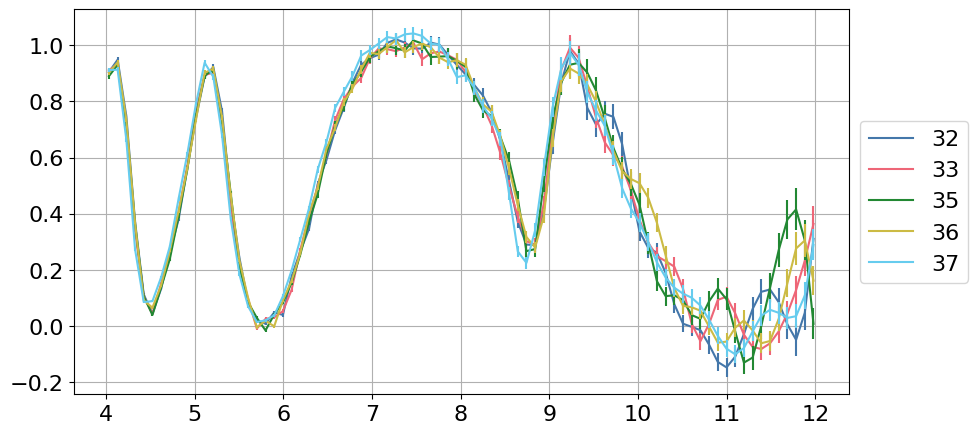

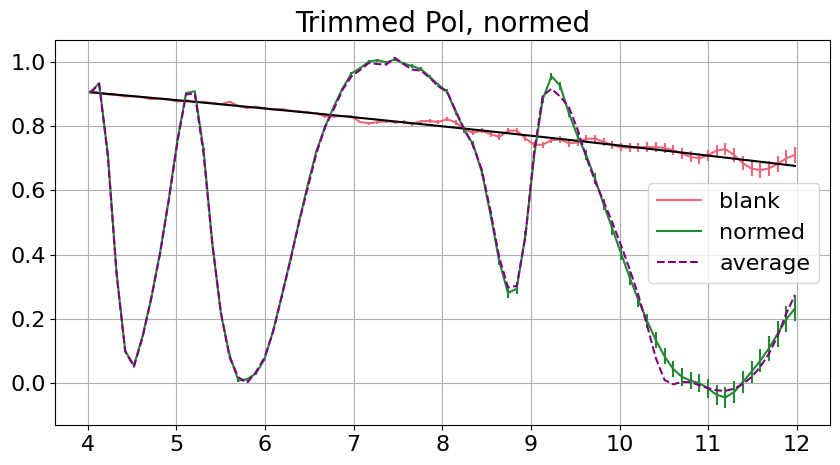

In [349]:
trim2 = np.array([1,2] + [4,5,6])
#trim2 = np.array([2] + [4,5,6])  #cutting out pixel 34
rt2 = np.array([p in PIXELS[trim2] for p in pixs])

if True:
    fig,axs = prepare_plot()
    for indx,(pixel,data,error) in enumerate(zip(PIXELS[trim2],perp_pol[trim2],perp_pol_errs[trim2])):
        axs[0].plot(qlam_perp,data,color=f'C{indx}',label=f'{pixel}')
        axs[0].errorbar(qlam_perp,data,yerr=error,linestyle='',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if False:
    for indx,(pixel,data,error) in enumerate(zip(PIXELS[trim2],perp_pol[trim2],perp_pol_errs[trim2])):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        plt.show()

perp_rb,perp_err_rb = get_pol_rb(qup_perp,qdn_perp,rt2)
blank_rb,blank_err_rb = get_pol_rb(qup_blank,qdn_blank,rt2)
P0_rb = do_fit(qlam_blank,[blank_rb],err=[blank_err_rb])[0]
perp_rb_norm = perp_rb/P0_rb
perp_err_rb_norm = perp_err_rb/P0_rb

_ = save_array([qlam_blank,perp_rb_norm,perp_err_rb_norm],name='perp_p35_pol.txt',\
               names=['Wavelength','Pol','Error'],check=False)

fig,axs = prepare_plot({'title':['Trimmed Pol, normed']})
if True:
    #axs[0].plot(qlam_blank,perp_rb,color=f'C0')
    #axs[0].errorbar(qlam_blank,perp_rb,yerr=perp_err_rb,linestyle='',color=f'C0')
    axs[0].plot(qlam_blank,blank_rb,label='blank',color=f'C1')
    axs[0].errorbar(qlam_blank,blank_rb,yerr=blank_err_rb,linestyle='',color=f'C1')
    axs[0].plot(qlam_blank,P0_rb,color='black')
axs[0].plot(qlam_blank,perp_rb_norm,label='normed',color=f'C2')
axs[0].errorbar(qlam_blank,perp_rb_norm,yerr=perp_err_rb_norm,linestyle='',color=f'C2')
if False:
    axs[0].plot(temp[0],temp[1],color=f'red',label='loaded')
    axs[0].errorbar(temp[0],temp[1],yerr=temp[2],linestyle='',color=f'red')
axs[0].plot(qlam_blank,np.mean(perp_pol,axis=0),'--',label='average',color='purple')
plt.legend()
plt.show()

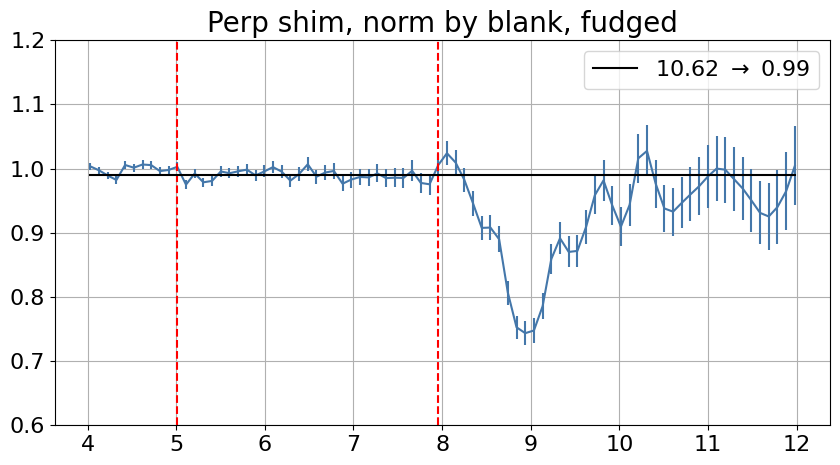

In [359]:
assert perp_shim.shape == blank_shim.shape, 'Sample and blank must have the same shape!'

use_fit = False
if not use_fit:
    perp_shim_norm = np.sum(perp_shim/blank_shim,axis=0)
    twod_errs = perp_shim/blank_shim*np.sqrt((perp_shim_errs/perp_shim)**2 + (blank_shim_errs/blank_shim)**2)
    perp_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))
elif False:
    perp_shim_norm = np.sum(perp_shim/S0,axis=0)  #cheb-4 fit
    twod_errs = perp_shim_errs/S0
    perp_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))
else:
    perp_shim_norm = np.sum(perp_shim/S0_pwr,axis=0)  #power fit
    twod_errs = perp_shim_errs/S0_pwr
    perp_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

co_indx = [10,40]
if co_indx is not None:
    av = np.average(perp_shim_norm[co_indx[0]:co_indx[1]],weights=1/perp_shim_norm_errors[co_indx[0]:co_indx[1]]**2)
    av_corr = .99
    av = av/av_corr
    perp_shim_norm = perp_shim_norm/av
    perp_shim_norm_errors = perp_shim_norm_errors/av
    fudge_line = np.full(len(qlam_blank),av_corr)

if True:
    fig,axs = prepare_plot({'title':['Perp shim, norm by blank, fudged']})
    axs[0].plot(qlam_blank,perp_shim_norm)
    axs[0].errorbar(qlam_blank,perp_shim_norm,yerr=perp_shim_norm_errors,linestyle='',color=f'C0')
    if co_indx is not None: 
        axs[0].axvline(qlam_blank[co_indx[0]],color='red',linestyle='--')
        axs[0].axvline(qlam_blank[co_indx[1]],color='red',linestyle='--')
    axs[0].plot(qlam_blank,fudge_line,color='black',label=f'{round(av,2)} $\\to$ {av_corr}')
    plt.legend()
    plt.ylim((.6,1.2))
    plt.show()

if False:
    fig,axs = prepare_plot({'title':['Perp and blank shims, sum over all pixels']})
    axs[0].set_yscale('log')
    axs[0].plot(qlam_blank,np.sum(perp_shim,axis=0),label='perp')
    axs[0].plot(qlam_blank,np.sum(blank_shim,axis=0),label='blank')
    plt.legend()
    plt.show()

if False:
    for indx,p in enumerate(PIXELS):
        fig,axs = prepare_plot({'title':[f'Shims, pixel {p}']})
        axs[0].set_yscale('log')
        axs[0].plot(qlam_blank,perp_shim[indx],label='perp')
        axs[0].errorbar(qlam_blank,perp_shim[indx],yerr=perp_shim_errs[indx],linestyle='',color=f'C0')
        axs[0].plot(qlam_blank,blank_shim[indx],label='blank')
        axs[0].errorbar(qlam_blank,blank_shim[indx],yerr=blank_shim_errs[indx],linestyle='',color=f'C1')
        plt.legend()
        plt.show()

if False:
    for indx,p in enumerate(PIXELS):
        pixel_data = (perp_shim/blank_shim)[indx]
        pixel_errs = twod_errs[indx]
        if co_indx is not None:
            av = np.average(pixel_data[co_indx[0]:co_indx[1]],weights=1/pixel_errs[co_indx[0]:co_indx[1]]**2)
            if True:
                pixel_data = pixel_data/av
                pixel_errs = pixel_errs/av
                fudge_line = np.full(len(qlam_blank),1)
            else: 
                fudge_line = np.full(len(qlam_blank),av)
                
        fig,axs = prepare_plot({'title':[f'Shims, pixel {p}']})
        axs[0].plot(qlam_blank,pixel_data,label='perp')
        axs[0].errorbar(qlam_blank,pixel_data,yerr=pixel_errs,linestyle='',color=f'C0')
        if co_indx is not None:
            axs[0].axvline(qlam_blank[co_indx[0]],color='red',linestyle='--')
            axs[0].axvline(qlam_blank[co_indx[1]],color='red',linestyle='--')
        axs[0].plot(qlam_blank,fudge_line,color='black',label=f'{round(av,2)} $\\to$ {av_corr}')
        plt.legend()
        plt.ylim((.6,1.2))
        plt.show()

if use_fit:
    _ = save_array([qlam_blank,perp_shim_norm,perp_shim_norm_errors],name='perp_p35_shim.txt',\
                   names=['Wavelength','Shim','Error'],check=False)
else:
    _ = save_array([qlam_blank,perp_shim_norm,perp_shim_norm_errors],name='perp_p35_shim_nofit.txt',\
                   names=['Wavelength','Shim','Error'],check=False)

### Sample parallel, no grating (para):
***

When the data are binned with consant Q, the difference between the peaks with and without the additional grating disappear.

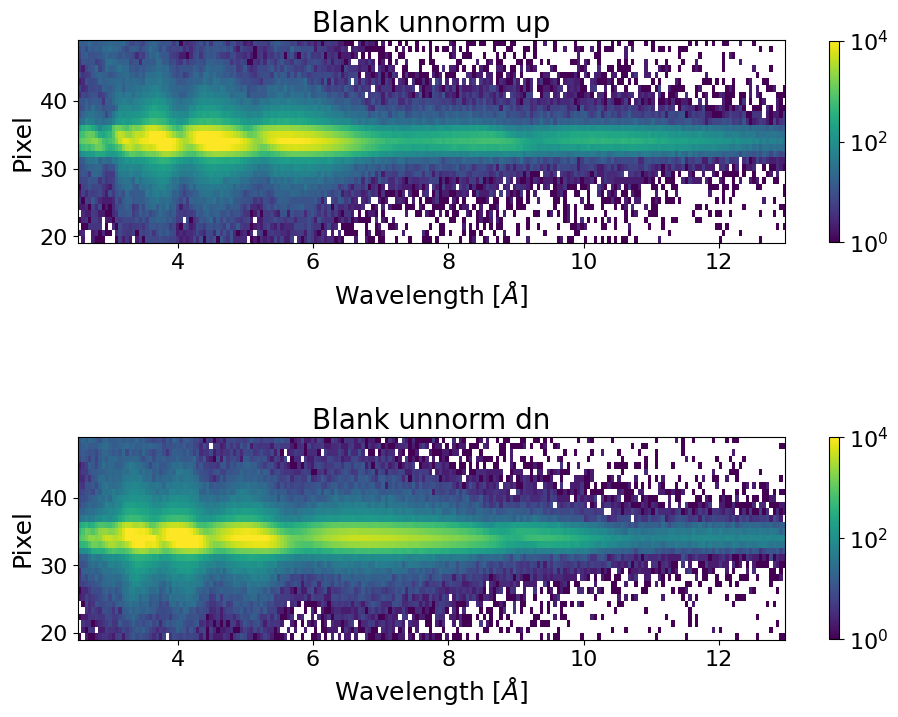

In [360]:
(lam_para_p35,up_para_p35,eup_para_p35),pname_para_p35 = load_data_2D(r"para_p35\\up.txt",pix_trim=pixs)
(_,dn_para_p35,edn_para_p35),_ = load_data_2D(r"para_p35\\dn.txt",pix_trim=pixs)
lam_para_p35 = lam_para_p35[0]

up_para_p35,up_errs_para_p35 = unnormalize(up_para_p35,eup_para_p35)
dn_para_p35,dn_errs_para_p35 = unnormalize(dn_para_p35,edn_para_p35)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_para_p35,origin='lower',extent=(lam_para_p35[0],lam_para_p35[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_para_p35,origin='lower',extent=(lam_para_p35[0],lam_para_p35[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

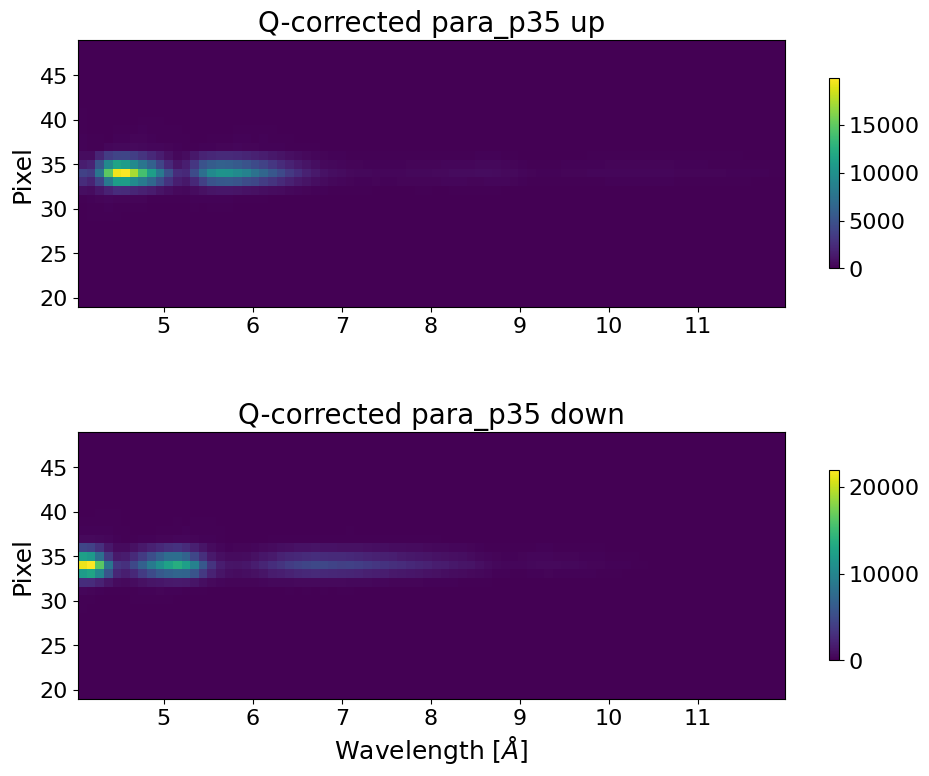

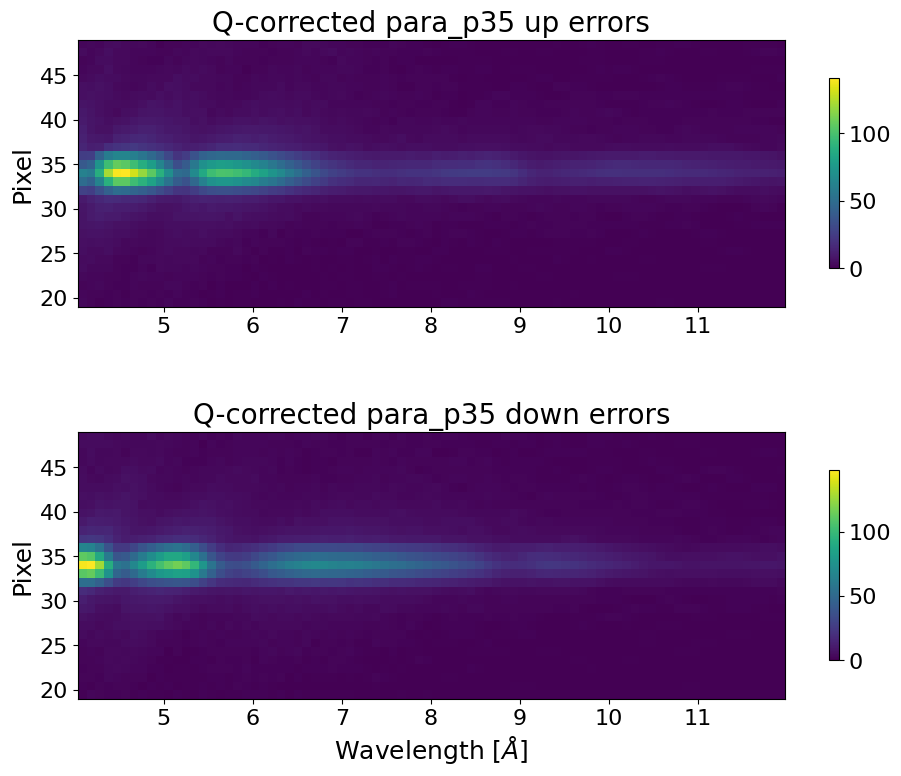

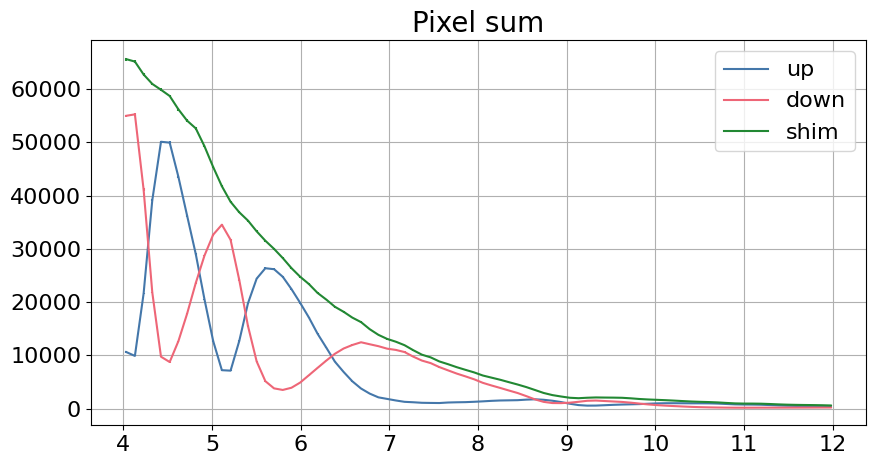

In [361]:
qlam_para_p35,qup_para_p35,qup_errs_para_p35 = get_constant_Q(up_para_p35,up_errs_para_p35,lam_b,pixs,34,.35)
_,qdn_para_p35,qdn_errs_para_p35 = get_constant_Q(dn_para_p35,dn_errs_para_p35,lam_b,pixs,34,.35)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p35 up','Q-corrected para_p35 down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p35,origin='lower',extent=(qlam_para_p35[0],qlam_para_p35[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p35,origin='lower',extent=(qlam_para_p35[0],qlam_para_p35[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p35 up errors','Q-corrected para_p35 down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_para_p35,origin='lower',extent=(qlam_para_p35[0],qlam_para_p35[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_para_p35,origin='lower',extent=(qlam_para_p35[0],qlam_para_p35[-1],pixs[0],pixs[-1]),aspect=rough_aspect)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_para_p35,s1:=np.sum(qup_para_p35,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_para_p35,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_para_p35,s2:=np.sum(qdn_para_p35,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_para_p35,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_para_p35,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_para_p35,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_para_p35[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

Center pixel:
[up,down]: [34.17842 34.16563] -> 34
Pixels used:
[33 34 35] : 3 total.


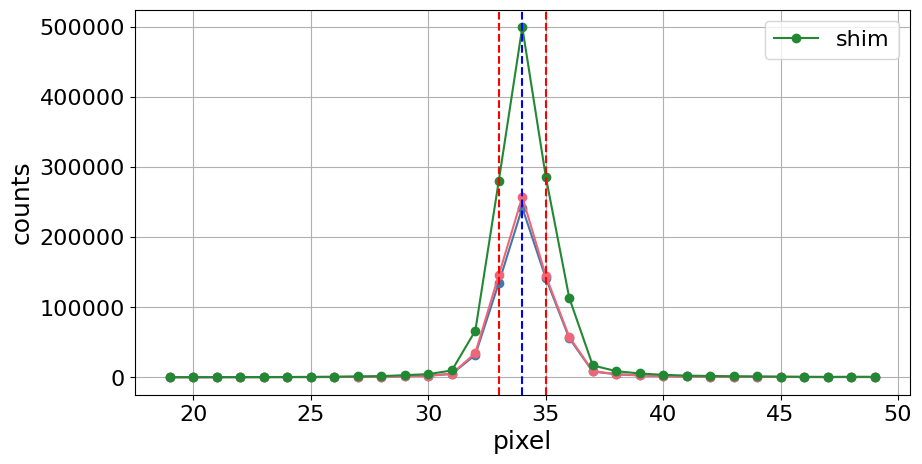

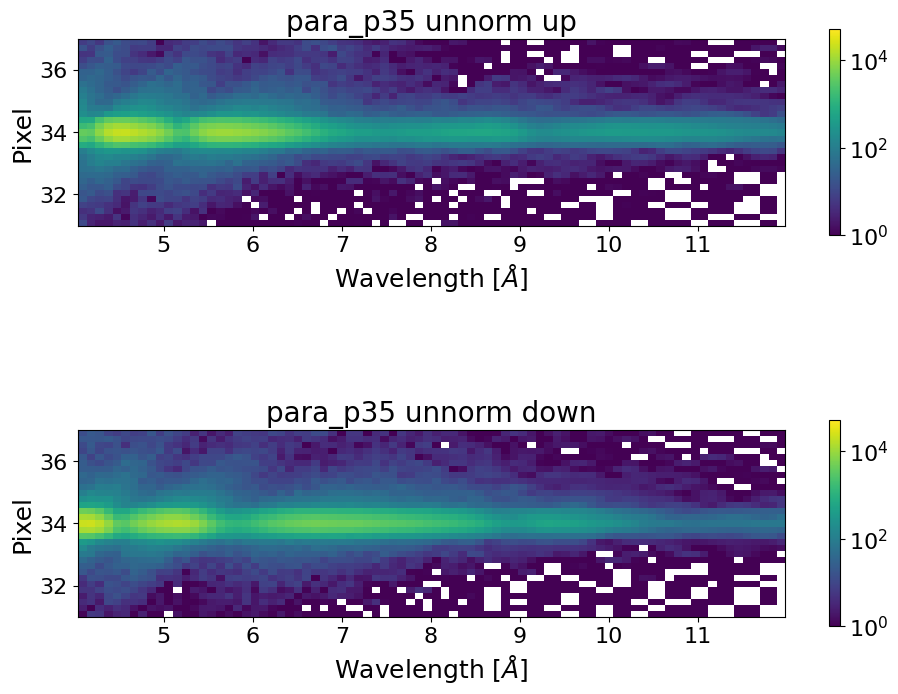

In [362]:
_ = get_center(qup_para_p35,qdn_para_p35,pname_para_p35)

fig,axs = prepare_plot({'grid':False,'title':['para_p35 unnorm up','para_p35 unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p35,origin='lower',extent=(qlam_para_p35[0],qlam_para_p35[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p35,origin='lower',extent=(qlam_para_p35[0],qlam_para_p35[-1],PIXELS[0],PIXELS[-1]),aspect=fine_aspect,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

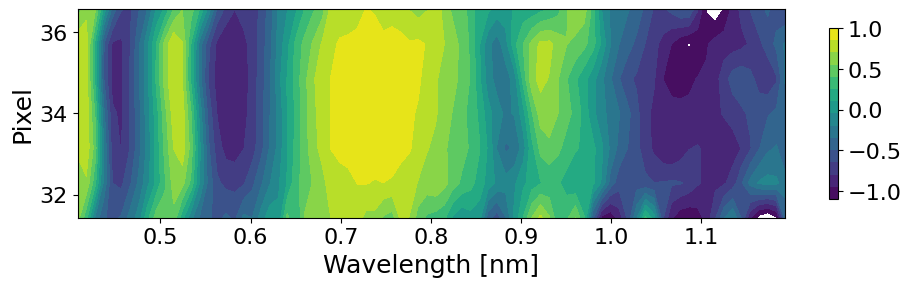

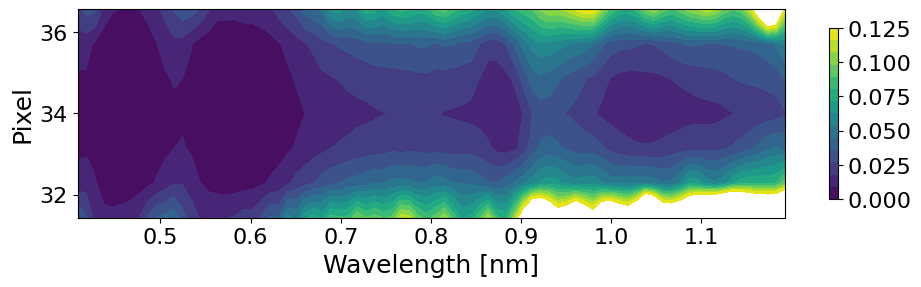

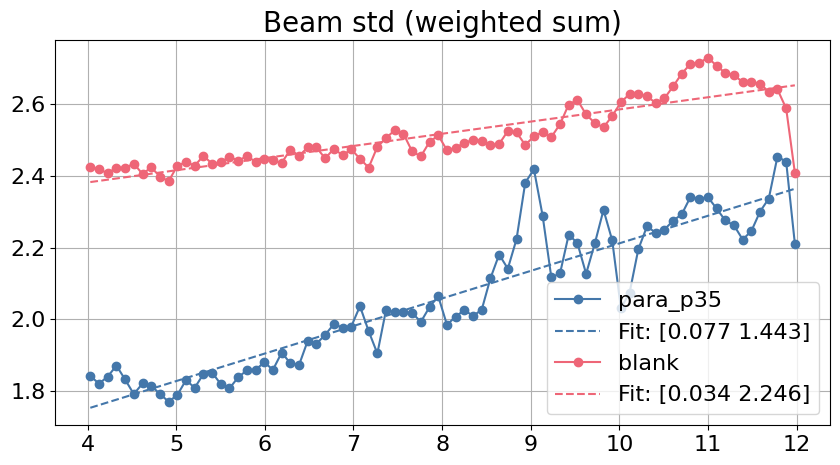

In [376]:
para_p35_shim,para_p35_shim_errs,para_p35_pol,para_p35_pol_errs,para_p35_shim_std = get_pol_shim(qup_para_p35,qdn_para_p35,qup_errs_para_p35,qdn_errs_para_p35,pname_para_p35,trim=PIXELS)
para_p35_pol = para_p35_pol/P0  #normalizing to blank sample
para_p35_pol_errs = para_p35_pol_errs/P0

if False:
    fig,axs = prepare_plot({'grid':False,'title':['para_p35 shim'],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']})
    im1 = axs[0].imshow(para_p35_shim,origin='lower',extent=(.1*qlam_para_p35[0],.1*qlam_para_p35[-1],PIXELS[0],PIXELS[-1]),\
                        aspect=.05,norm=LogNorm(vmin=1, vmax=1e5))
    plt.colorbar(im1,shrink=.3)
    plt.tight_layout()
    plt.show()

if True:
    fig,axs = prepare_plot({'grid':False,'title':[''],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']}) #[r'$P_y^{\|} / P_0$']
    cfill_levels = np.linspace(-1.1,np.max(para_p35_pol),15)
    CS = axs[0].contourf(para_p35_pol,origin='lower',levels=cfill_levels,extent=(.1*qlam_para_p35[0],.1*qlam_para_p35[-1],PIXELS[0],PIXELS[-1]))
    axs[0].set_aspect(.045)
    plt.colorbar(CS,shrink=.4,ticks=[-1,-.5,0,.5,1])
    plt.tight_layout()
    plt.show()

if False:
    fig,axs = prepare_plot({'grid':False,'title':['para_p35 shim errors'],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']})
    im1 = axs[0].imshow(para_p35_shim_errs,origin='lower',extent=(.1*qlam_para_p35[0],.1*qlam_para_p35[-1],PIXELS[0],PIXELS[-1]),\
                        aspect=.05,norm=LogNorm(vmin=1, vmax=1e2))
    plt.colorbar(im1,shrink=.3)
    plt.tight_layout()
    plt.show()

if True:
    fig,axs = prepare_plot({'grid':False,'title':[r''],'xlabel':[r'Wavelength [nm]'],'ylabel':['Pixel']})
    cfill_levels = np.linspace(0,.125,15)
    CS = axs[0].contourf(para_p35_pol_errs,origin='lower',levels=cfill_levels,extent=(.1*qlam_para_p35[0],.1*qlam_para_p35[-1],PIXELS[0],PIXELS[-1]))
    axs[0].set_aspect(.045)
    plt.colorbar(CS,shrink=.4,ticks=[0,.025,.05,.075,.1,.125])
    plt.tight_layout()
    plt.show()

if True:
    co_std_indx = 0
    fig,axs = prepare_plot({'title':['Beam std (weighted sum)']})
    axs[0].plot(qlam_para_p35,para_p35_shim_std,'o-',label='para_p35',color=f'C0')
    para_p35_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_para_p35[co_std_indx:],para_p35_shim_std[co_std_indx:])
    axs[0].plot(qlam_para_p35[co_std_indx:],f(qlam_para_p35[co_std_indx:],*para_p35_parms),'--',label=f'Fit: {np.round(para_p35_parms,3)}',color=f'C0')
    axs[0].plot(qlam_blank,blank_shim_std,'o-',label=f'blank',color=f'C1')
    axs[0].plot(qlam_blank[co_std_indx:],f(qlam_blank[co_std_indx:],*blank_parms),'--',label=f'Fit: {np.round(blank_parms,3)}',color=f'C1')
    plt.legend()
    plt.show()

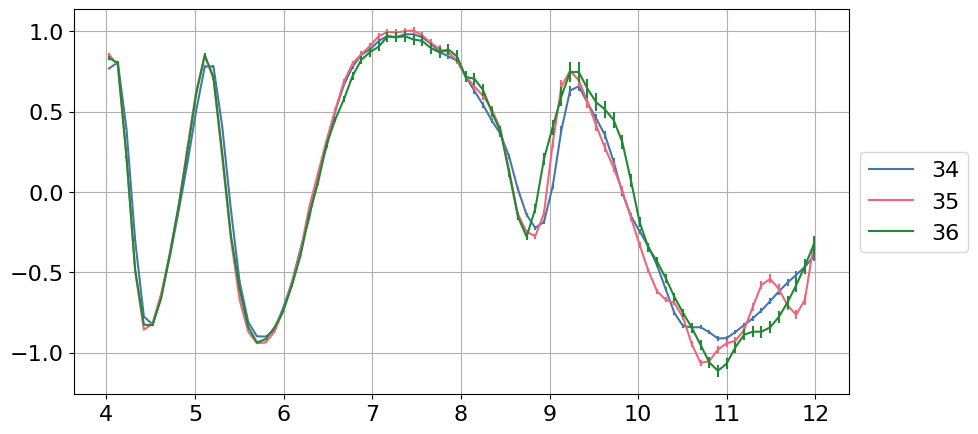

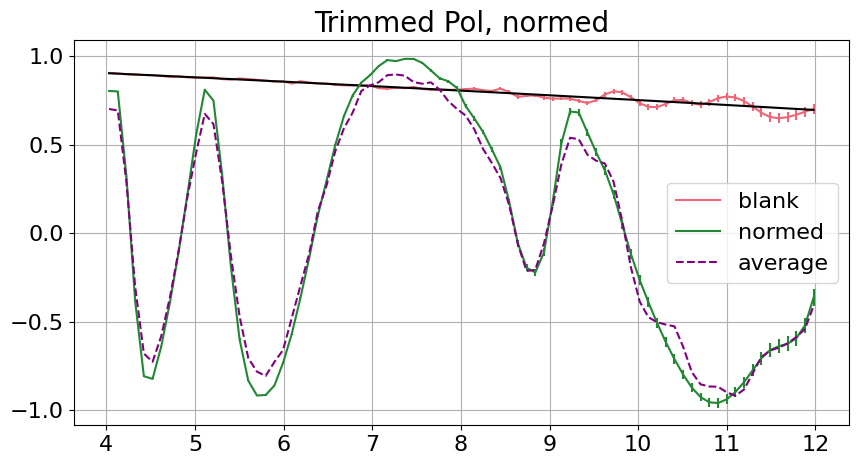

In [384]:
trim2 = np.array([3,4,5])

if True:
    fig,axs = prepare_plot()
    for indx,(pixel,data,error) in enumerate(zip(PIXELS[trim2],para_p35_pol[trim2],para_p35_pol_errs[trim2])):
        axs[0].plot(qlam_para_p35,data,color=f'C{indx}',label=f'{pixel}')
        axs[0].errorbar(qlam_para_p35,data,yerr=error,linestyle='',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if False:
    for indx,(pixel,data,error) in enumerate(zip(PIXELS[trim2],para_p35_pol[trim2],para_p35_pol_errs[trim2])):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        plt.show()

para_p35_rb,para_p35_err_rb = get_pol_rb(qup_para_p35,qdn_para_p35,rt2)
blank_rb,blank_err_rb = get_pol_rb(qup_blank,qdn_blank,rt2)
P0_rb = do_fit(qlam_blank,[blank_rb],err=[blank_err_rb])[0]
para_p35_rb_norm = para_p35_rb/P0_rb
para_p35_err_rb_norm = para_p35_err_rb/P0_rb

_ = save_array([qlam_blank,para_p35_rb_norm,para_p35_err_rb_norm],name='para_p35_pol.txt',\
               names=['Wavelength','Pol','Error'],check=False)

fig,axs = prepare_plot({'title':['Trimmed Pol, normed']})
if True:
    #axs[0].plot(qlam_blank,para_p35_rb,color=f'C0')
    #axs[0].errorbar(qlam_blank,para_p35_rb,yerr=para_p35_err_rb,linestyle='',color=f'C0')
    axs[0].plot(qlam_blank,blank_rb,label='blank',color=f'C1')
    axs[0].errorbar(qlam_blank,blank_rb,yerr=blank_err_rb,linestyle='',color=f'C1')
    axs[0].plot(qlam_blank,P0_rb,color='black')
axs[0].plot(qlam_blank,para_p35_rb_norm,label='normed',color=f'C2')
axs[0].errorbar(qlam_blank,para_p35_rb_norm,yerr=para_p35_err_rb_norm,linestyle='',color=f'C2')
if False:
    axs[0].plot(temp[0],temp[1],color=f'red',label='loaded')
    axs[0].errorbar(temp[0],temp[1],yerr=temp[2],linestyle='',color=f'red')
axs[0].plot(qlam_blank,np.mean(para_p35_pol,axis=0),'--',label='average',color='purple')
plt.legend()
plt.show()

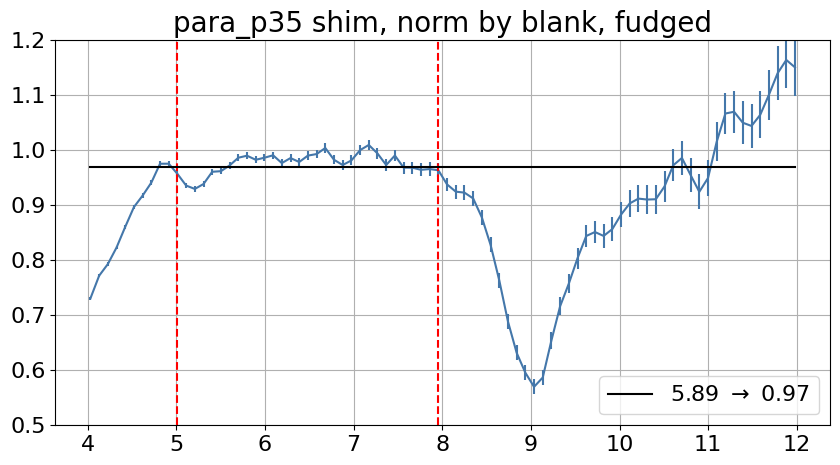

In [392]:
assert para_p35_shim.shape == blank_shim.shape, 'Sample and blank must have the same shape!'

use_fit = True
if not use_fit:
    para_p35_shim_norm = np.sum(para_p35_shim/blank_shim,axis=0)
    twod_errs = para_p35_shim/blank_shim*np.sqrt((para_p35_shim_errs/para_p35_shim)**2 + (blank_shim_errs/blank_shim)**2)
    para_p35_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))
elif False:
    para_p35_shim_norm = np.sum(para_p35_shim/S0,axis=0)  #cheb-4 fit
    twod_errs = para_p35_shim_errs/S0
    para_p35_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))
else:
    para_p35_shim_norm = np.sum(para_p35_shim/S0_pwr,axis=0)  #power fit
    twod_errs = para_p35_shim_errs/S0_pwr
    para_p35_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

co_indx = [10,40]
if co_indx is not None:
    av = np.average(para_p35_shim_norm[co_indx[0]:co_indx[1]],weights=1/para_p35_shim_norm_errors[co_indx[0]:co_indx[1]]**2)
    av_corr = .97
    av = av/av_corr
    para_p35_shim_norm = para_p35_shim_norm/av
    para_p35_shim_norm_errors = para_p35_shim_norm_errors/av
    fudge_line = np.full(len(qlam_blank),av_corr)

if True:
    fig,axs = prepare_plot({'title':['para_p35 shim, norm by blank, fudged']})
    axs[0].plot(qlam_blank,para_p35_shim_norm)
    axs[0].errorbar(qlam_blank,para_p35_shim_norm,yerr=para_p35_shim_norm_errors,linestyle='',color=f'C0')
    if co_indx is not None: 
        axs[0].axvline(qlam_blank[co_indx[0]],color='red',linestyle='--')
        axs[0].axvline(qlam_blank[co_indx[1]],color='red',linestyle='--')
    axs[0].plot(qlam_blank,fudge_line,color='black',label=f'{round(av,2)} $\\to$ {av_corr}')
    plt.legend()
    plt.ylim((.5,1.2))
    plt.show()

if False:
    fig,axs = prepare_plot({'title':['para_p35 and blank shims, sum over all pixels']})
    axs[0].set_yscale('log')
    axs[0].plot(qlam_blank,np.sum(para_p35_shim,axis=0),label='para_p35')
    axs[0].plot(qlam_blank,np.sum(blank_shim,axis=0),label='blank')
    plt.legend()
    plt.show()

if False:
    for indx,p in enumerate(PIXELS):
        fig,axs = prepare_plot({'title':[f'Shims, pixel {p}']})
        axs[0].set_yscale('log')
        axs[0].plot(qlam_blank,para_p35_shim[indx],label='para_p35')
        axs[0].errorbar(qlam_blank,para_p35_shim[indx],yerr=para_p35_shim_errs[indx],linestyle='',color=f'C0')
        axs[0].plot(qlam_blank,blank_shim[indx],label='blank')
        axs[0].errorbar(qlam_blank,blank_shim[indx],yerr=blank_shim_errs[indx],linestyle='',color=f'C1')
        plt.legend()
        plt.show()

if False:
    for indx,p in enumerate(PIXELS):
        pixel_data = (para_p35_shim/blank_shim)[indx]
        pixel_errs = twod_errs[indx]
        if co_indx is not None:
            av = np.average(pixel_data[co_indx[0]:co_indx[1]],weights=1/pixel_errs[co_indx[0]:co_indx[1]]**2)
            if True:
                pixel_data = pixel_data/av
                pixel_errs = pixel_errs/av
                fudge_line = np.full(len(qlam_blank),1)
            else: 
                fudge_line = np.full(len(qlam_blank),av)
                
        fig,axs = prepare_plot({'title':[f'Shims, pixel {p}']})
        axs[0].plot(qlam_blank,pixel_data,label='para_p35')
        axs[0].errorbar(qlam_blank,pixel_data,yerr=pixel_errs,linestyle='',color=f'C0')
        if co_indx is not None:
            axs[0].axvline(qlam_blank[co_indx[0]],color='red',linestyle='--')
            axs[0].axvline(qlam_blank[co_indx[1]],color='red',linestyle='--')
        axs[0].plot(qlam_blank,fudge_line,color='black',label=f'{round(av,2)} $\\to$ {av_corr}')
        plt.legend()
        plt.ylim((.5,1.2))
        plt.show()

if use_fit:
    _ = save_array([qlam_blank,para_p35_shim_norm,para_p35_shim_norm_errors],name='para_p35_shim.txt',\
                   names=['Wavelength','Shim','Error'],check=False)
else:
    _ = save_array([qlam_blank,para_p35_shim_norm,para_p35_shim_norm_errors],name='para_p35_shim_nofit.txt',\
                   names=['Wavelength','Shim','Error'],check=False)

### Sample parallel, grating before: (outdated)
***

There is a noticeable spread in the beam width due to Bragg scattering from the grating.

In [ ]:
pixs = np.arange(27,42)  #rough detector pixel trimming
(lam_para_p35_before,up_para_p35_before,eup_para_p35_before),pname_para_p35_before = load_data_2D(r"para_p35_before\\up.txt",pix_trim=pixs)
(_,dn_para_p35_before,edn_para_p35_before),_ = load_data_2D(r"para_p35_before\\dn.txt",pix_trim=pixs)
lam_para_p35_before = lam_para_p35_before[0]

up_para_p35_before,up_errs_para_p35_before = unnormalize(up_para_p35_before,eup_para_p35_before)
dn_para_p35_before,dn_errs_para_p35_before = unnormalize(dn_para_p35_before,edn_para_p35_before)

fig,axs = prepare_plot({'grid':False,'title':['para_p35_before unnorm up','para_p35_before unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_para_p35_before,origin='lower',extent=(lam_para_p35_before[0],lam_para_p35_before[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_para_p35_before,origin='lower',extent=(lam_para_p35_before[0],lam_para_p35_before[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

In [ ]:
qlam_para_p35_before,qup_para_p35_before,qup_errs_para_p35_before = get_constant_Q(up_para_p35_before,up_errs_para_p35_before,lam_b,pixs,34,.35)
_,qdn_para_p35_before,qdn_errs_para_p35_before = get_constant_Q(dn_para_p35_before,dn_errs_para_p35_before,lam_b,pixs,34,.35)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p35_before up','Q-corrected para_p35_before down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p35_before,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p35_before,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p35_before up errors','Q-corrected para_p35_before down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_para_p35_before,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_para_p35_before,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_para_p35_before,s1:=np.sum(qup_para_p35_before,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_para_p35_before,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_para_p35_before,s2:=np.sum(qdn_para_p35_before,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_para_p35_before,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_para_p35_before,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_para_p35_before,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_para_p35_before[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

In [ ]:
_ = get_center(qup_para_p35_before,qdn_para_p35_before,pname_b,threshold=.2)

fig,axs = prepare_plot({'grid':False,'title':['para_p35_before unnorm up','para_p35_before unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p35_before,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p35_before,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

In [ ]:
para_p35_before_shim,para_p35_before_shim_errs,para_p35_before_pol,para_p35_before_pol_errs,para_p35_before_shim_std = get_pol_shim(qup_para_p35_before,qdn_para_p35_before,qup_errs_para_p35_before,qdn_errs_para_p35_before,pname_b,trim=PIXELS)
para_p35_before_pol = para_p35_before_pol/P0  #normalizing to blank sample
para_p35_before_pol_errs = para_p35_before_pol_errs/P0

fig,axs = prepare_plot({'grid':False,'title':['before shim','before pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_p35_before_shim,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_p35_before_pol,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(-1.1,1.1,11)
    CS = axs[1].contourf(para_p35_before_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_p35_before_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['before shim errors','before pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_p35_before_shim_errs,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_p35_before_pol_errs,origin='lower',extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.1,5)
    CS = axs[1].contourf(para_p35_before_pol_errs,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_p35_before_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_before[0],qlam_para_p35_before[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Beam std (weighted sum)']})
axs[0].plot(qlam_para_p35_before,para_p35_before_shim_std,'o-',label='before')
para_p35_before_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_para_p35_before,para_p35_before_shim_std)
axs[0].plot(qlam_para_p35_before,f(qlam_para_p35_before,*para_p35_before_parms),color='black')
axs[0].plot(qlam_blank,para_shim_std,'o-',label=f'para')
axs[0].plot(qlam_blank,f(qlam_blank,*para_parms),color='black')
axs[0].plot(qlam_blank,perp_shim_std,'o-',label=f'perp')
axs[0].plot(qlam_blank,f(qlam_blank,*perp_parms),color='black')
axs[0].plot(qlam_blank,blank_shim_std,'o-',label=f'blank')
axs[0].plot(qlam_blank,f(qlam_blank,*blank_parms),color='black')
#axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].legend()
plt.show()

In [ ]:
if True:
    fig,axs = prepare_plot()
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_p35_before_pol,para_p35_before_pol_errs)):
        axs[0].plot(qlam_para_p35_before,data,color=f'C{indx}',label=f'{pixel}')
        axs[0].errorbar(qlam_para_p35_before,data,yerr=error,linestyle='',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if True:
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_p35_before_pol,para_p35_before_pol_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        plt.show()

In [ ]:
assert para_p35_before_shim.shape == blank_shim.shape, 'Sample and blank must have the same shape!'
para_p35_before_shim_norm = np.sum(para_p35_before_shim/blank_shim,axis=0)
twod_errs = para_p35_before_shim/blank_shim*np.sqrt((para_p35_before_shim_errs/para_p35_before_shim)**2 + (blank_shim_errs/blank_shim)**2)
para_p35_before_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

para_shim_norm = np.sum(para_shim/blank_shim,axis=0)
twod_errs = para_shim/blank_shim*np.sqrt((para_shim_errs/para_shim)**2 + (blank_shim_errs/blank_shim)**2)
para_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

perp_shim_norm = np.sum(perp_shim/blank_shim,axis=0)
twod_errs = perp_shim/blank_shim*np.sqrt((perp_shim_errs/perp_shim)**2 + (blank_shim_errs/blank_shim)**2)
perp_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

if True:
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:50],para_p35_before_shim_norm[:50])
    para_p35_before_shim_norm = para_p35_before_shim_norm/f(qlam_blank,*temp)
    para_p35_before_shim_norm_errors = para_p35_before_shim_norm_errors/f(qlam_blank,*temp)
    #para_p35_before_shim_norm_errors = para_p35_before_shim_norm_errors/para_p35_before_shim_norm_errors[0]
    
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:50],para_shim_norm[:50])
    para_shim_norm = para_shim_norm/f(qlam_blank,*temp)
    para_shim_norm_errors = para_shim_norm_errors/f(qlam_blank,*temp)
    
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:60],perp_shim_norm[:60])
    perp_shim_norm = perp_shim_norm/f(qlam_blank,*temp)
    perp_shim_norm_errors = perp_shim_norm_errors/f(qlam_blank,*temp)

fig,axs = prepare_plot({'title':['Shims, norm by blank, fudged to unity']})
axs[0].plot(qlam_blank,para_p35_before_shim_norm,label='para_p35_before')
axs[0].errorbar(qlam_blank,para_p35_before_shim_norm,yerr=para_p35_before_shim_norm_errors,linestyle='',color=f'C0')
axs[0].plot(qlam_blank,para_shim_norm,label='para')
axs[0].errorbar(qlam_blank,para_shim_norm,yerr=para_shim_norm_errors,linestyle='',color=f'C1')
axs[0].plot(qlam_blank,perp_shim_norm,label='perp')
axs[0].errorbar(qlam_blank,perp_shim_norm,yerr=perp_shim_norm_errors,linestyle='',color=f'C2')
plt.legend()
plt.show()

if True:
    fig,axs = prepare_plot({'title':['Shims, not normalized']})
    axs[0].set_yscale('log')
    axs[0].plot(qlam_blank,np.sum(para_p35_before_shim,axis=0),label='para_p35_before')
    axs[0].plot(qlam_blank,np.sum(para_shim,axis=0),label='para')
    axs[0].plot(qlam_blank,np.sum(perp_shim,axis=0),label='perp')
    axs[0].plot(qlam_blank,np.sum(blank_shim,axis=0),label='blank')
    plt.legend()
    plt.show()

if False:
    for indx,p in enumerate(PIXELS):
        fig,axs = prepare_plot({'title':[f'Shims, pixel {p}']})
        axs[0].set_yscale('log')
        axs[0].plot(qlam_blank,para_p35_before_shim[indx],label='para_p35_before')
        axs[0].errorbar(qlam_blank,para_p35_before_shim[indx],yerr=para_p35_before_shim_errs[indx],linestyle='',color=f'C0')
        axs[0].plot(qlam_blank,para_shim[indx],label='para')
        axs[0].errorbar(qlam_blank,para_shim[indx],yerr=para_shim_errs[indx],linestyle='',color=f'C1')
        axs[0].plot(qlam_blank,perp_shim[indx],label='perp')
        axs[0].errorbar(qlam_blank,perp_shim[indx],yerr=perp_shim_errs[indx],linestyle='',color=f'C2')
        axs[0].plot(qlam_blank,blank_shim[indx],label='blank')
        axs[0].errorbar(qlam_blank,blank_shim[indx],yerr=blank_shim_errs[indx],linestyle='',color=f'C3')
        plt.legend()
        plt.show()

### Sample parallel, grating after: (outdated)
***

Beam is slightly more spread out that the grating before data as expected. Also, the constant-Q binning shows that the scattering is proportional to wavelength, as expected.

In [ ]:
pixs = np.arange(27,42)  #rough detector pixel trimming
(lam_para_p35_after,up_para_p35_after,eup_para_p35_after),pname_para_p35_after = load_data_2D(r"para_p35_after\\up.txt",pix_trim=pixs)
(_,dn_para_p35_after,edn_para_p35_after),_ = load_data_2D(r"para_p35_after\\dn.txt",pix_trim=pixs)
lam_para_p35_after = lam_para_p35_after[0]

up_para_p35_after,up_errs_para_p35_after = unnormalize(up_para_p35_after,eup_para_p35_after)
dn_para_p35_after,dn_errs_para_p35_after = unnormalize(dn_para_p35_after,edn_para_p35_after)

fig,axs = prepare_plot({'grid':False,'title':['para_p35_after unnorm up','para_p35_after unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_para_p35_after,origin='lower',extent=(lam_para_p35_after[0],lam_para_p35_after[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_para_p35_after,origin='lower',extent=(lam_para_p35_after[0],lam_para_p35_after[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

In [ ]:
qlam_para_p35_after,qup_para_p35_after,qup_errs_para_p35_after = get_constant_Q(up_para_p35_after,up_errs_para_p35_after,lam_b,pixs,34,.35)
_,qdn_para_p35_after,qdn_errs_para_p35_after = get_constant_Q(dn_para_p35_after,dn_errs_para_p35_after,lam_b,pixs,34,.35)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p35_after up','Q-corrected para_p35_after down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p35_after,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p35_after,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p35_after up errors','Q-corrected para_p35_after down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_para_p35_after,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_para_p35_after,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_para_p35_after,s1:=np.sum(qup_para_p35_after,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_para_p35_after,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_para_p35_after,s2:=np.sum(qdn_para_p35_after,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_para_p35_after,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_para_p35_after,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_para_p35_after,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_para_p35_after[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

In [ ]:
_ = get_center(qup_para_p35_after,qdn_para_p35_after,pname_b,threshold=.2)

fig,axs = prepare_plot({'grid':False,'title':['para_p35_after unnorm up','para_p35_after unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p35_after,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p35_after,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

In [ ]:
para_p35_after_shim,para_p35_after_shim_errs,para_p35_after_pol,para_p35_after_pol_errs,para_p35_after_shim_std = get_pol_shim(qup_para_p35_after,qdn_para_p35_after,qup_errs_para_p35_after,qdn_errs_para_p35_after,pname_b,trim=PIXELS)
para_p35_after_pol = para_p35_after_pol/P0  #normalizing to blank sample
para_p35_after_pol_errs = para_p35_after_pol_errs/P0

fig,axs = prepare_plot({'grid':False,'title':['after shim','after pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_p35_after_shim,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_p35_after_pol,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(-1.1,1.1,11)
    CS = axs[1].contourf(para_p35_after_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_p35_after_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['after shim errors','after pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_p35_after_shim_errs,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_p35_after_pol_errs,origin='lower',extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.1,5)
    CS = axs[1].contourf(para_p35_after_pol_errs,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_p35_after_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p35_after[0],qlam_para_p35_after[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Beam std (weighted sum)'],'xlabel':[r'Wavelength $[\AA]$']})
axs[0].plot(qlam_para_p35_after,para_p35_after_shim_std,'o-',label='after')
para_p35_after_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_para_p35_after,para_p35_after_shim_std)
axs[0].plot(qlam_para_p35_after,f(qlam_para_p35_after,*para_p35_after_parms),color='black')
axs[0].plot(qlam_blank,para_p35_before_shim_std,'o-',label=f'before')
axs[0].plot(qlam_blank,f(qlam_blank,*para_p35_before_parms),color='black')
axs[0].plot(qlam_blank,para_shim_std,'o-',label=f'para')
axs[0].plot(qlam_blank,f(qlam_blank,*para_parms),color='black')
axs[0].plot(qlam_blank,perp_shim_std,'o-',label=f'perp')
axs[0].plot(qlam_blank,f(qlam_blank,*perp_parms),color='black')
axs[0].plot(qlam_blank,blank_shim_std,'o-',label=f'blank')
axs[0].plot(qlam_blank,f(qlam_blank,*blank_parms),color='black')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
if True:
    fig,axs = prepare_plot()
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_p35_after_pol,para_p35_after_pol_errs)):
        axs[0].plot(qlam_para_p35_after,data,color=f'C{indx}',label=f'{pixel}')
        axs[0].errorbar(qlam_para_p35_after,data,yerr=error,linestyle='',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if True:
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_p35_after_pol,para_p35_after_pol_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        plt.show()

In [ ]:
assert para_p35_after_shim.shape == blank_shim.shape, 'Sample and blank must have the same shape!'
para_p35_after_shim_norm = np.sum(para_p35_after_shim/blank_shim,axis=0)
twod_errs = para_p35_after_shim/blank_shim*np.sqrt((para_p35_after_shim_errs/para_p35_after_shim)**2 + (blank_shim_errs/blank_shim)**2)
para_p35_after_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

para_p35_before_shim_norm = np.sum(para_p35_before_shim/blank_shim,axis=0)
twod_errs = para_p35_before_shim/blank_shim*np.sqrt((para_p35_before_shim_errs/para_p35_before_shim)**2 + (blank_shim_errs/blank_shim)**2)
para_p35_before_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

para_shim_norm = np.sum(para_shim/blank_shim,axis=0)
twod_errs = para_shim/blank_shim*np.sqrt((para_shim_errs/para_shim)**2 + (blank_shim_errs/blank_shim)**2)
para_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

perp_shim_norm = np.sum(perp_shim/blank_shim,axis=0)
twod_errs = perp_shim/blank_shim*np.sqrt((perp_shim_errs/perp_shim)**2 + (blank_shim_errs/blank_shim)**2)
perp_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

if True:
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:50],para_p35_after_shim_norm[:50])
    para_p35_after_shim_norm = para_p35_after_shim_norm/f(qlam_blank,*temp)
    para_p35_after_shim_norm_errors = para_p35_after_shim_norm_errors/f(qlam_blank,*temp)
    
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:50],para_p35_before_shim_norm[:50])
    para_p35_before_shim_norm = para_p35_before_shim_norm/f(qlam_blank,*temp)
    para_p35_before_shim_norm_errors = para_p35_before_shim_norm_errors/f(qlam_blank,*temp)
    
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:50],para_shim_norm[:50])
    para_shim_norm = para_shim_norm/f(qlam_blank,*temp)
    para_shim_norm_errors = para_shim_norm_errors/f(qlam_blank,*temp)
    
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:60],perp_shim_norm[:60])
    perp_shim_norm = perp_shim_norm/f(qlam_blank,*temp)
    perp_shim_norm_errors = perp_shim_norm_errors/f(qlam_blank,*temp)

fig,axs = prepare_plot({'title':['Shims, norm by blank, fudged to unity']})
axs[0].plot(qlam_blank,para_p35_after_shim_norm,label='para_p35_after')
axs[0].errorbar(qlam_blank,para_p35_after_shim_norm,yerr=para_p35_after_shim_norm_errors,linestyle='',color=f'C0')
axs[0].plot(qlam_blank,para_p35_before_shim_norm,label='para_p35_before')
axs[0].errorbar(qlam_blank,para_p35_before_shim_norm,yerr=para_p35_before_shim_norm_errors,linestyle='',color=f'C1')
#axs[0].plot(qlam_blank,para_shim_norm,label='para')
#axs[0].errorbar(qlam_blank,para_shim_norm,yerr=para_shim_norm_errors,linestyle='',color=f'C2')
#axs[0].plot(qlam_blank,perp_shim_norm,label='perp')
#axs[0].errorbar(qlam_blank,perp_shim_norm,yerr=perp_shim_norm_errors,linestyle='',color=f'C3')
plt.legend()
plt.show()

if True:
    fig,axs = prepare_plot({'title':['Shims, not normalized']})
    axs[0].set_yscale('log')
    axs[0].plot(qlam_blank,np.sum(para_p35_after_shim,axis=0),label='para_p35_after')
    axs[0].plot(qlam_blank,np.sum(para_p35_before_shim,axis=0),label='para_p35_before')
    axs[0].plot(qlam_blank,np.sum(para_shim,axis=0),label='para')
    axs[0].plot(qlam_blank,np.sum(perp_shim,axis=0),label='perp')
    axs[0].plot(qlam_blank,np.sum(blank_shim,axis=0),label='blank')
    plt.legend()
    plt.show()

if False:
    for indx,p in enumerate(PIXELS):
        fig,axs = prepare_plot({'title':[f'Shims, pixel {p}']})
        axs[0].set_yscale('log')
        axs[0].plot(qlam_blank,para_p35_after_shim[indx],label='para_p35_after')
        axs[0].errorbar(qlam_blank,para_p35_after_shim[indx],yerr=para_p35_after_shim_errs[indx],linestyle='',color=f'C0')
        axs[0].plot(qlam_blank,para_p35_before_shim[indx],label='para_p35_before')
        axs[0].errorbar(qlam_blank,para_p35_before_shim[indx],yerr=para_p35_before_shim_errs[indx],linestyle='',color=f'C1')
        axs[0].plot(qlam_blank,para_shim[indx],label='para')
        axs[0].errorbar(qlam_blank,para_shim[indx],yerr=para_shim_errs[indx],linestyle='',color=f'C2')
        axs[0].plot(qlam_blank,perp_shim[indx],label='perp')
        axs[0].errorbar(qlam_blank,perp_shim[indx],yerr=perp_shim_errs[indx],linestyle='',color=f'C3')
        axs[0].plot(qlam_blank,blank_shim[indx],label='blank')
        axs[0].errorbar(qlam_blank,blank_shim[indx],yerr=blank_shim_errs[indx],linestyle='',color=f'C4')
        plt.legend()
        plt.show()

***
### 0.4 degree data (outdated)
***

The center pixel changed from 34 to 33. Also, the Q-correction changes the wavelength binning slightly. Therefore, the bins at constant Q are off by 0.003 and offset by a similar amount.

Instead of applying the Q-correction to the blank shim, will probably (also?) have to rebin the blank shim intensity.

Beam is also narrower for some reason?

#### No grating:

In [ ]:
pixs = np.arange(27,42)  #rough detector pixel trimming
(lam_para_p40,up_para_p40,eup_para_p40),pname_para_p40 = load_data_2D(r"para_p40\\up.txt",pix_trim=pixs)
(_,dn_para_p40,edn_para_p40),_ = load_data_2D(r"para_p40\\dn.txt",pix_trim=pixs)
lam_para_p40 = lam_para_p40[0]

up_para_p40,up_errs_para_p40 = unnormalize(up_para_p40,eup_para_p40)
dn_para_p40,dn_errs_para_p40 = unnormalize(dn_para_p40,edn_para_p40)

fig,axs = prepare_plot({'grid':False,'title':['para_p40 unnorm up','para_p40 unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_para_p40,origin='lower',extent=(lam_para_p40[0],lam_para_p40[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_para_p40,origin='lower',extent=(lam_para_p40[0],lam_para_p40[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

In [ ]:
qlam_para_p40,qup_para_p40,qup_errs_para_p40 = get_constant_Q(up_para_p40,up_errs_para_p40,lam_b,pixs,33,.4)
_,qdn_para_p40,qdn_errs_para_p40 = get_constant_Q(dn_para_p40,dn_errs_para_p40,lam_b,pixs,33,.4)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p40 up','Q-corrected para_p40 down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p40,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p40,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para_p40 up errors','Q-corrected para_p40 down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_para_p40,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_para_p40,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_para_p40,s1:=np.sum(qup_para_p40,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_para_p40,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_para_p40,s2:=np.sum(qdn_para_p40,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_para_p40,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_para_p40,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_para_p40,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_para_p40[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

In [ ]:
_ = get_center(qup_para_p40,qdn_para_p40,pname_b,threshold=.2)

fig,axs = prepare_plot({'grid':False,'title':['para_p40 unnorm up','para_p40 unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para_p40,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para_p40,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

In [ ]:
para_p40_shim,para_p40_shim_errs,para_p40_pol,para_p40_pol_errs,para_p40_shim_std = get_pol_shim(qup_para_p40,qdn_para_p40,qup_errs_para_p40,qdn_errs_para_p40,pname_b,trim=PIXELS)

if len(qlam_para_p40) != len(qlam_blank):
    temp = [para_p40_shim,para_p40_shim_errs,para_p40_pol,para_p40_pol_errs]
    para_p40_shim,para_p40_shim_errs,para_p40_pol,para_p40_pol_errs, = [k[:,1:] for k in temp]
    temp2 = [qlam_para_p40,para_p40_shim_std]
    qlam_para_p40,para_p40_shim_std = [k[1:] for k in temp2]
    
para_p40_pol = para_p40_pol/P0  #normalizing to blank sample
para_p40_pol_errs = para_p40_pol_errs/P0

fig,axs = prepare_plot({'grid':False,'title':['para shim','para pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_p40_shim,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_p40_pol,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(-1.1,1.1,11)
    CS = axs[1].contourf(para_p40_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_p40_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['para shim errors','para pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_p40_shim_errs,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_p40_pol_errs,origin='lower',extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.1,5)
    CS = axs[1].contourf(para_p40_pol_errs,origin='lower',levels=cfill_levels,extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_p40_pol,origin='lower',levels=cfill_levels,extent=(qlam_para_p40[0],qlam_para_p40[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Beam std (weighted sum)'],'xlabel':[r'Wavelength $[\AA]$']})
axs[0].plot(qlam_para_p40,para_p40_shim_std,'o-',label='para p40')
para_p40_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_para_p40,para_p40_shim_std)
axs[0].plot(qlam_para_p40,f(qlam_para_p40,*para_p40_parms),color='black')
axs[0].plot(qlam_blank,blank_shim_std,'o-',label=f'blank')
axs[0].plot(qlam_blank,f(qlam_blank,*blank_parms),color='black')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
if True:
    fig,axs = prepare_plot()
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_p40_pol,para_p40_pol_errs)):
        axs[0].plot(qlam_para_p40,data,color=f'C{indx}',label=f'{pixel}')
        axs[0].errorbar(qlam_para_p40,data,yerr=error,linestyle='',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if True:
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_p40_pol,para_p40_pol_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        plt.show()

In [ ]:
assert para_p40_shim.shape == blank_shim.shape, 'Sample and blank must have the same shape!'
para_p40_shim_norm = np.sum(para_p40_shim/blank_shim,axis=0)
twod_errs = para_p40_shim/blank_shim*np.sqrt((para_p40_shim_errs/para_p40_shim)**2 + (blank_shim_errs/blank_shim)**2)
para_p40_shim_norm_errors = np.sqrt(np.sum(twod_errs**2,axis=0))

if True:
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[5:50],para_p40_shim_norm[5:50])
    para_p40_shim_norm = para_p40_shim_norm/f(qlam_blank,*temp)
    para_p40_shim_norm_errors = para_p40_shim_norm_errors/f(qlam_blank,*temp)

fig,axs = prepare_plot({'title':['Shims, norm by blank, fudged to unity']})
axs[0].plot(qlam_blank,para_p40_shim_norm,label='para_p40')
axs[0].errorbar(qlam_blank,para_p40_shim_norm,yerr=para_p40_shim_norm_errors,linestyle='',color=f'C0')
plt.legend()
plt.show()

if True:
    fig,axs = prepare_plot({'title':['Shims, not normalized']})
    axs[0].set_yscale('log')
    axs[0].plot(qlam_blank,np.sum(para_p40_shim,axis=0),label='para_p40')
    plt.legend()
    plt.show()

if False:
    for indx,p in enumerate(PIXELS):
        fig,axs = prepare_plot({'title':[f'Shims, pixel {p}']})
        axs[0].set_yscale('log')
        axs[0].plot(qlam_blank,para_p40_shim[indx],label='para_p40')
        axs[0].errorbar(qlam_blank,para_p40_shim[indx],yerr=para_p40_shim_errs[indx],linestyle='',color=f'C0')
        plt.legend()
        plt.show()

#### Grating before sample:

#### Grating after sample:

***
### Other calculations:


### Data comparison (outdated)
***

In [ ]:
fig,axs = prepare_plot({'title':[r'Norm shim at $\theta_o = 0.35^{\circ}$'],'xlabel':[r'Wavelength $[\AA]$']})
axs[0].plot(qlam_blank,perp_shim_norm,label='Perp')
axs[0].errorbar(qlam_blank,perp_shim_norm,yerr=perp_shim_norm_errors,linestyle='',color=f'C0')
axs[0].plot(qlam_blank,para_p35_shim_norm,label='Para')
axs[0].errorbar(qlam_blank,para_p35_shim_norm,yerr=para_p35_shim_norm_errors,linestyle='',color=f'C1')
plt.legend()
plt.show()

fig,axs = prepare_plot({'title':[r'Beam stdev at $\theta_o = 0.35^{\circ}$'],'xlabel':[r'Wavelength $[\AA]$']})
axs[0].plot(qlam_perp,perp_shim_std,'o-',label='Perp',color=f'C0')
axs[0].plot(qlam_perp,f(qlam_perp,*perp_parms),'--',label=f'{np.round(perp_parms,3)}',color=f'C0')
axs[0].plot(qlam_perp,para_p35_shim_std,'o-',label='Para',color=f'C1')
axs[0].plot(qlam_perp,f(qlam_perp,*para_p35_parms),'--',label=f'{np.round(para_p35_parms,3)}',color=f'C1')
axs[0].plot(qlam_blank,blank_shim_std,'o-',label='Blank',color=f'C2')
axs[0].plot(qlam_blank,f(qlam_blank,*blank_parms),'--',label=f'{np.round(blank_parms,3)}',color=f'C2')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig,axs = prepare_plot({'title':[r'Norm Pol at $\theta_o = 0.35^{\circ}$']})
axs[0].plot(qlam_blank,perp_rb_norm,label='Perp')
axs[0].errorbar(qlam_blank,perp_rb_norm,yerr=perp_err_rb_norm,linestyle='',color=f'C0')
axs[0].plot(qlam_blank,para_p35_rb_norm,label='Para')
axs[0].errorbar(qlam_blank,para_p35_rb_norm,yerr=para_p35_err_rb_norm,linestyle='',color=f'C1')
axs[0].plot(qlam_blank,blank_rb,label='Blank')
axs[0].errorbar(qlam_blank,blank_rb,yerr=blank_err_rb,linestyle='',color=f'C2')
axs[0].plot(qlam_blank,P0_rb,'--',color='black',label='Fit')
plt.legend()
plt.show()

In [ ]:
fig,axs = prepare_plot({'grid':False,'title':['para_p35 unnorm shim'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel']})
im1 = axs[0].imshow(qup_para_p35+qdn_para_p35,origin='lower',extent=(qlam_para_p35[0],qlam_para_p35[-1],pixs[0],pixs[-1]),aspect=rough_aspect,\
                    vmin=0,vmax=50) #norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
plt.tight_layout()
plt.show()